# Project snATAC-seq (Esophagus) with ArchR
This notebook documents the analysis steps for single nuclie ATAC-seq dataset. We will use [ArchR](https://www.archrproject.com), a tool from Greenleaf lab to analyze this dataset.

__Researcher:__ Christopher Bleaney<br>
__PI:__ Andrew Sharrocks <br>
__Analyst:__ Syed Murtuza Baker <br>


## Project Description

## Required files

- The Raw data (filtered_tf_bc_matrix.h5)
- The Metadata (singlecell.csv)
- The fragments file (fragments.tsv.gz)
- The fragments file index (fragments.tsv.gz.tbi)

# 1. Getting setup

The first thing we do is change to our desired our working directory, set the number of threads we would like to use, and load our **gene** and **genome** annotations. Depending on the configuration of your local environment, you may need to modify the number of threads used below in `addArchRThreads()`. By default ArchR uses **half** of the total number of threads available but you can adjust this manually as you see fit. 

First, we load the ArchR library.

In [2]:
library(ArchR)
library(tidyverse)
library(HDF5Array)
library(hdf5r)
library(Seurat)

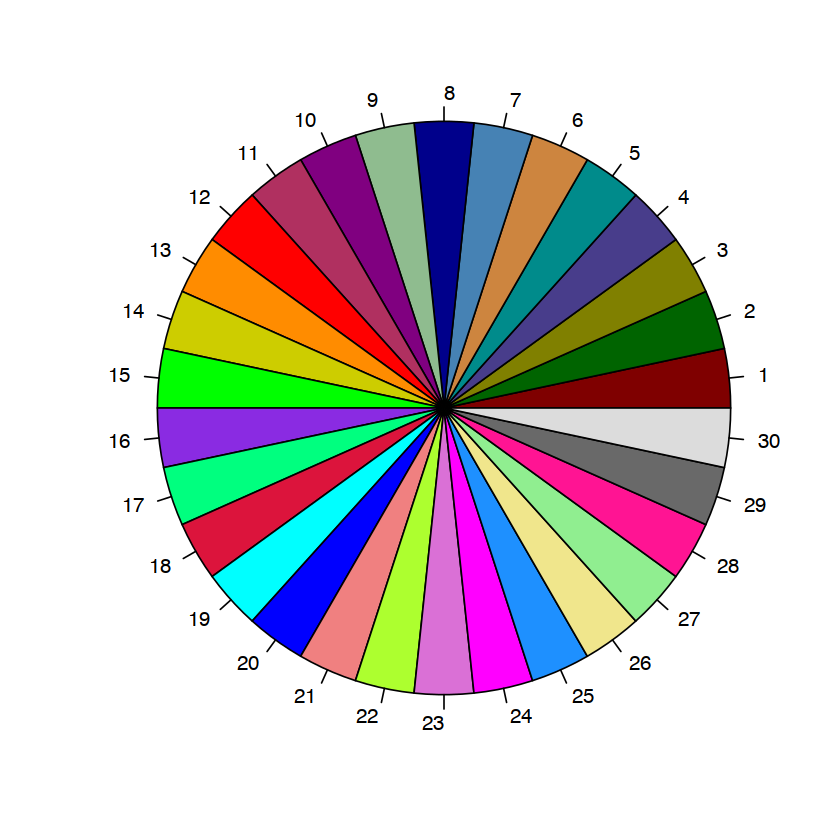

In [3]:
#cbPalette <- paletteer_d(package = "ggthemes", palette="calc", n=12)
c30 <- c(
        "#7f0000", # maroon2
        "#006400", # darkgreen
        "#808000", # olive
        "#483d8b", # darkslateblue
        "#008b8b", # darkcyan
        "#cd853f", # peru
        "#4682b4", # steelblue
        "#00008b", # darkblue
        "#8fbc8f", # darkseagreen
        "#800080", # purple
        "#b03060", # maroon3
        "#ff0000", # red
        "#ff8c00", # darkorange
        "#cdcd00", # yellow3
        "#00ff00", # lime
        "#8a2be2", # blueviolet
        "#00ff7f", # springgreen
        "#dc143c", # crimson
        "#00ffff", # aqua
        "#0000ff", # blue
        "#f08080", # lightcoral
        "#adff2f", # greenyellow
        "#da70d6", # orchid
        "#ff00ff", # fuchsia
        "#1e90ff", # dodgerblue
        "#f0e68c", # khaki
        "#90ee90", # lightgreen
        "#ff1493", # deeppink
        "#696969", # dimgray
        "#dcdcdc"  # gainsboro
)
 
pie(rep(1,30), col = c30, radius = 1)

In [4]:
# Choosing colours for samples
c_sample_col <- c30[c(1,3,23,19,30)]
# Choosing colour for samples
c_clust_col <- c30[c(1,2,3,4,5,6,7,8,9,11,12,14,19,22,24,25)]

### Setting seed
We also set known seed to facilitate replication of operations requiring randomization.

In [5]:
set.seed(1)

### Setting thread

Next, we set the default number of threads for `ArchR` functions. This is something we will have to do during each new R session. `ArchR` recommend setting threads to **1/2** to **3/4** of the total available cores. The memory usage in `ArchR` will often scale with the number of threads used so allowing `ArchR` to use more threads will also lead to higher memory usage.

In [6]:
addArchRThreads(threads = 2)

Setting default number of Parallel threads to 2.



### Setting genome

Then, we set the genome to be used for gene and genome annotations. As above, this is something we will have to do during each new R session. Of course, this genome version must match the **genome version that was used for alignment**. For this data, we will use the `hg38` reference genome.

In [7]:
addArchRGenome("hg38")

Setting default genome to Hg38.



The precompiled version of the `hg38` genome in ArchR uses `BSgenome.Hsapiens.UCSC.hg38`, `TxDb.Hsapiens.UCSC.hg38.knownGene`, `org.Hs.eg.db`, and a blacklist that was merged using `ArchR::mergeGR()` from the `hg38 v2` blacklist regions and from mitochondrial regions that show high mappability to the `hg38` nuclear genome from Caleb Lareau and Jason Buenrostro. 

### 1.1 Creating Arrow Files

Now we will create our Arrow files which will take 10-15 minutes. For each sample, this step will:

1. Read accessible fragments from the provided input files.
2. Calculate quality control information for each cell (i.e. TSS enrichment scores and nucleosome info).
3. Filter cells based on quality control parameters.
4. Create a genome-wide TileMatrix using 500-bp bins.
5. Create a `GeneScoreMatrix` using the custom geneAnnotation that was defined when we called `addArchRGenome()`.

Before creating the Arrow files, we first need to read the valid barcode files using the function `getValidBarcodes()` 


In [8]:
validBarcodes <- getValidBarcodes(csvFiles=c('fragment_files/201209_singlecell.csv',
                                             'fragment_files/201216_singlecell.csv'),
                                 sampleNames = c('Adenocarcinoma Tumour',
                                                'Liver Metastasis'))

In [9]:
validBarcodes

List of length 2
names(2): Adenocarcinoma Tumour Liver Metastasis

In [10]:
str(validBarcodes)

Formal class 'SimpleList' [package "S4Vectors"] with 4 slots
  ..@ listData       :List of 2
  .. ..$ Adenocarcinoma Tumour: chr [1:2506] "AAACGAAAGAACAGGA-1" "AAACGAAAGCCTTTGA-1" "AAACGAAAGGAGTAGA-1" "AAACGAAGTCTGGGCT-1" ...
  .. ..$ Liver Metastasis     : chr [1:1356] "AAACGAAAGAGTAAGG-1" "AAACGAAAGGTTGACG-1" "AAACGAACAAGATGCG-1" "AAACGAAGTAACGGCA-1" ...
  ..@ elementType    : chr "ANY"
  ..@ elementMetadata: NULL
  ..@ metadata       : list()


In [11]:
inputFiles <- c('fragment_files/201209_fragments.tsv.gz',
               'fragment_files/201216_fragments.tsv.gz')

In [13]:
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles, # Path of the fragment files
  sampleNames = c('Adenocarcinoma Tumour','Liver Metastasis'), # Sample names
  filterTSS = 4,      # Dont set this too high because you can always increase later. 
                      # The minimum numeric transcription start site (TSS) enrichment score required for a cell 
                      # to pass filtering for use in downstream analyses. Cells with a TSS enrichment score greater than or equal to filterTSS will be retained. 
                      # TSS enrichment score is a measurement of signal-to-background in ATAC-seq.
  filterFrags = 1000, # minimum number of mapped ATAC-seq fragments required per cell to pass filtering for use in downstream analyses. 
                      #Cells containing greater than or equal to filterFrags total fragments wll be retained.
  validBarcodes = validBarcodes, # List of valid Barcodes
  addTileMat = TRUE,  #A boolean value indicating whether to add a "Tile Matrix" to each ArrowFile. 
                      # A Tile Matrix is a counts matrix that, instead of using peaks, 
                      # uses a fixed-width sliding window of bins across the whole genome. 
                      # This matrix can be used in many downstream ArchR operations
  addGeneScoreMat = TRUE #A boolean value indicating whether to add a Gene-Score Matrix to each ArrowFile. 
                         # A Gene-Score Matrix uses ATAC-seq signal proximal to the TSS to estimate gene activity.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

ArchR logging to : ArchRLogs/ArchR-createArrows-cc161277aaae-Date-2021-04-08_Time-13-23-00.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2021-04-08 13:23:01 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-createArrows-cc161277aaae-Date-2021-04-08_Time-13-23-00.log



## 1.2 Quality control per cell

Strict quality control (QC) of scATAC-seq data is essential to remove the contribution of low-quality cells. In `ArchR`, we consider three characteristics of data:

1. The number of unique nuclear fragments (i.e. not mapping to mitochondrial DNA).
2. The signal-to-background ratio. Low signal-to-background ratio is often attributed to dead or dying cells which have de-chromatinzed DNA which allows for random transposition genome-wide.
3. The fragment size distribution. Due to nucleosomal periodicity, we expect to see depletion of fragments that are the length of DNA wrapped around a nucleosome (approximately 147 bp).

> **Unique nuclear fragments**, is straightforward - cells with very few usable fragments will not provide enough data to make useful interpretations and should therefore be excluded.

> **Signal-to-background ratio**, is calculated as the **TSS enrichment score**. Traditional bulk ATAC-seq analysis has used this TSS enrichment score for determination of signal-to-background (for example, the [ENCODE project](https://www.encodeproject.org/atac-seq/)). The idea behind the TSS enrichment score metric is that ATAC-seq data is universally enriched at gene TSS regions compared to other genomic regions, due to large protein complexes that bind to promoters. By looking at per-basepair accessibility centered at these TSS regions, we see a local enrichment relative to flanking regions (1900-2000 bp distal in both directions). The ratio between the peak of this enrichment (centered at the TSS) relative to these flanking regions represents the TSS enrichment score.

Traditionally, the per-base-pair accessibility is computed for each bulk ATAC-seq sample and then this profile is used to determine the TSS enrichment score. Performing this operation on a per-cell basis in scATAC-seq is relatively slow and computationally expensive. To accurately approximate the TSS enrichment score per single cell, `ArchR` count the average accessibility within a 50-bp region centered at each single-base TSS position and divide this by the average accessibility of the TSS flanking positions (+/- 1900 – 2000 bp). This approximation was highly correlated (R > 0.99) with the original method and values were extremely close in magnitude.

> **Fragment size distribution**, is generally less important but always good to manually inspect. Because of the patterned way that DNA wraps around nucleosomes, we expect to see a nucleosomal periodicity in the distribution of fragment sizes in our data. These hills and valleys appear because fragments must span 0, 1, 2, etc. nucleosomes (Tn5 cannot cut DNA that is tightly wrapped around a nucleosome.

By default in ArchR, pass-filter cells are identified as those cells having a TSS enrichment score greater than 4 and more than 1000 unique nuclear fragments. It is important to note that the actual numeric value of the TSS enrichment score depends on the set of TSSs used. The default values in ArchR were designed for human data and it may be important to change the default thresholds when running createArrowFiles().

Creation of Arrow files created a folder in the current working directory called “QualityControl” which will contain 2 plots associated with each of our samples. The first plot shows the log10(unique nuclear fragments) vs TSS enrichment score and indicates the thresholds used with dotted lines. The second shows the fragment size distribution.


![](QualityControl/Week_7/Week_7-Fragment_Size_Distribution.pdf) 

## 1.3 Inferring Doublets
After Arrow file creation, we can infer potential doublets (a single droplet containing multiple cells) that can confound downstream results. This is done using the `addDoubletScores()` function.

### How does doublet identification work in ArchR?

Single-cell data generated on essentially any platform is susceptible to the presence of doublets. A doublet refers to a single droplet that received a single barcoded bead and more than one nucleus. This causes the reads from more than one cell to appear as a single cell. For 10x, the percentage of total “cells” that are actually doublets is proportional to the number of cells loaded into the reaction. Even at the lower levels of doublets that result from standard kit use, more than 5% of the data may come from doublets and this exerts substantial effects on clustering. This issue becomes particularly problematic in the context of developmental/trajectory data because doublets look like a mixture between two cell types and this can be confounded with intermediate cell types or cell states.

To predict which “cells” are actually doublets, we synthesize in silico doublets from the data by mixing the reads from thousands of combinations of individual cells. We then project these synthetic doublets into the UMAP embedding and identify their nearest neighbor. By iterating this procedure thousands of times, we can identify “cells” in our data whose signal looks very similar to synthetic doublets.

<img src="documentFigures/doubletRemoval.png" width="50%">

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-cc1659a0da87-Date-2021-04-08_Time-13-54-06.log
If there is an issue, please report to github with logFile!

2021-04-08 13:54:06 : Batch Execution w/ safelapply!, 0 mins elapsed.

Adenocarcinoma Tumour (1 of 2) : UMAP Projection R^2 = 0.99439

Adenocarcinoma Tumour (1 of 2) : UMAP Projection R^2 = 0.99439



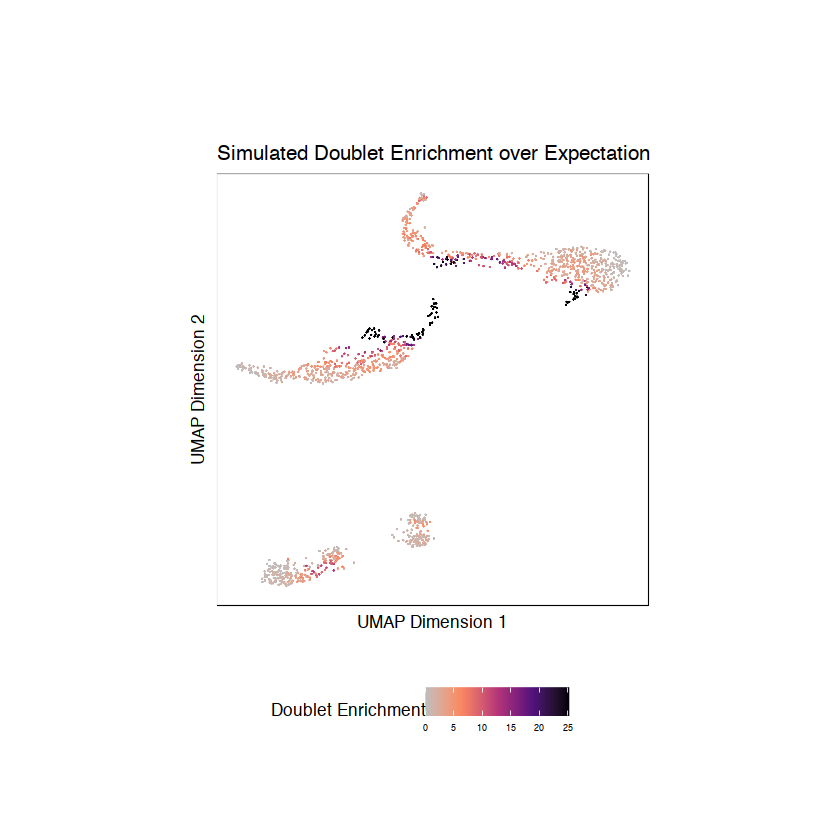

Liver Metastasis (2 of 2) : UMAP Projection R^2 = 0.96789

Liver Metastasis (2 of 2) : UMAP Projection R^2 = 0.96789

ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-cc1659a0da87-Date-2021-04-08_Time-13-54-06.log



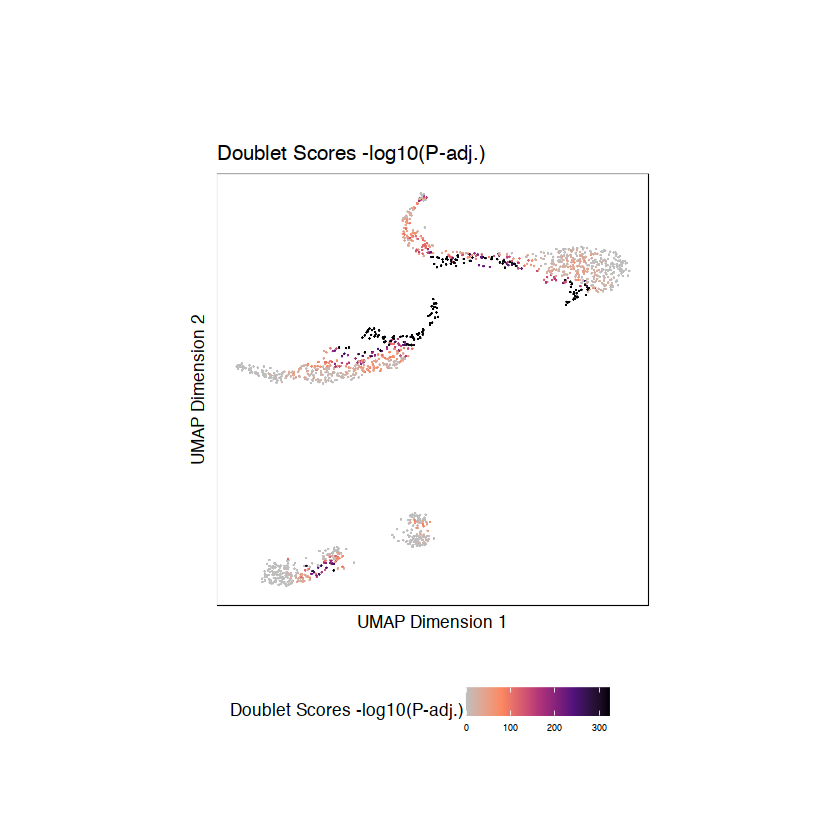

In [14]:
doubScores <- addDoubletScores(
    input = ArrowFiles,
    k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
    knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search with doublet projection.
    UMAPParams = list(n_neighbors = 20),
    LSIMethod = 1,
    verbose = FALSE
)

In the above output, ArchR reports the R2 value for the UMAP projection for each Arrow file. If these R2 values are much lower (i.e. less than 0.9), this often indicates that the cells within the Arrow file have very little heterogeneity. This makes the accuracy of doublet calling worse because the majority of doublets would be “homotypic” - or a single droplet with two very similar cells. In these cases, we recommend skipping doublet prediction. Alternatively, you can try setting knnMethod = "LSI" and force = TRUE to perform projection in the LSI subspace; however, you should manually assess the results and make sure this is performing as you would expect.

Adding doublet scores will create plots in the “QualityControl” directory. There are 3 plots associated with each of your samples in this folder:

1. **Doublet Enrichments** - These represent the enrichment of simulated doublets nearby each single cell compared to the expected if we assume a uniform distribution.
2. **Doublet Scores** - These represent the significance (-log10(binomial adjusted p-value)) of simulated doublets nearby each single cell compared to the expected if we assume a uniform distribution. We have found this value to be less consistent than the doublet enrichments and therefore use doublet enrichments for doublet identification.
3. **Doublet Density** - This represents the density of the simulated doublet projections. This allows you to visualize where the synthetic doublets were located after projection into your 2-dimensional embedding.

## 1.4 Creating an ArchRProject
An ArchRProject allows us to group multiple Arrow files together into a single project. This ArchRProject is small and is stored in memory. By interacting with the ArchRProject we can rapidly push and pull data from the Arrow files. As such, it forms the basis of nearly all ArchR functions and analytical workflows. Moreover, ArchRProject objects can be saved and re-loaded at a later date, providing continuity of analyses and facilitating sharing of analytical projects across collaborators. 

We can see from the above that our ArchRProject has been initialized with a few important attributes:

1. The specified outputDirectory.
2. The sampleNames of each sample which were obtained from the Arrow files.
3. A matrix called sampleColData which contains data associated with each sample.
4. A matrix called cellColData which contains data associated with each cell. Because we already computed doublet enrichment scores using addDoubletScores(), which added those values to each cell in the Arrow files, we can see columns corresponding to the “DoubletEnrichment” and “DoubletScore” in the cellColData matrix.
5. The total number of cells in our project which represents all samples after doublet identification and removal.
6. The median TSS enrichment score and the median number of fragments across all cells and all samples.

### Calculating Gene Scores in ArchR

This class of model, which is implemented as the default in ArchR, has three major components:

- Accessibility within the entire gene body contributes to the gene score.
- An exponential weighting function that accounts for the activity of putative distal regulatory elements in a distance-dependent fashion.
- Imposed gene boundaries that minimizes the contribution of unrelated regulatory elements to the gene score.

For each chromosome, `ArchR` creates a tile matrix using a user-defined tile size that is not pre-computed (default is 500 bp), overlaps these tiles with the user-defined gene window (default is 100 kb on either side of the gene), and then computes the distance from each tile (start or end) to the gene body (with optional extensions upstream or downstream) or gene start. We have found that the best predictor of gene expression is the local accessibility of the gene region which includes the promoter and gene body. As mentioned above, to properly account for distal accessibility for a given gene, `ArchR` identifies the subset of tiles that are within the gene window and do not cross another gene region. This filtering allows for inclusion of distal regulatory elements that could improve the accuracy of predicting gene expression values but excludes regulatory elements more likely to be associated with another gene (for ex. the promoter of a nearby gene). The distance from each tile to the gene is then converted to a distance weight using a user-defined accessibility model (default is $e^{-abs(distance)/5000} + e^{-1})$. When the gene body is included in the gene region (where the distance-based weight is the maximum weight possible), we found that extremely large genes can bias the overall gene scores. In these cases, the total gene scores can vary substantially due to the inclusion of insertions in both introns and exons. To help adjust for these large differences in gene size, `ArchR` applies a separate weight for the inverse of the gene size ($\frac{1}{gene size}$) and scales this inverse weight linearly from 1 to a user-defined hard maximum (default of 5). Smaller genes thus receive larger relative weights, partially normalizing this length effect. The corresponding distance and gene size weights are then multiplied by the number of Tn5 insertions within each tile and summed across all tiles within the gene window, while still accounting for nearby gene regions as described above. This summed accessibility is a “gene score” and is depth normalized across all genes to a user-defined constant (default of 10,000). Computed gene scores are then stored in the corresponding Arrow file for downstream analyses.

To illustrate what the default ArchR gene score model looks like, we provide this toy example showing the weighting applied across the entire gene region:

<img src="documentFigures/GeneActivityScore_Schematic.png" width="50%">

In [15]:
chrisAggrproj <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = "chrisAggrproj",
  showLogo = FALSE,
  copyArrows = TRUE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 
2 


Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...



**Now we can filter putative doublets based on the previously determined doublet scores using the filterDoublets() function. This doesn’t physically remove data from the Arrow files but rather tells the ArchRProject to ignore these cells for downstream analysis.**

In [16]:
chrisAggrproj <- filterDoublets(ArchRProj = chrisAggrproj)

Filtering 28 cells from ArchRProject!

	Adenocarcinoma Tumour : 20 of 1420 (1.4%)

	Liver Metastasis : 8 of 943 (0.8%)



In [17]:
chrisAggrproj


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj 
samples(2): Adenocarcinoma Tumour Liver Metastasis
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 2335
medianTSS(1): 5.335
medianFrags(1): 29972

Cells passing the QC in three samples

In [18]:
table(chrisAggrproj$Sample)


Adenocarcinoma Tumour      Liver Metastasis 
                 1400                   935 

In [20]:
p1 <- plotGroups(
    ArchRProj = chrisAggrproj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "ridges"
   )

p2 <- plotGroups(
    ArchRProj = chrisAggrproj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "ReadsInTSS",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )

p3 <- plotGroups(
    ArchRProj = chrisAggrproj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "ReadsInPromoter",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )

p4 <- plotGroups(
    ArchRProj = chrisAggrproj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "ReadsInBlacklist",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )
p5 <- plotGroups(
    ArchRProj = chrisAggrproj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "PromoterRatio",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )

1 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”


1 


1 


1 


1 




Picking joint bandwidth of 0.257



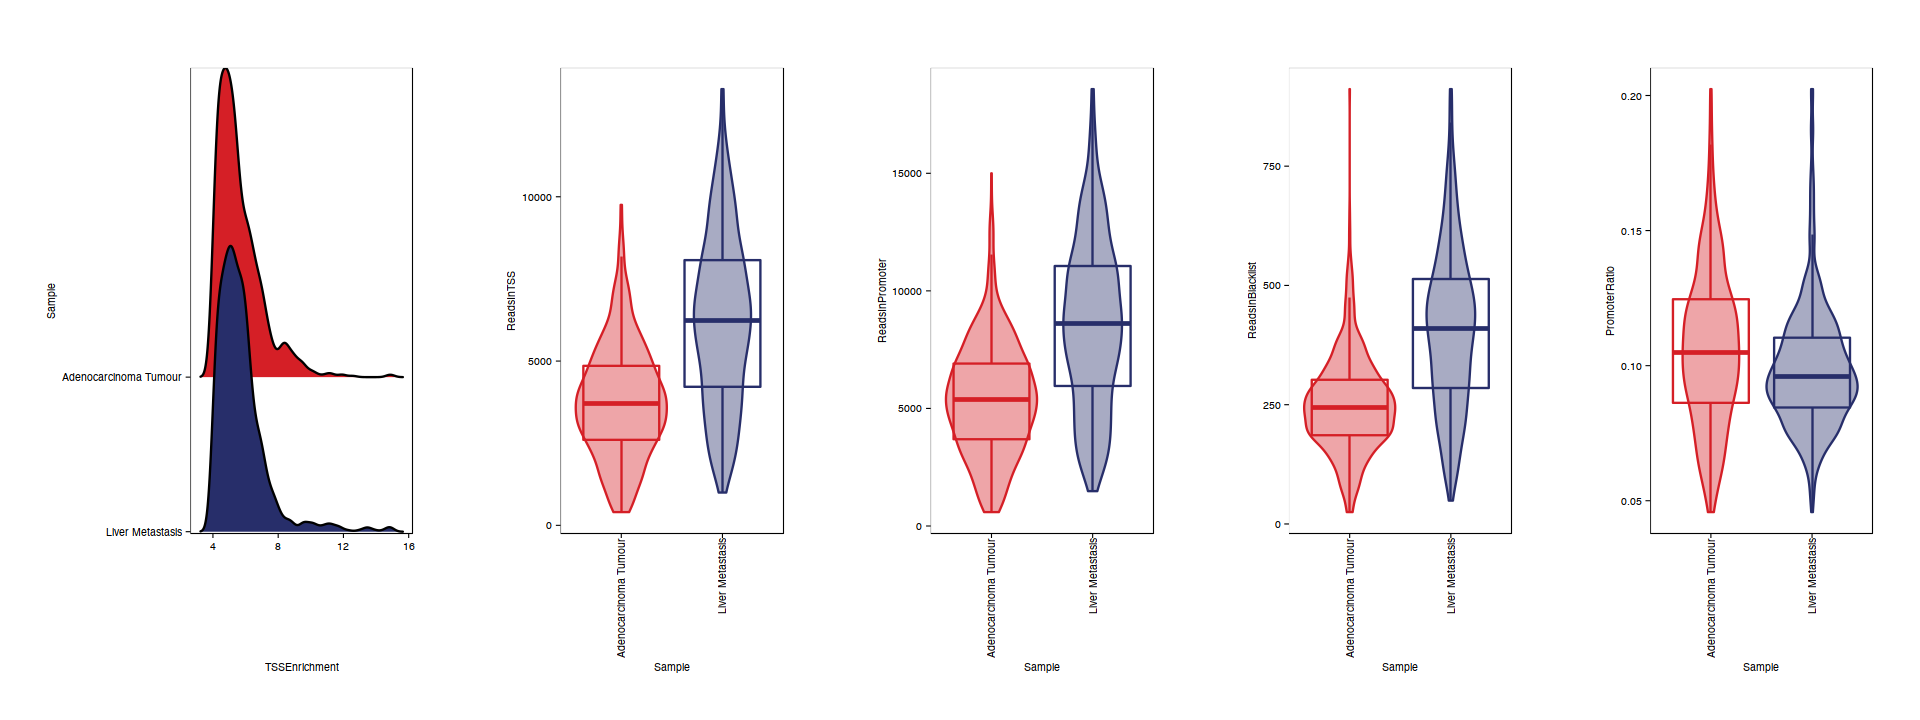

In [21]:
options(repr.plot.width=16, repr.plot.height=6)
ggAlignPlots(p1, p2, p3, p4, p5, type = "h")

### Saving project

In [22]:
chrisAggrproj <- saveArchRProject(ArchRProj = chrisAggrproj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

In [23]:
paste0("Memory Size = ", round(object.size(chrisAggrproj) / 10^6, 3), " MB")

[1] "Memory Size = 58.556 MB"

In [24]:
getAvailableMatrices(chrisAggrproj)

[1] "GeneScoreMatrix" "TileMatrix"

# 2 Dimensionality Reduction and Clustering

ArchR implements a **few different** LSI implementations and we have benchmarked many of these methods across multiple different test data sets. ArchR’s default LSI implementation is related to the method introduced by Timothy Stuart in [Signac](https://satijalab.org/signac/), which uses a term frequency that has been depth normalized to a constant (10,000) followed by normalization with the inverse document frequency and then log-transforming the resultant matrix (aka log(TF-IDF)).

One of the key inputs to LSI dimensionality reduction is the starting matrix. Thus far, the two main strategies in scATAC-seq have been to 
1. Use peak regions: However, using peak regions for LSI is inherently challenging because we do not have clusters or cluster-specific peaks prior to dimensionality reduction. Moreover, calling peaks on aggregated cells prior to clustering obscures cell type-specific peaks. Moreover, any union peak set will change when new samples are added to an experiment, making this strategy less stable.

2. Genome-wide tiles: mitigates these issues by using a consistent and unbiased feature set (genome-wide tiles). However, a genome-wide tile matrix of all cells by all regions can become prohibitively large. For this reason, most implementations use tiles that are greater than or equal to 5 kilobases in size. This drastically reduces the resolution of the approach because most accessible regions are only a few hundred basepairs long.

Because of the way that Arrow files are designed, ArchR is able to perform LSI very rapidly using genome-wide 500-bp tiles. This solves the problem of resolution and allows for the identification of clusters prior to calling peaks. The challenge is that 500-bp bins generate around 6 million features to be included in the cell by tile matrix. While ArchR is able to read this large amount of data into R by chunking the relevant matrices, we have also implemented an “estimated LSI” approach that performs the initial dimensionality reduction on a subset of the total cells. This estimated LSI approach has two main utilities - (i) it speeds up dimensionality reduction and (ii) as you decrease the number of cells used in the intial dimensionality reduction, this decreases the granularity of the data. This reduction in granularity can be used to your advantage to reduce batch effects in your data. However, it can also obscure true biology so estimated LSI approaches should be used under close manual supervision.

## 2.1 Iterative Latent Semantic Indexing (LSI)

In scRNA-seq identifying variable genes is a common way to compute dimensionality reduction (such as PCA). This is done because these highly variable genes are more likely to be biologically important and this reduces experimental noise. In scATAC-seq the data is **binary** and thus you cannot identify variable peaks for dimensionality reduction. Rather than identifying the most variable peaks, we have tried using the most accessible features as input to LSI; however, the results when running multiple samples have shown high degrees of noise and low reproducibility. To remedy this we introduced the **iterative LSI** approach ([Satpathy*, Granja* et al. Nature Biotechnology 2019](https://www.ncbi.nlm.nih.gov/pubmed/31375813) and [Granja*, Klemm* and McGinnis* et al. Nature Biotechnology 2019](https://www.ncbi.nlm.nih.gov/pubmed/31792411)). This approach computes an inital LSI transformation on the most accessible tiles and identifies lower resolution clusters that are not batch confounded. For example, when performed on peripheral blood mononuclear cells, this will identify clusters corresponding to the major cell types (T cells, B cells, and monocytes). Then `ArchR` computes the average accessibility for each of these clusters across all features. ArchR then identifies the most variable peaks across these clusters and uses these features for LSI again. In this **second iteration**, the most variable peaks are more similar to the variable genes used in scRNA-seq LSI implementations. The user can set how many iterations of LSI should be performed. We have found this approach to minimize observed batch effects and allow dimensionality reduction operations on a more reasonably sized feature matrix.

<img src="documentFigures/IterativeLSI_Flowchart.png" width="80%">

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-cc167920c9b2-Date-2021-04-08_Time-13-58-55.log
If there is an issue, please report to github with logFile!



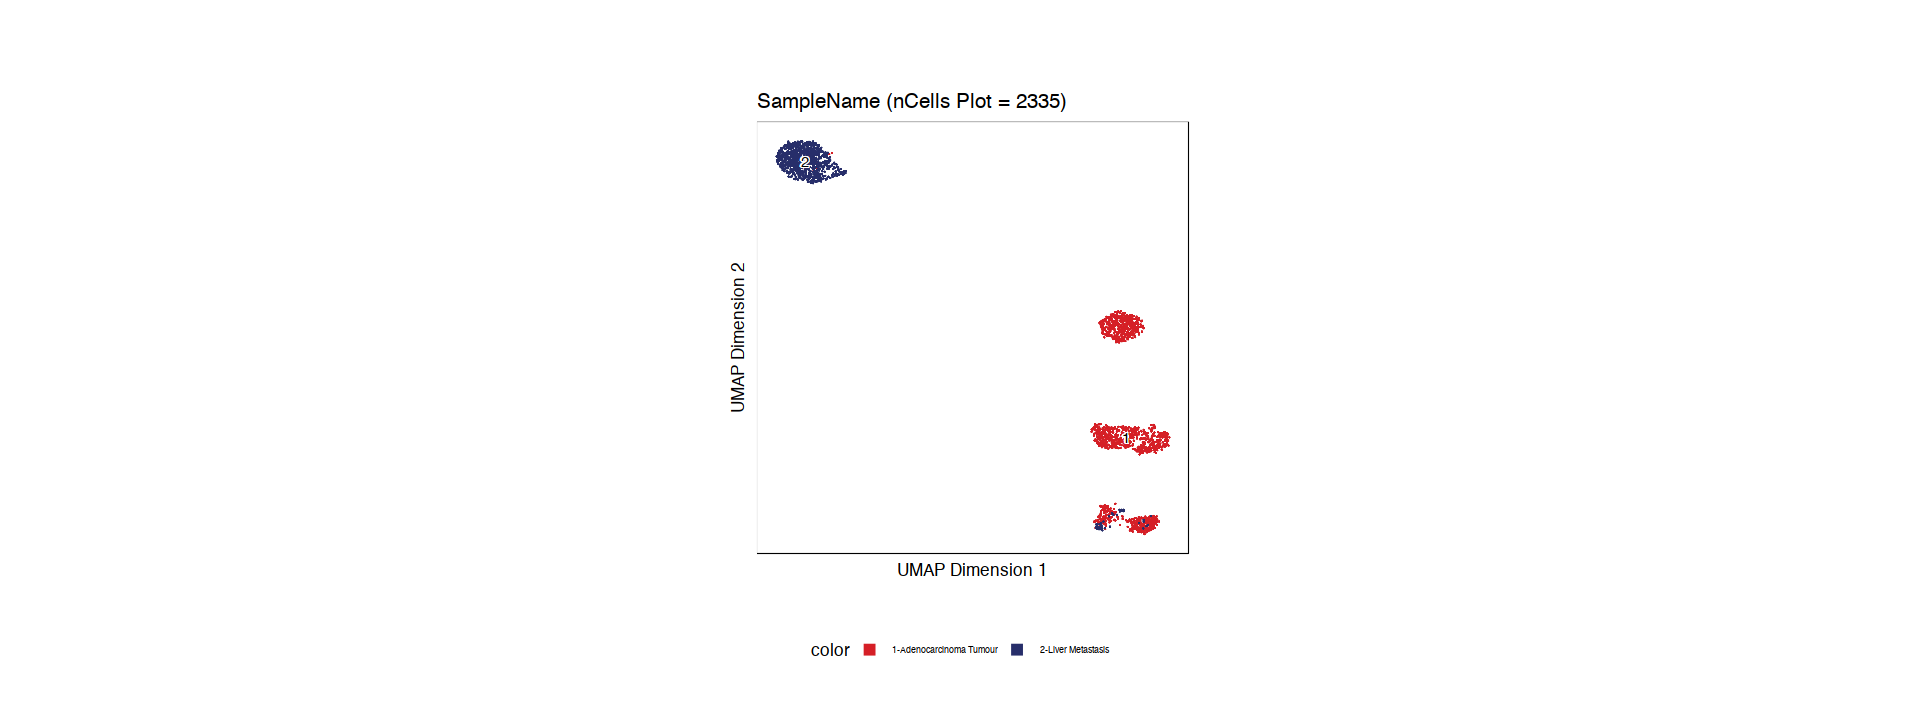

In [25]:
chrisAggrproj <- addIterativeLSI(ArchRProj = chrisAggrproj, 
                                 useMatrix = "TileMatrix", 
                                 name = "IterativeLSI", 
                                 verbose=FALSE)

**If we see downstream that you have subtle batch effects, another option is to add more LSI iterations and to start from a lower intial clustering resolution. Additionally the number of variable features can be lowered to increase focus on the more variable features.**

## 2.2 Add cluster

In `ArchR`, clustering is performed using the `addClusters()` function which permits additional clustering parameters to be passed to the `Seurat::FindClusters()` function via .... In our hands, clustering using `Seurat::FindClusters()` is deterministic, meaning that the exact same input will always result in the exact same output.

In [26]:
chrisAggrproj <- addClusters(input = chrisAggrproj, reducedDims = "IterativeLSI", verbose=FALSE)

ArchR logging to : ArchRLogs/ArchR-addClusters-cc16672590fa-Date-2021-04-08_Time-14-00-12.log
If there is an issue, please report to github with logFile!



In [27]:
df <- data.frame(Sample = chrisAggrproj$Sample, Clusters = chrisAggrproj$Clusters)

In [28]:
table_samples_by_clusters <- as_tibble(df) %>%
  group_by(Sample, Clusters) %>%
  summarize(count = n()) %>%
  spread(Clusters, count, fill = 0) %>%
  ungroup() %>%
  mutate(total_cell_count = rowSums(.[c(2:ncol(.))])) %>%
  dplyr::select(c('Sample', 'total_cell_count', everything()))

`summarise()` has grouped output by 'Sample'. You can override using the `.groups` argument.



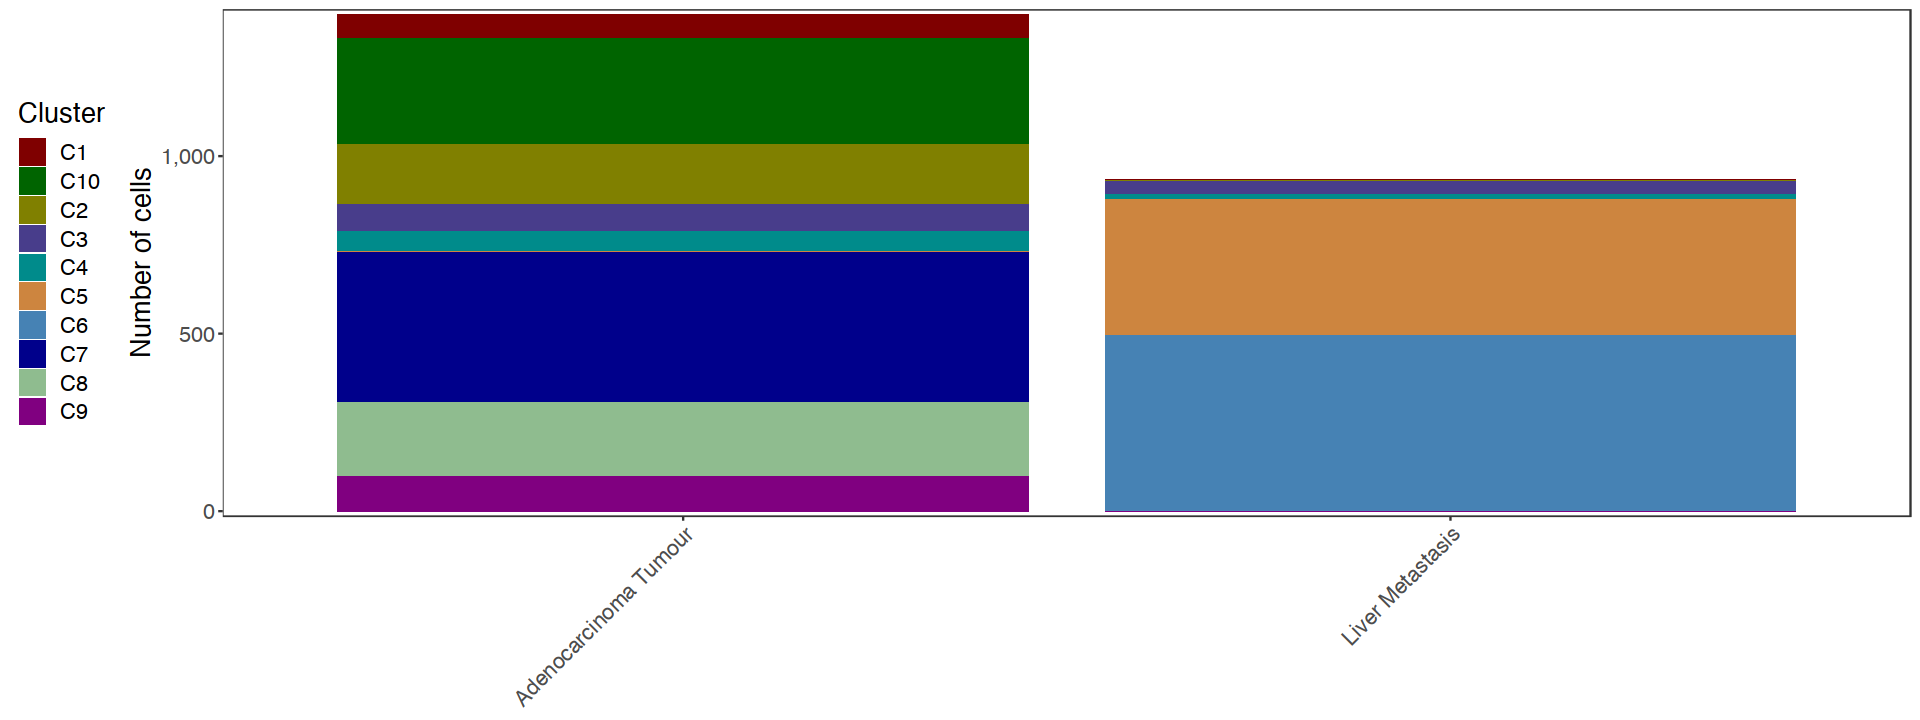

In [29]:
p1 <- table_samples_by_clusters %>%
  dplyr::select(-c('total_cell_count')) %>%
  reshape2::melt(id.vars = 'Sample') %>%
  mutate(Sample = factor(Sample)) %>%
  ggplot(aes(Sample, value, fill = variable)) +
  geom_bar(position = 'stack', stat = 'identity') +
  scale_fill_manual(name = 'Cluster', values = c30) +
  scale_y_continuous(name = 'Number of cells', labels = scales::comma, expand = c(0.01, 0)) +
  theme_bw() +
  theme(
    legend.position = 'left',
    plot.title = element_text(hjust = 0.5),
    text = element_text(size = 16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)
  )
p1

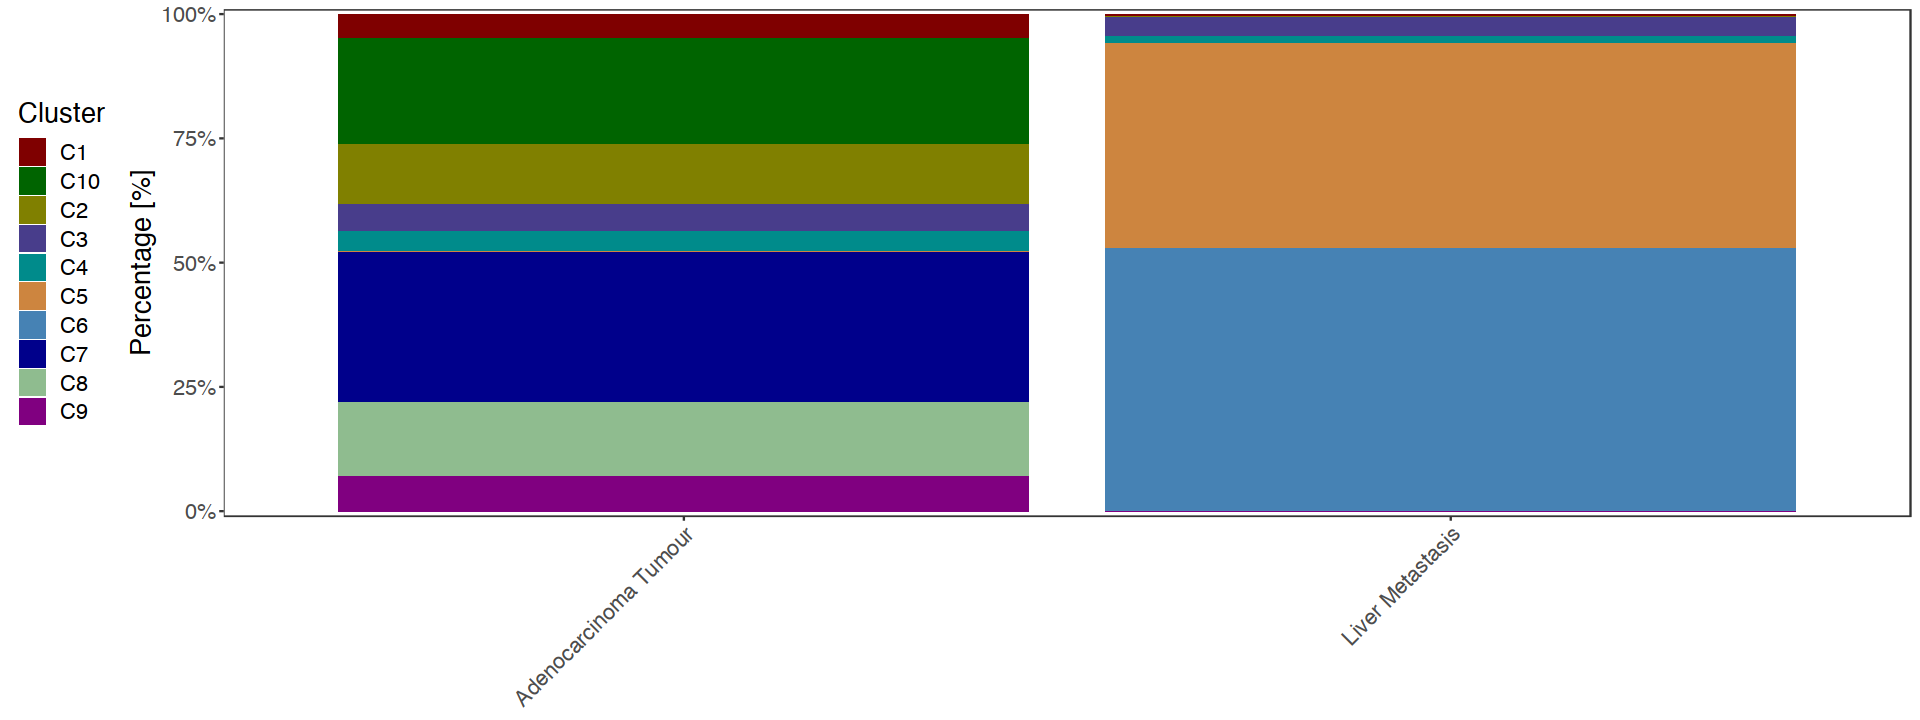

In [30]:
p1 <- table_samples_by_clusters %>%
  dplyr::select(-c('total_cell_count')) %>%
  reshape2::melt(id.vars = 'Sample') %>%
  mutate(Sample = factor(Sample)) %>%
  ggplot(aes(Sample, value, fill = variable)) +
  geom_bar(position = 'fill', stat = 'identity', show.legend = TRUE) +
  scale_fill_manual(name = 'Cluster', values = c30) +
  scale_y_continuous(name = 'Percentage [%]', labels = scales::percent_format(), expand = c(0.01,0)) +
  theme_bw() +
  theme(
    legend.position = 'left',
    plot.title = element_text(hjust = 0.5),
    text = element_text(size = 16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)
  )
p1

In [37]:
plotPDF(p1, name = "Cluster_assignment_percent.pdf",
        ArchRProj = chrisAggrproj, addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!



To better understand which samples reside in which clusters, we can create a cluster confusion matrix across each sample using the `confusionMatrix()` function.

In [32]:
cM <- confusionMatrix(paste0(chrisAggrproj$Clusters), paste0(chrisAggrproj$Sample))
cM

10 x 2 sparse Matrix of class "dgCMatrix"
    Adenocarcinoma Tumour Liver Metastasis
C8                    208                .
C9                     97                .
C7                    424                .
C10                   300                .
C1                     68                4
C2                    168                3
C3                     75               36
C4                     57               13
C5                      3              384
C6                      .              495

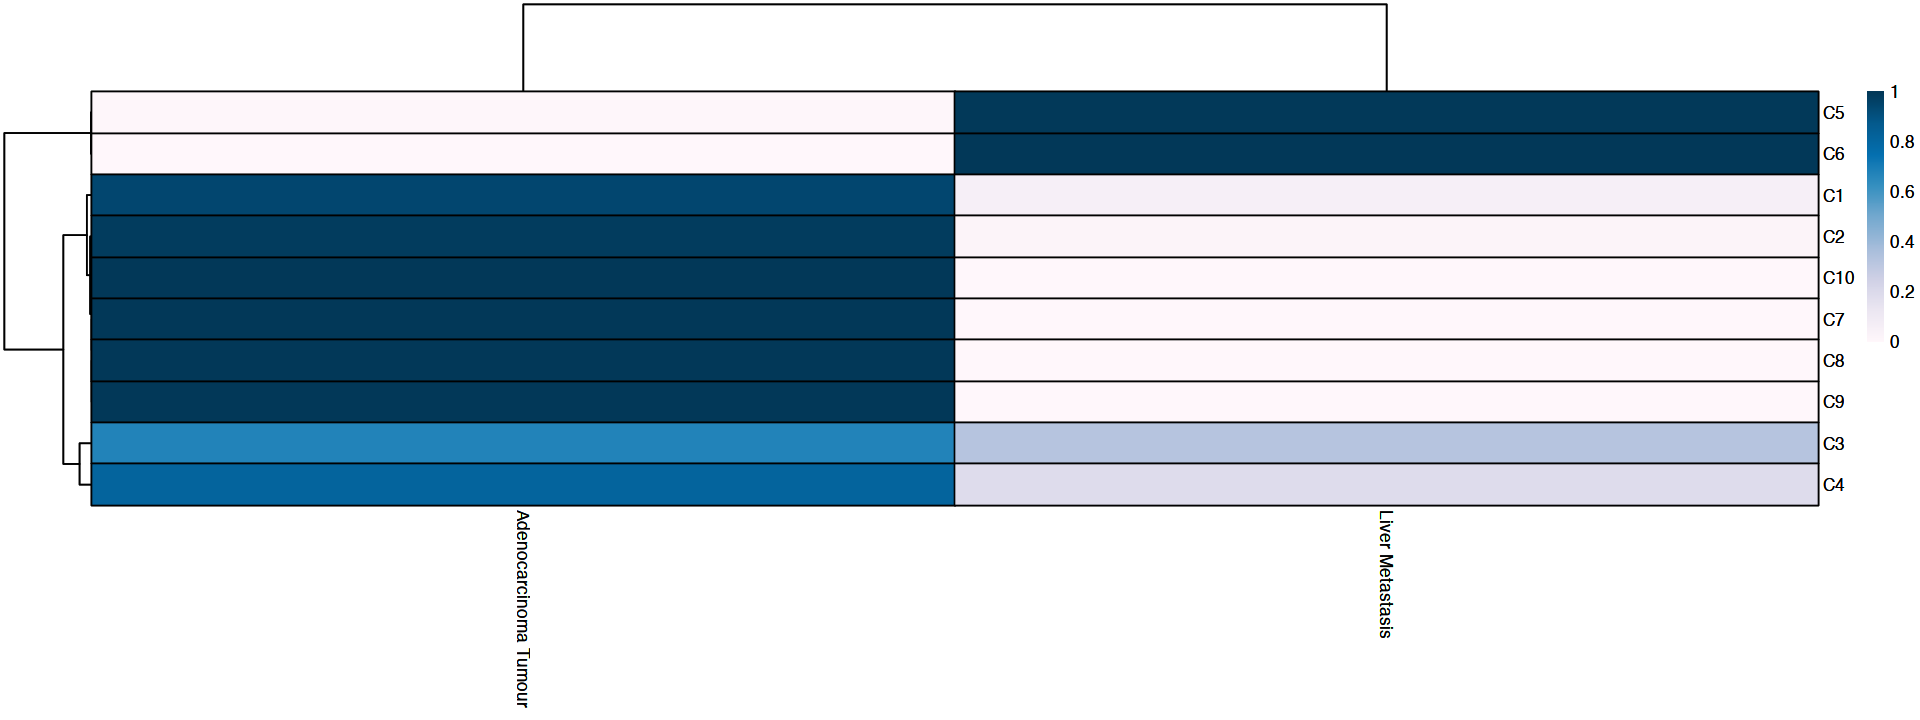

In [33]:
cM <- cM / Matrix::rowSums(cM)
p <- pheatmap::pheatmap(
    mat = as.matrix(cM), 
    color = paletteContinuous("whiteBlue"), 
    border_color = "black"
)
p

In [36]:
plotPDF(p, name = "Cluster_assignment.pdf",
        ArchRProj = chrisAggrproj, addDOC = FALSE, width = 5, height = 5)

Plotting Other



## 2.3 Visualizing in a 2D UMAP Embedding
We can visualize our scATAC-seq data using a 2-dimensional representation such as Uniform Manifold Approximation and Projection (UMAP). To do this, we add a UMAP embedding to our ArchRProject object with the addUMAP() function. This function uses the uwot package to perform UMAP.

In [38]:
chrisAggrproj <- addUMAP(ArchRProj = chrisAggrproj, reducedDims = "IterativeLSI", verbose=FALSE, saveModel = FALSE)

Using this UMAP, we can visualize various attributes of our cells which are stored in a matrix called cellColData in our ArchRProject. To do this, we use the plotEmbedding() function and we specify the variable to use for coloration via a combination of the colorBy and name parameters.

For example, we can color by “Sample”:

In [39]:
p1 <- plotEmbedding(ArchRProj = chrisAggrproj, 
                    colorBy = "cellColData", 
                    name = "Sample", 
                    embedding = "UMAP", 
                    alpha=0.5,size=1)+ 
    theme_classic(base_size=12) + 
    guides(colour = guide_legend(override.aes = list(size=4))) 


p2 <- plotEmbedding(ArchRProj = chrisAggrproj, 
                    colorBy = "cellColData", 
                    name = "Clusters", 
                    embedding = "UMAP", size=1)+ 
    theme_classic(base_size=12) + 
    guides(colour = guide_legend(override.aes = list(size=4))) 

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-cc161f81d74c-Date-2021-04-08_Time-14-37-04.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-cc161f81d74c-Date-2021-04-08_Time-14-37-04.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-cc1676e9660f-Date-2021-04-08_Time-14-37-04.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-cc1676e9660f-Date-2021-04-08_Time-14-37-04.log



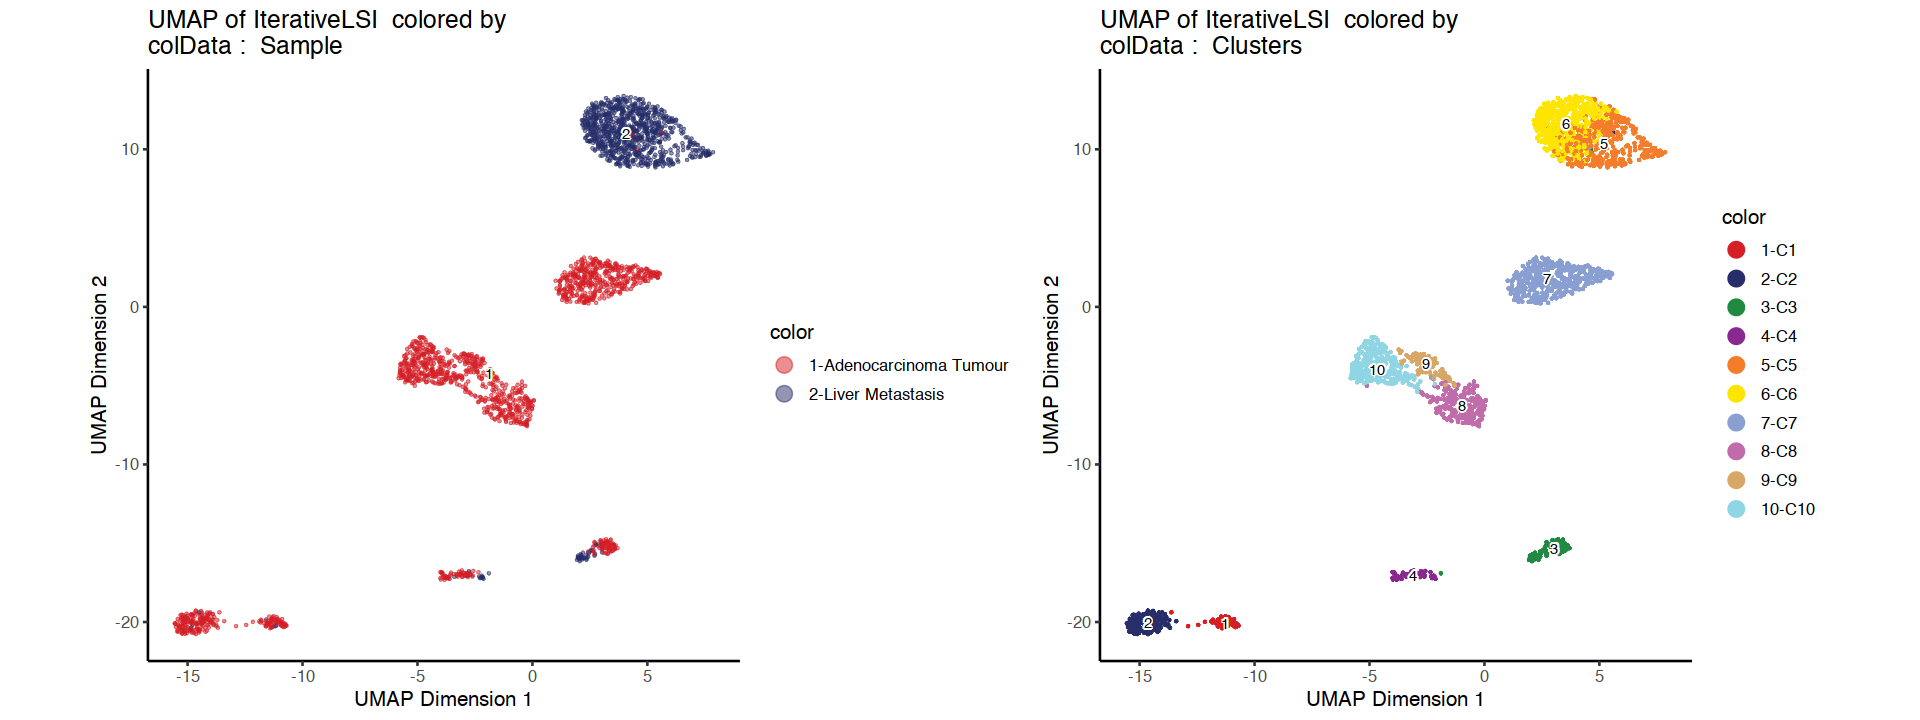

In [40]:
ggAlignPlots(p1, p2, type = "h")

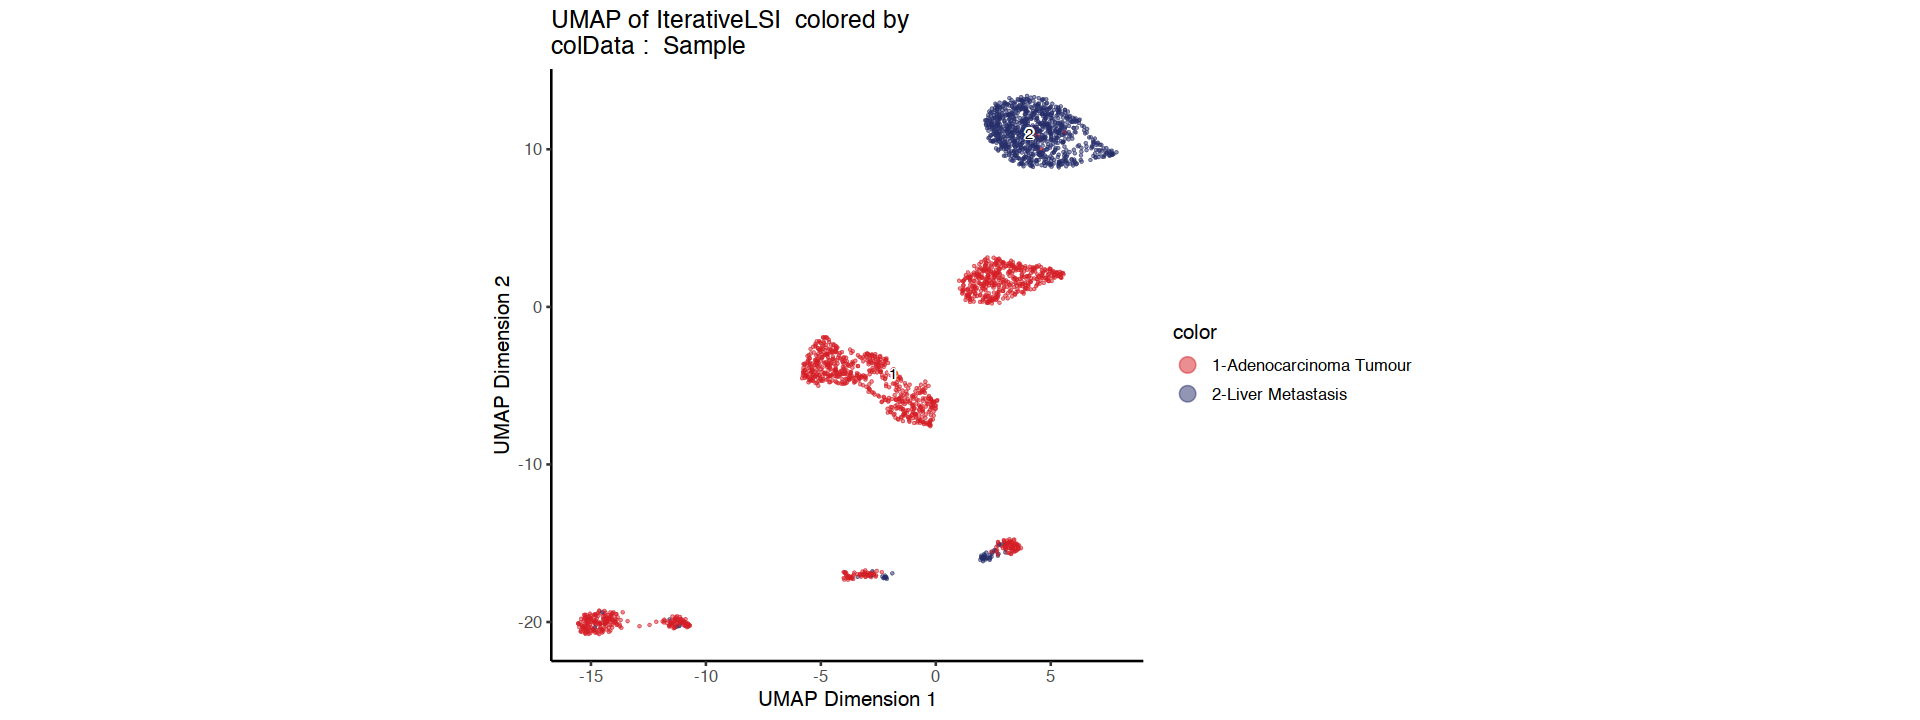

In [41]:
p1

In [43]:
plotPDF(p1,p2, name = "Plot-UMAP-Sample-Clusters_Aggr.pdf",
        ArchRProj = chrisAggrproj, addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!

Plotting Ggplot!



# 3. Assigning Clusters with Gene Scores
We can try to assign biological labels to these clusters using marker genes of known hematopoietic regulators. First, we add imputation weights using [MAGIC](https://github.com/KrishnaswamyLab/MAGIC) to help smooth the dropout noise in our gene scores.



In [44]:
chrisAggrproj <- addImputeWeights(chrisAggrproj)

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-cc16268c29b1-Date-2021-04-08_Time-14-37-40.log
If there is an issue, please report to github with logFile!

2021-04-08 14:37:40 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.



Now we can overlay our marker gene scores on our 2D UMAP embedding.

In [45]:
markerGenes  <- c(
    "SOX10",
"S100B",
"ERBB3",
"NOTCH1",
"NCAM1",
"VIP",
"SLC18A1"
  )

p <- plotEmbedding(
    ArchRProj = chrisAggrproj, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(chrisAggrproj)
)

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-cc164abe2deb-Date-2021-04-08_Time-14-37-51.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2021-04-08 14:37:51 : 



Imputing Matrix

Using weights on disk

1 of 1

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-cc164abe2deb-Date-2021-04-08_Time-14-37-51.log



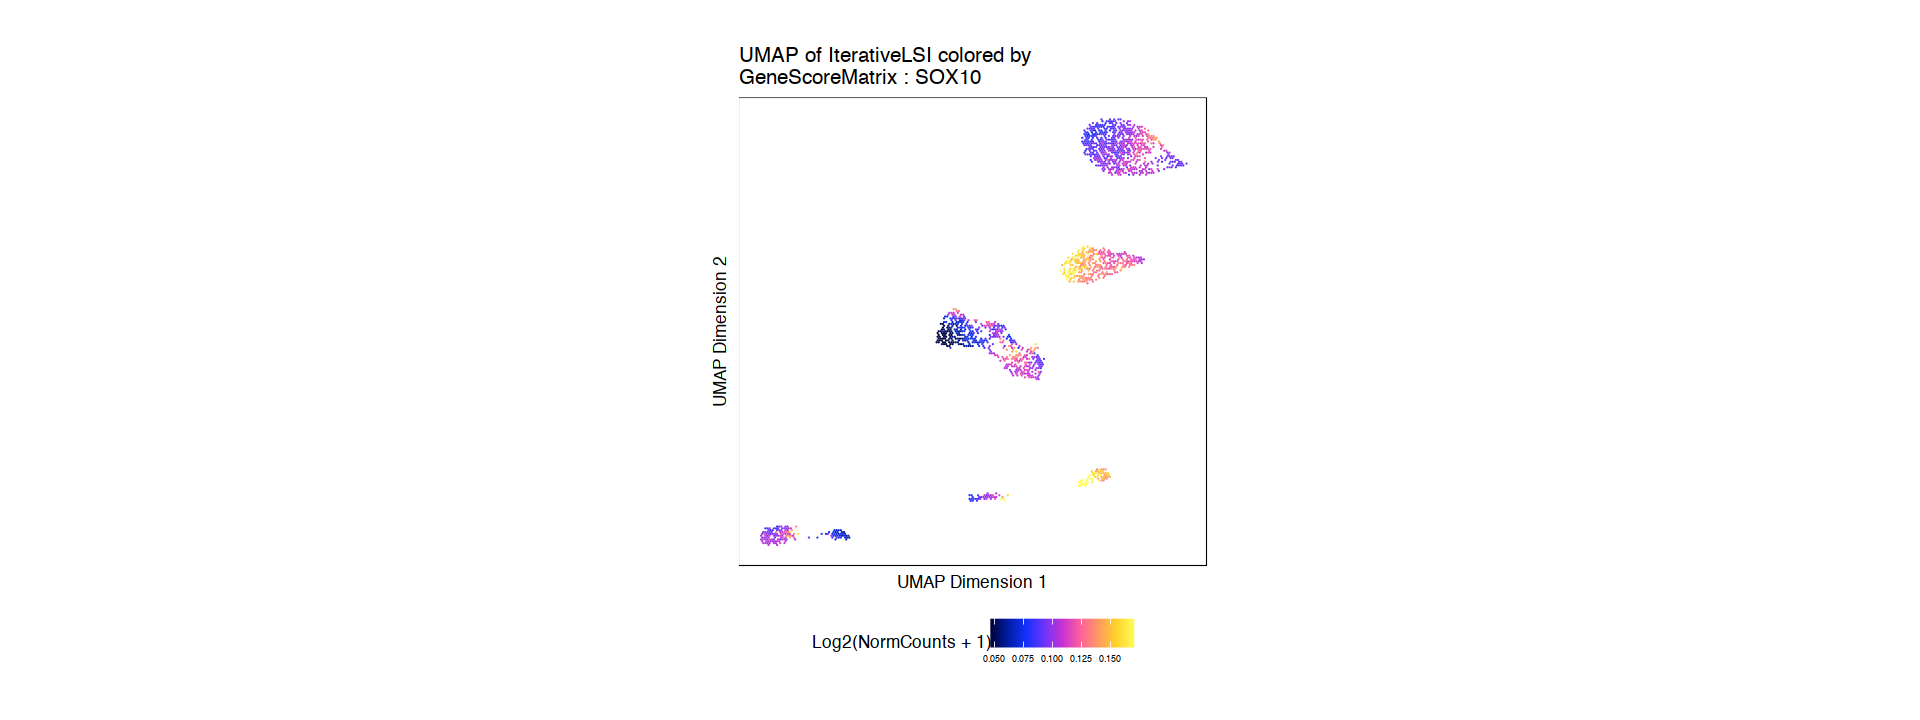

In [46]:
p$SOX10

## 3.1 Visualizing Genome Browser Tracks
In addition to plotting gene scores per cell as a UMAP overlay, we can browse the local chromatin accessibility at these marker genes on a per cluster basis with genome browser tracks. To do this, we use the plotBrowserTrack() function which will create a list of plots, one for each of the genes specified by markerGenes.

In [47]:
p <- plotBrowserTrack(
    ArchRProj = chrisAggrproj, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-cc164e8ea0ac-Date-2021-04-08_Time-14-38-01.log
If there is an issue, please report to github with logFile!

2021-04-08 14:38:01 : Validating Region, 0.002 mins elapsed.



GRanges object with 7 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]    chr22   37970686-37987422      - |        6663       SOX10
  [2]    chr21   46598962-46605208      - |        6285       S100B
  [3]    chr12   56079857-56103505      + |        2065       ERBB3
  [4]     chr9 136494444-136545862      - |        4851      NOTCH1
  [5]    chr11 112961247-113278436      + |        4684       NCAM1
  [6]     chr6 152750798-152759765      + |        7432         VIP
  [7]     chr8   20144855-20183206      - |        6570     SLC18A1
  -------
  seqinfo: 24 sequences from hg38 genome


2021-04-08 14:38:01 : Adding Bulk Tracks (1 of 7), 0.003 mins elapsed.

2021-04-08 14:38:01 : Adding Gene Tracks (1 of 7), 0.011 mins elapsed.

2021-04-08 14:38:02 : Plotting, 0.016 mins elapsed.

2021-04-08 14:38:03 : Adding Bulk Tracks (2 of 7), 0.042 mins elapsed.

2021-04-08 14:38:04 : Adding Gene Tracks (2 of 7), 0.049 mins elapsed.

2021-04-08 14:38:04 : Plotting, 0.054 mins elapsed.

2021-04-08 14:38:05 : Adding Bulk Tracks (3 of 7), 0.075 mins elapsed.

2021-04-08 14:38:06 : Adding Gene Tracks (3 of 7), 0.086 mins elapsed.

2021-04-08 14:38:06 : Plotting, 0.09 mins elapsed.

2021-04-08 14:38:08 : Adding Bulk Tracks (4 of 7), 0.117 mins elapsed.

2021-04-08 14:38:08 : Adding Gene Tracks (4 of 7), 0.129 mins elapsed.

2021-04-08 14:38:09 : Plotting, 0.133 mins elapsed.

2021-04-08 14:38:10 : Adding Bulk Tracks (5 of 7), 0.162 mins elapsed.

2021-04-08 14:38:11 : Adding Gene Tracks (5 of 7), 0.176 mins elapsed.

2021-04-08 14:38:11 : Plotting, 0.18 mins elapsed.

2021-04-08 14:38:

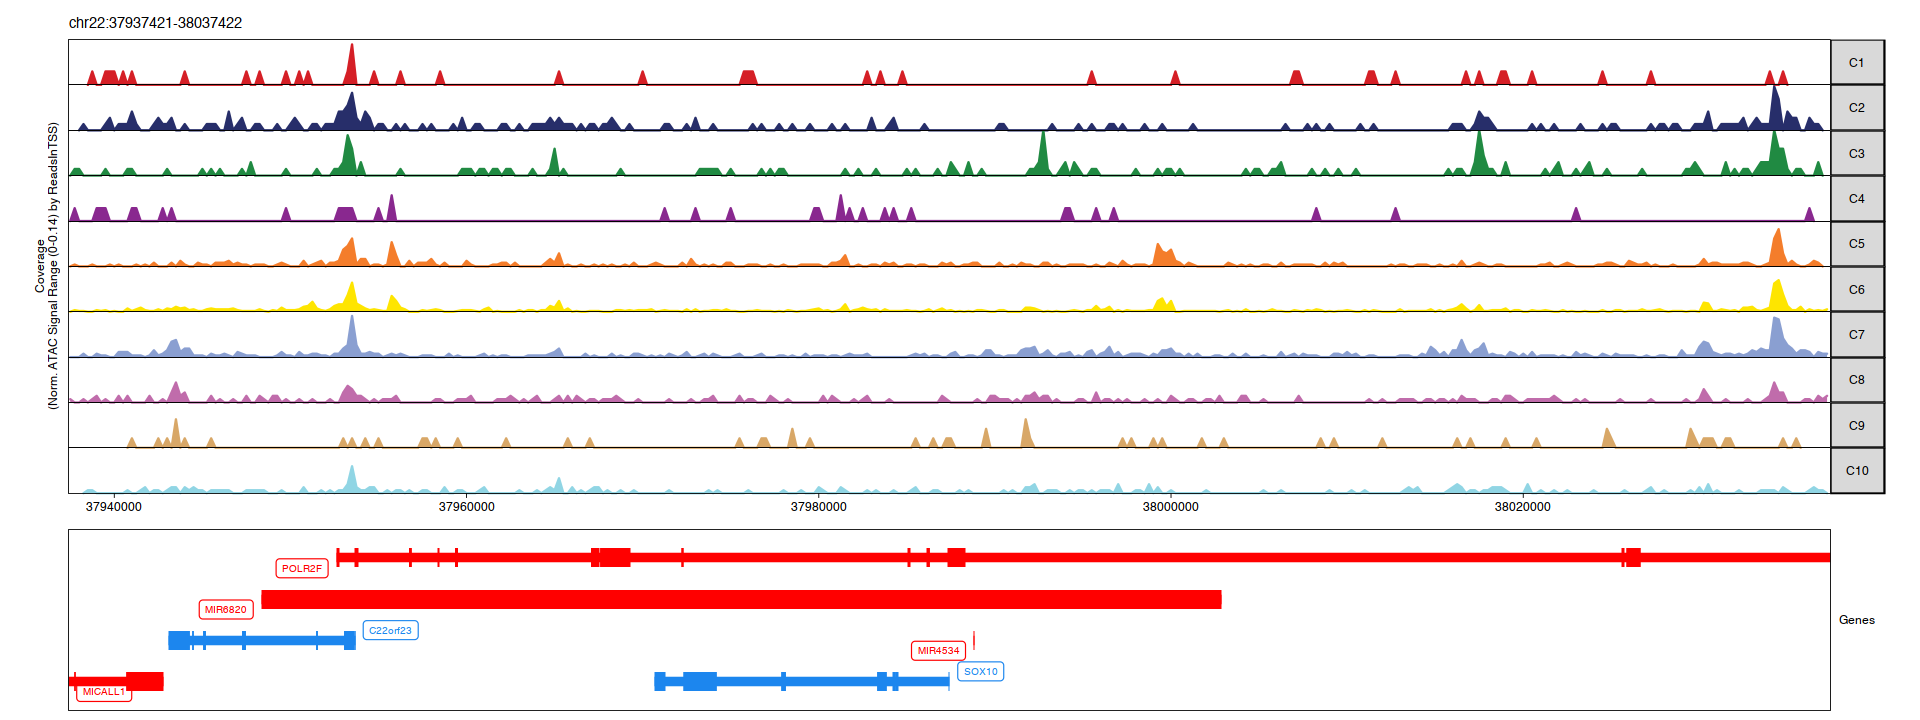

In [48]:
grid::grid.draw(p$SOX10)

In [49]:
geneName = 'NOTCH1'
p_gene <- plotBrowserTrack(
    ArchRProj = chrisAggrproj, 
    groupBy = "Clusters", 
    geneSymbol = geneName, 
    upstream = 50000,
    downstream = 50000
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-cc1655f632a5-Date-2021-04-08_Time-14-38-19.log
If there is an issue, please report to github with logFile!

2021-04-08 14:38:19 : Validating Region, 0.002 mins elapsed.



GRanges object with 1 range and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]     chr9 136494444-136545862      - |        4851      NOTCH1
  -------
  seqinfo: 24 sequences from hg38 genome


2021-04-08 14:38:19 : Adding Bulk Tracks (1 of 1), 0.003 mins elapsed.

2021-04-08 14:38:20 : Adding Gene Tracks (1 of 1), 0.014 mins elapsed.

2021-04-08 14:38:20 : Plotting, 0.019 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-cc1655f632a5-Date-2021-04-08_Time-14-38-19.log



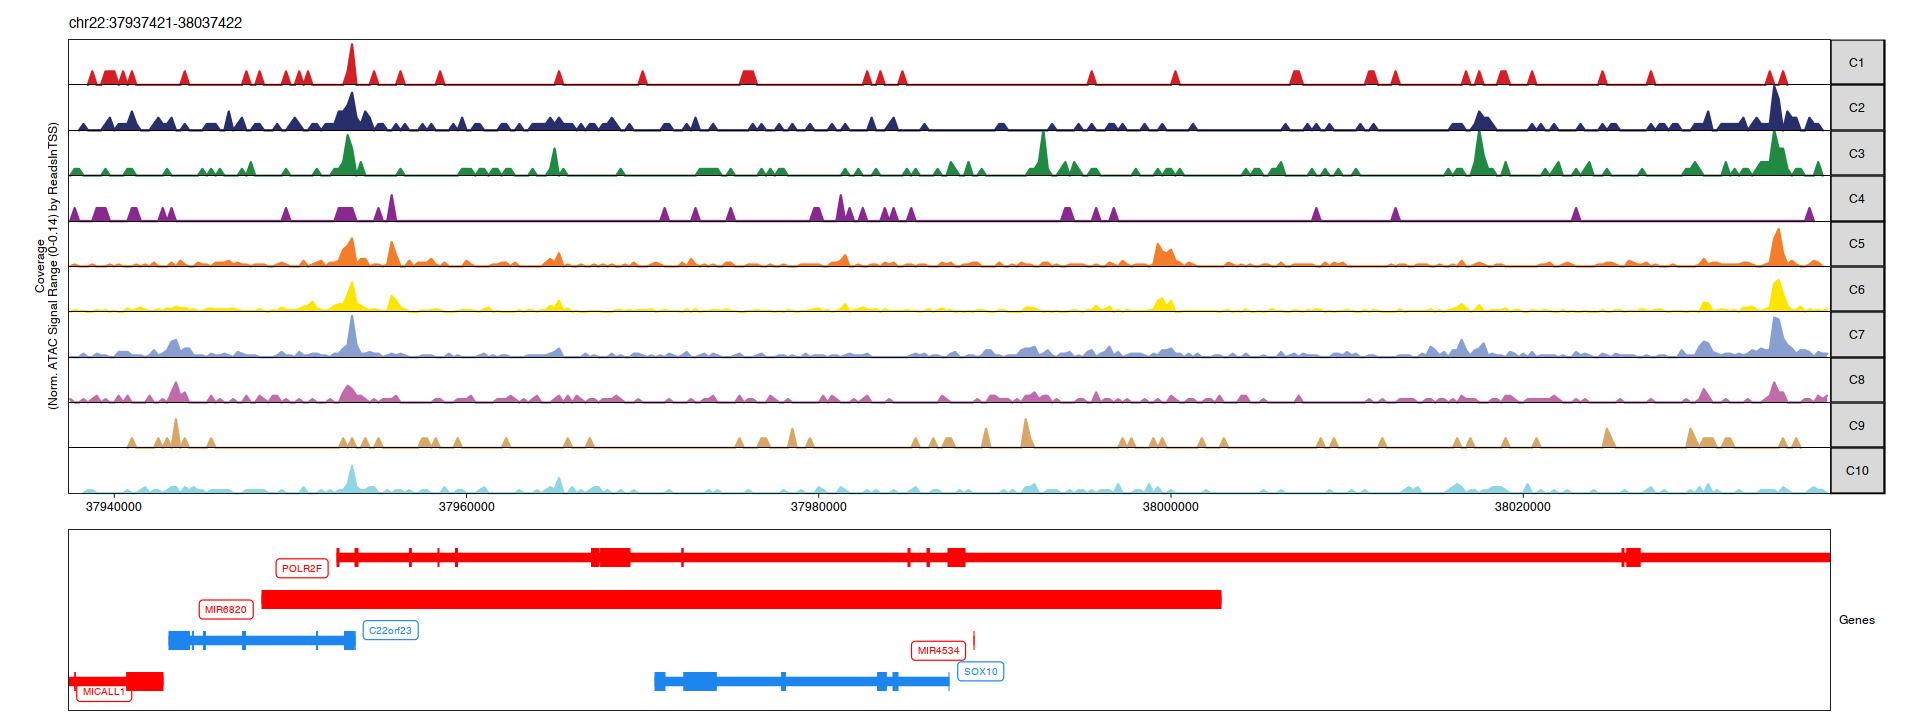

In [50]:
grid::grid.draw(p$SOX10)

## 3.2 Identifying marker genes with GeneScoreMatrix

In addition to using prior knowledge of relevant marker genes for annotation of clusters, ArchR enables unbiased identification of marker features for any given cell groupings (for example, clusters). These features can be anything - peaks, genes (based on gene scores), or transcription factor motifs (based on chromVAR deviations). ArchR does this using the `getMarkerFeatures()` function which can take as input any matrix via the `useMatrix` parameter and it identifies features unique to the groups indicated by the `groupBy` parameter. If the `useMatrix` parameter is set to “GeneScoreMatrix”, then the function will identify the genes that appear to be uniquely active in each cell type. This provides an unbiased way of seeing which genes are predicted to be active in each cluster and can aid in cluster annotation.

As mentioned above, the same `getMarkerFeatures()` function can be used with any matrix stored in the Arrow files to identify features that are specific to certain cell groups. This is accomplished via the useMatrix parameter. For example, `useMatrix = "TileMatrix"` would identify genomic regions that are highly specific to a certain cell group and `useMatrix = "PeakMatrix"` would identify peaks that are highly specific to a certain cell group. Examples of how to use the `getMarkerFeatures()` function on other feature types are provided in later chapters.

#### How does marker feature identification happen?

This process of marker feature identification hinges on the selection of a group of bias-matched background cells for each cell group. Across all features, each cell group is compared to its own background group of cells to determine if the given cell group has significantly higher accessibility.

<img src="documentFigures/markerFeature_schematic.png" width="40%">

The selection of these background cell groups is critical to the success of this process and is performed across the multi-dimensional space provided by the user via the bias argument to `getMarkerFeatures()`. For each cell in the cell group, `ArchR` finds the nearest neighbor cell across the provided multi-dimensional space that is not a member of the given cell group and adds it to the background group of cells. In this way, `ArchR` creates a group of bias-matched cells that is as similar as possible to the given cell group, thus enabling a more robust determination of significance even if the group of cells is small.

The way ArchR does this is by taking all of the dimensions provided via the bias parameter and quantile normalizing their values to distribute the variance of each dimension across the same relative scale.


To identify marker genes based on gene scores, we call the `getMarkerFeatures()` function with `useMatrix = "GeneScoreMatrix"`. We specify that we want to know the cluster-specific features with `groupBy = "Clusters"` which tells ArchR to use the `“Clusters”` column in `cellColData` to stratify cell groups.


In [51]:
markersGS <- getMarkerFeatures(
    ArchRProj = chrisAggrproj, 
    useMatrix = "GeneScoreMatrix", 
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon",
    verbose = FALSE
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-cc165099876f-Date-2021-04-08_Time-14-38-22.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Double.Matrix

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-cc165099876f-Date-2021-04-08_Time-14-38-22.log



This function returns a `SummarizedExperiment` object containing relevant information on the marker features identified. This type of return value is common in ArchR and is one of the key ways that ArchR enables downstream data analysis. `SummarizedExperiment` objects are similar to a matrix where rows represent features of interest (i.e. genes) and columns represent samples. A `SummarizedExperiment` object contains one or more assays, each represented by a matrix-like object of numeric data, and metadata that applies to the rows or columns of the assays matrices. It is beyond the scope of this tutorial to dive into `SummarizedExperiment` objects but check out the bioconductor page if you need more information.

We can get a list of DataFrame objects, one for each of our clusters, containing the relevant marker features using the `getMarkers()` function:

In [52]:
markersGS

class: SummarizedExperiment 
dim: 24919 10 
metadata(2): MatchInfo Params
assays(7): Log2FC Mean ... AUC MeanBGD
rownames(24919): 1 2 ... 24918 24919
rowData names(6): seqnames start ... name idx
colnames(10): C1 C2 ... C9 C10
colData names(0):

In [114]:
markerList <- getMarkers(markersGS, cutOff = "FDR <= 0.01 & Log2FC >= 0.25")
markerList$C6

DataFrame with 6967 rows and 9 columns
      seqnames     start       end  strand         name     idx    Log2FC
         <Rle>   <array>   <array> <array>      <array> <array> <numeric>
10106    chr17  39626740  39636626       1      PPP1R1B     620   1.88486
10109    chr17  39667981  39670475       1         PNMT     623   1.83395
11991    chr19  29715789  29698886       2     C19orf12     695   1.73651
10107    chr17  39637065  39663484       1       STARD3     621   1.76016
10108    chr17  39664187  39666555       1         TCAP     622   1.79319
...        ...       ...       ...     ...          ...     ...       ...
1460      chr1 152613811 152614098       1        LCE3B    1460  1.108904
19552     chr5 176119545 176132258       1 LOC100507387    1059  0.339598
18224     chr4 122922968 122892575       2        NUDT6     690  0.344769
10746    chr17  76071961  76082804       1         ZACN    1260  0.430636
8337     chr15  82809628  82836108       1        WHAMM     669  0.261098

In [115]:
for(i in c(1:max(length(names(markerList))))){
    write.table(markerList[[i]], file=paste0("snATAC_Aggr_geneScore_Upregulated_LFC_0.25_Cluster",i,".tsv"), sep="\t", quote=FALSE, col.names=NA)
}

# 4. snRNA-seq & snATAC-seq Integrated Analysis

In addition to allowing cluster identity assignment with gene scores, ArchR also enables integration with scRNA-seq. This can help with cluster identity assignment because you can directly use clusters called in scRNA-seq space or use the gene expression measurements after integration. The way this integration works is by directly aligning cells from scATAC-seq with cells from scRNA-seq by comparing the scATAC-seq gene score matrix with the scRNA-seq gene expression matrix. Under the hood, this alignment is performed using the `FindTransferAnchors()` function from the `Seurat` package which allows you to align data across two datasets. However, to appropriately scale this procedure for hundreds of thousands of cells ArchR provides a parallelization of this procedure by dividing the total cells into smaller groups of cells and performing separate alignments.

<img src="documentFigures/ArchR_scRNA_Integration.png" width="40%">

Effectively, for each cell in the scATAC-seq data, this integration process finds the cell in the scRNA-seq data that looks most similar and assigns the gene expression data from that scRNA-seq cell to the scATAC-seq cell. At the end, each cell in scATAC-seq space has been assigned a gene expression signature which can be used for many downstream analyses.

There are two types of integration approaches that we can perform. **Unconstrained integration** is a completely agnostic approach that would take all of the cells in your scATAC-seq experiment and attempt to align them to any of the cells in the scRNA-seq experiment. While this is a feasible preliminary solution, we can improve the quality of our cross-platform alignment by constraining the integration process. To perform a **constrained integration** we use prior knowledge of the cell types to limit the search space of the alignment. For example, if we knew that Clusters A, B, and C in the scATAC-seq data corresponded to 3 different T cell clusters, and we knew that Clusters X and Y in the scRNA-seq data corresponded to 2 different T cell clusters, we could tell ArchR to specifically try to align cells from scATAC-seq Clusters A, B, and C to cell from scRNA-seq clusters X and Y. We illustrate these two approaches below, first performing an unconstrained integration to acheive preliminary cluster identities and then using this prior knowledge to perform a more refined constrained integration.

## 4.1 Unconstrained Integration (Didn't implement this part as the snRNA-seq is not there yet)

To integrate scATAC-seq with scRNA-seq, we use the `addGeneIntegrationMatrix()` function. As mentioned above, this function accepts either a `Seurat` object or a `RangedSummarizedExperiment` object via the `seRNA` parameter. The first round of integration we perform will be a preliminary `unconstrained` integration. We provide a name for the integration matrix that will be stored in the `ArchRProject` via the `matrixName` parameter. The other key parameters for this function provide column names in `cellColData` where certain information will be stored: `nameCell` will store the cell ID from the matched scRNA-seq cell, `nameGroup` will store the group ID from the scRNA-seq cell, and `nameScore` will store the cross-platform integration score.

First we generate the `Seurat` object from our `Scater` object

In [ ]:
cdScFiltAnnot <- loadHDF5SummarizedExperiment(dir="/Users/mqbsxsm2/RNA-seq_Analysis/Aoibheann_Mullan_All_Esophagus_Analysis/snRNA-seq_7W/cdScFiltAnnotHDF5", prefix="")

In [50]:
rownames(cdScFiltAnnot) <- make.names(rownames(cdScFiltAnnot), unique=TRUE)

In [51]:
counts(cdScFiltAnnot) <- as.matrix(counts(cdScFiltAnnot))
logcounts(cdScFiltAnnot) <- as.matrix(logcounts(cdScFiltAnnot))

In [ ]:
cdScFiltAnnot_seurat <- as.Seurat(cdScFiltAnnot, counts = "counts", data = "logcounts")

In [53]:
hvg.RNA <- read.table('/Users/mqbsxsm2/RNA-seq_Analysis/Aoibheann_Mullan_All_Esophagus_Analysis/snRNA-seq_7W/HVG.xls')

In [ ]:
VariableFeatures(cdScFiltAnnot_seurat) <- rownames(hvg.RNA)

In [ ]:
aoibAggrproj <- addGeneIntegrationMatrix(
    ArchRProj = aoibAggrproj, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "IterativeLSI",
    seRNA = cdScFiltAnnot_seurat, # The Seurat object 
    addToArrow = TRUE,
    groupRNA = "Clusters", # colData for subgrouping
    nameCell = "predictedCell_Un",
    nameGroup = "predictedGroup_Un",
    nameScore = "predictedScore_Un",
    force = TRUE,
    plotUMAP = TRUE,
    verbose = FALSE
)

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)
plot1 <- Seurat::DimPlot(
  object = cdScFiltAnnot_seurat,
  group.by = 'Clusters',
  label = TRUE,
  repel = TRUE, 
    pt.size=0.2, 
    label.size = 6) +  ggtitle('scRNA-seq') + scale_colour_manual(values = c_clust_col)
plot1

In [ ]:
plot2 <- plotEmbedding(
    aoibAggrproj, 
    colorBy = "cellColData", 
    name = "predictedGroup_Un", 
    #name = "Clusters",
    pal = c_clust_col,
    size=1.5,
    plot = "points"
) + 
    theme_classic(base_size=12) + 
    guides(colour = guide_legend(override.aes = list(size=4))) 
plot2

In [ ]:
options(repr.plot.width=10, repr.plot.height=6)
plot1 + plot2

In [ ]:
table(ArchR::getCellColData(aoibAggrproj)$predictedGroup_Un)

In [ ]:
pdf('aoibAggrArchR/Plots/snRNA_snATAC_integrated.pdf')
plot1 + plot2
dev.off()

In [ ]:
getAvailableMatrices(aoibAggrproj)

we add impute weights to our project:

In [ ]:
aoibAggrproj <- addImputeWeights(aoibAggrproj)

In [ ]:
markerGenes  <- c(
    "GATA6", #Early Progenitor
    #"GATA1", #Erythroid
    "PPFIA3", #B-Cell Trajectory
    "CAV1" #Monocytes
    #"MAS1" #TCells
  )

p1 <- plotEmbedding(
    ArchRProj = aoibAggrproj, 
    colorBy = "GeneIntegrationMatrix", 
    name = markerGenes, 
    continuousSet = "horizonExtra",
    embedding = "UMAP"
    #imputeWeights = getImputeWeights(aoibAggrproj)
)


p2 <- plotEmbedding(
    ArchRProj = aoibAggrproj, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    continuousSet = "horizonExtra",
    embedding = "UMAP"
    #imputeWeights = getImputeWeights(aoibAggrproj)
)

In [ ]:
options(repr.plot.width=14, repr.plot.height=6)
p1c <- lapply(p1, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 12) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})

p2c <- lapply(p2, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 12) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})

do.call(cowplot::plot_grid, c(list(ncol = 3), p1c))
do.call(cowplot::plot_grid, c(list(ncol = 3), p2c))

In [ ]:
pdf('aoibAggrArchR/Plots/geneExpression.pdf')
do.call(cowplot::plot_grid, c(list(ncol = 3), p1c))
do.call(cowplot::plot_grid, c(list(ncol = 3), p2c))
dev.off()

In [ ]:
table(aoibAggrproj$predictedGroup_Un)

# 5. Calling Peaks with ArchR

Calling peaks is one of the most fundamental processes in ATAC-seq data analysis. Because per-cell scATAC-seq data is essentially binary (accessible or not accessible), we cannot call peaks on an individual cell basis. For this reason, we defined groups of cells, typically clusters, in a previous chapter. Moreover, we created pseudo-bulk replicates to allow us to assess the reproducibility of our peak calls.

We first introduced a strategy for [iterative overlap peak merging in 2018](https://science.sciencemag.org/content/362/6413/eaav1898). Other peak merging strategies suffer from a few key issues that we outline below.

### Fixed-width vs Variable-width Peaks

We use 501-bp fixed-width peaks because they make downstream computation easier as peak length does not need to be normalized. Moreover, the vast majority of peaks in ATAC-seq are less than 501-bp wide. Using variable-width peaks also makes it difficult to merge peak calls from multiple samples. In general, we do not feel that the potential benefit derived from using variable-width peaks outweighs the costs. More broadly, most analyses are stable with respect to the peak set or peak style used.


### Iterative Overlap In ArchR

Iterative overlap removal avoids the issues mentioned above. Peaks are first ranked by their significance. The most significant peak is retained and any peak that directly overlaps with the most significant peak is removed from further analysis. Then, of the remaining peaks, this process is repeated until no more peaks exist. This avoids daisy-chaining and still allows for use of fixed-width peaks.

<img src='documentFigures/peakCalling_IterativeOverlap.png' width='40%'>


As mentioned above, we generate a reproducible peak set in ArchR using the `addReproduciblePeakSet()` function. By default ArchR attempts to call peaks using `MACS2`; however, ArchR also implements its own native peak caller which could be used when `MACS2` cannot be installed (for example, we have not successfully installed `MACS2` on Windows) - this alternative peak calling method is described in the next section.

To call peaks using `MACS2`, ArchR must be able to find the `MACS2` executable. First, ArchR looks in your PATH environment variable. If this is unsuccessful, ArchR attempts to determine if you have installed MACS2 with either `pip` or `pip3`. If neither of these is successful, ArchR gives up and provides an error message. If you have MACS2 installed and ArchR cannot find it, you should provide the path to the `addReproduciblePeakSet()` function via the `pathToMacs2` parameter.

With the path to `MACS2` identified, we can then create a reproducible merged peak set w/ MACS2 (~5-10 minutes). To avoid bias from pseudo-bulk replicates that have very few cells, we can provide a cutoff for the upper limit of the number of peaks called per cell via the `peaksPerCell` parameter. This prevents clusters with very few cells from contributing lots of low quality peaks to the merged peak set. There are many other parameters that can be tweaked in `addReproduciblePeakSet()`.

Each `ArchRProject` object can only contain a **single peak set**. As such, we assign the output of `addReproduciblePeakSet()` to our desired `ArchRProject`. If you would like to experiment with different peak sets, you must save a copy of your ArchRProject and thus also copy the Arrow files. While this does use more on-disk storage space, this is unavoidable given the structure of Arrow files and the storage of peak matrix information in the Arrow files.

In [55]:
pathToMacs2 <- findMacs2()

Searching For MACS2..

Found with $path!



In [57]:
chrisAggrproj <- addGroupCoverages(chrisAggrproj, groupBy = "Clusters", verbose=FALSE)

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-cc161c98ae5f-Date-2021-04-08_Time-15-38-33.log
If there is an issue, please report to github with logFile!

C1 (1 of 10) : CellGroups N = 2

C2 (2 of 10) : CellGroups N = 2

C3 (3 of 10) : CellGroups N = 2

C4 (4 of 10) : CellGroups N = 2

C5 (5 of 10) : CellGroups N = 2

C6 (6 of 10) : CellGroups N = 2

C7 (7 of 10) : CellGroups N = 2

C8 (8 of 10) : CellGroups N = 2

C9 (9 of 10) : CellGroups N = 2

C10 (10 of 10) : CellGroups N = 2

2021-04-08 15:38:34 : Further Sampled 1 Groups above the Max Fragments!, 0.011 mins elapsed.

2021-04-08 15:38:34 : Creating Coverage Files!, 0.015 mins elapsed.

2021-04-08 15:38:34 : Batch Execution w/ safelapply!, 0.016 mins elapsed.

2021-04-08 15:42:39 : Adding Kmer Bias to Coverage Files!, 4.105 mins elapsed.

Completed Kmer Bias Calculation

Adding Kmer Bias (1 of 20)

Adding Kmer Bias (2 of 20)

Adding Kmer Bias (3 of 20)

Adding Kmer Bias (4 of 20)

Adding Kmer Bias (5 of 20)

Adding Kmer Bias

In [58]:
chrisAggrproj <- addReproduciblePeakSet(
    ArchRProj = chrisAggrproj, 
    groupBy = "Clusters", # We are calling with clusters defined by tiles, 
                           # but can be called with Cluster2 which is the cluster from snRNA-seq
    peakMethod = "Macs2",
    pathToMacs2 = pathToMacs2
)

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-cc162d83d030-Date-2021-04-08_Time-15-46-38.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2021-04-08 15:46:38 : Peak Calling Parameters!, 0.002 mins elapsed.



    Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
C1     C1     72         63           2   40   40    31500
C2     C2    171        171           2   40  131    85500
C3     C3    111        111           2   40   71    55500
C4     C4     70         63           2   40   40    31500
C5     C5    387        387           2   40  347   150000
C6     C6    495        495           2   40  455   150000
C7     C7    424        424           2   40  384   150000
C8     C8    208        208           2   40  168   104000
C9     C9     97         97           2   40   57    48500
C10   C10    300        300           2   40  260   150000


2021-04-08 15:46:38 : Batching Peak Calls!, 0.002 mins elapsed.

2021-04-08 15:46:38 : Batch Execution w/ safelapply!, 0 mins elapsed.

2021-04-08 16:03:51 : Identifying Reproducible Peaks!, 17.219 mins elapsed.

2021-04-08 16:04:18 : Creating Union Peak Set!, 17.663 mins elapsed.

Converged after 8 iterations!

Plotting Ggplot!

2021-04-08 16:04:23 : Finished Creating Union Peak Set (249908)!, 17.75 mins elapsed.



In [59]:
chrisAggrproj <- addPeakMatrix(chrisAggrproj, verbose=FALSE)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-cc1660f8fb64-Date-2021-04-08_Time-16-04-23.log
If there is an issue, please report to github with logFile!

2021-04-08 16:04:23 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addPeakMatrix-cc1660f8fb64-Date-2021-04-08_Time-16-04-23.log



In [60]:
getAvailableMatrices(chrisAggrproj)

[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

We save the projects with the peak

In [61]:
saveArchRProject(ArchRProj = chrisAggrproj, outputDirectory = "chrisAggrproj", load = FALSE)

Saving ArchRProject...



## 5.2 Identifying Marker Peaks with ArchR

We have introduced the identification of marker features previously in the chapter discussing gene scores. The same function (`getMarkerFeatures()`) can be used to identify marker features from any matrix stored in an `ArchRProject`. Marker features are features that are unique to a specific cell grouping. These can be very useful in understanding cluster- or cell type-specific biology. 

### Identifying Marker Peaks with ArchR

Often times, we are interested to know which peaks are unique to an individual cluster or a small group of clusters. We can do this in an unsupervised fashion in ArchR using the `addMarkerFeatures()` function in combination with `useMatrix = "PeakMatrix"`.


In [23]:
markersPeaks <- getMarkerFeatures(
    ArchRProj = chrisAggrproj, 
    useMatrix = "PeakMatrix", 
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon",
    verbose = FALSE
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-143023d3a3bac-Date-2021-05-01_Time-13-00-32.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Integer.Matrix

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-143023d3a3bac-Date-2021-05-01_Time-13-00-32.log



In [24]:
markerPeakList <- getMarkers(markersPeaks, cutOff = "FDR <= 0.01 & Log2FC >= 0.25")
markerPeakList

List of length 10
names(10): C1 C2 C3 C4 C5 C6 C7 C8 C9 C10

In [117]:
for(i in c(1:max(length(names(markerPeakList))))){
    write.table(markerPeakList[[i]], file=paste0("chrisAggrproj_snATAC_Aggr_Peak_Upregulated_LFC_0.25_Cluster",i,".tsv"), sep="\t", quote=FALSE, col.names=NA)
}

In [122]:
heatmapPeaks <- plotMarkerHeatmap(
  seMarker = markersPeaks, 
  #cutOff = "FDR <= 0.1 & Log2FC >= 0.25",
    cutOff = "FDR <= 0.1",
    #labelMarkers = rownames(markersPeaks),
  transpose = TRUE
)

ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-cc16573e6d43-Date-2021-04-09_Time-19-00-40.log
If there is an issue, please report to github with logFile!

Identified 133018 markers!

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-cc16573e6d43-Date-2021-04-09_Time-19-00-40.log



In [77]:
draw(heatmapPeaks, heatmap_legend_side = "bot", annotation_legend_side = "bot")

Warning message in (function (filename = "Rplot%03d.png", width = 480, height = 480, :
“cairo error 'invalid value (typically too big) for the size of the input (surface, pattern, etc.)'”


ERROR: Error in (function (filename = "Rplot%03d.png", width = 480, height = 480, : unable to start device 'png'


Warning message:
“Removed 118 rows containing missing values (geom_point_rast).”


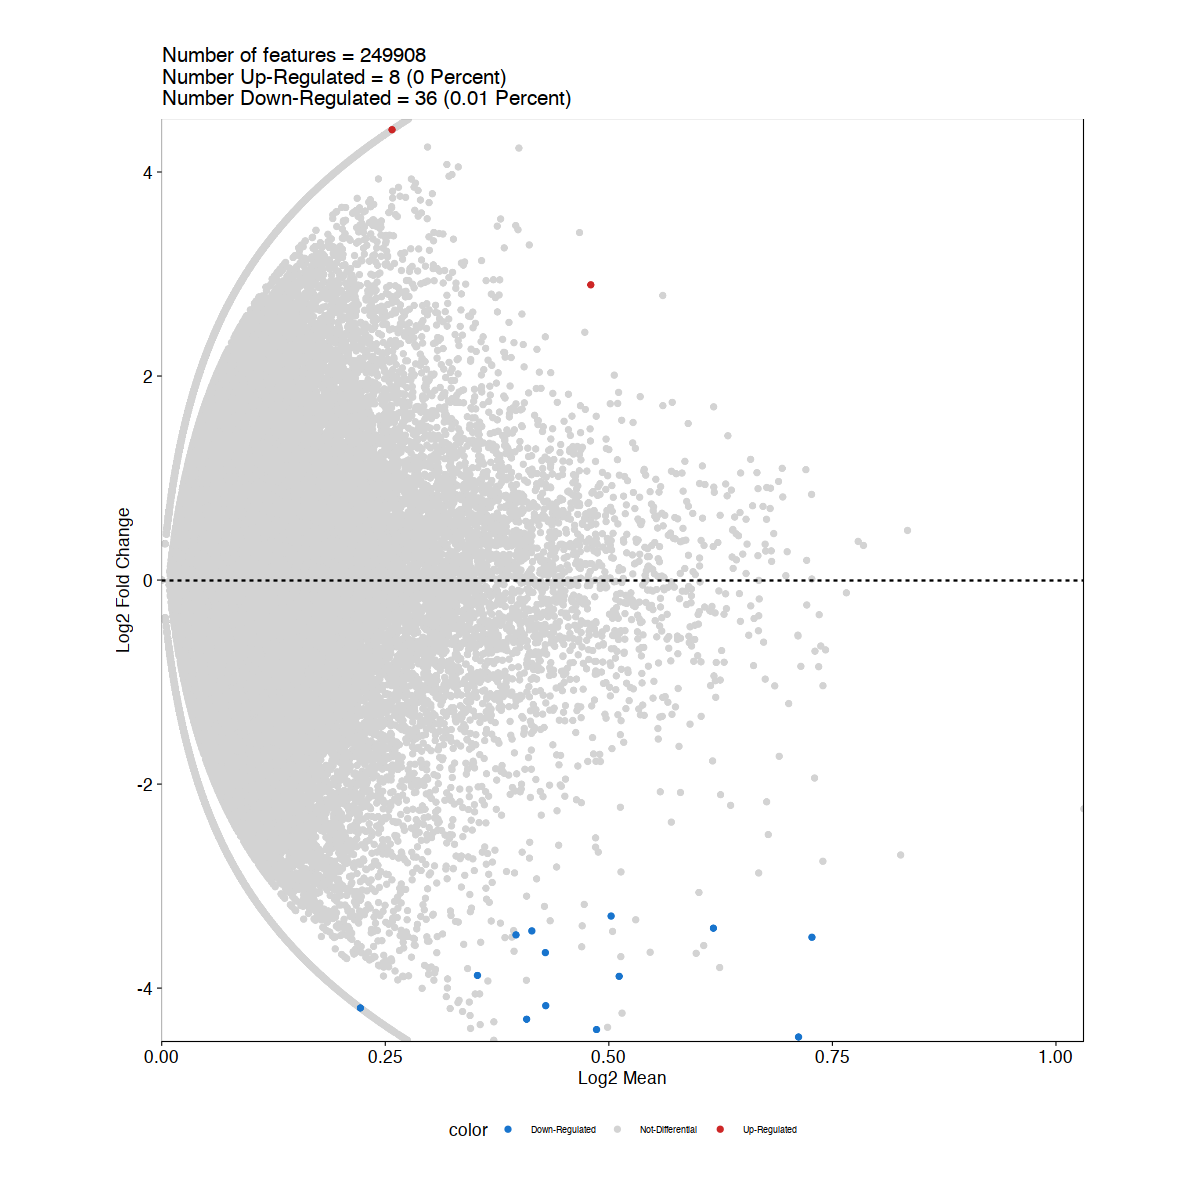

In [123]:
pma <- plotMarkers(seMarker = markersPeaks, name = "C1", cutOff = "FDR <= 0.1", plotAs = "MA")
pma

Warning message:
“Removed 118 rows containing missing values (geom_point_rast).”


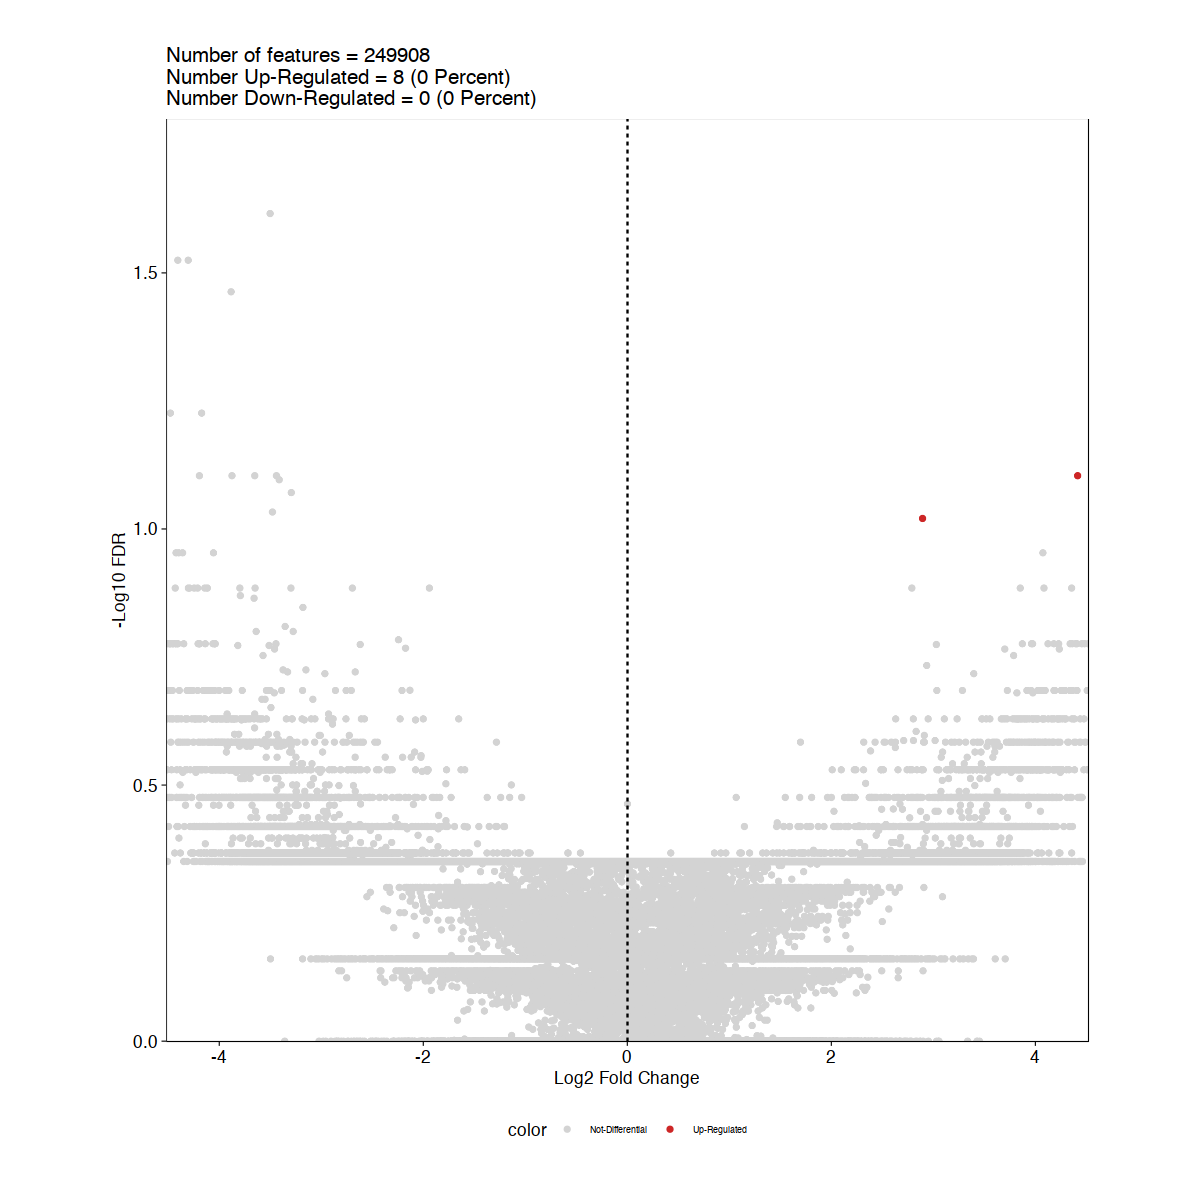

In [124]:
pv <- plotMarkers(seMarker = markersPeaks, name = "C1", cutOff = "FDR <= 0.1 & Log2FC >= 0.25", plotAs = "Volcano")
pv

In [70]:
makerPeakAndy <- c('ELF3','HNF4G','FOXA1','FOXM1','GATA6','HNF1B','HNF4A','HNF4G','KLF5')

In [71]:
p2_Andy <- plotEmbedding(
    ArchRProj = chrisAggrproj, 
    colorBy = "GeneScoreMatrix", 
    name = makerPeakAndy, 
    continuousSet = "horizonExtra",
    embedding = "UMAP",
    baseSize = 6
    #imputeWeights = getImputeWeights(aoibAggrproj)
)

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-cc16624254c5-Date-2021-04-08_Time-16-10-55.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2021-04-08 16:10:55 : 



Imputing Matrix

Using weights on disk

1 of 1

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 
8 
9 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-cc16624254c5-Date-2021-04-08_Time-16-10-55.log



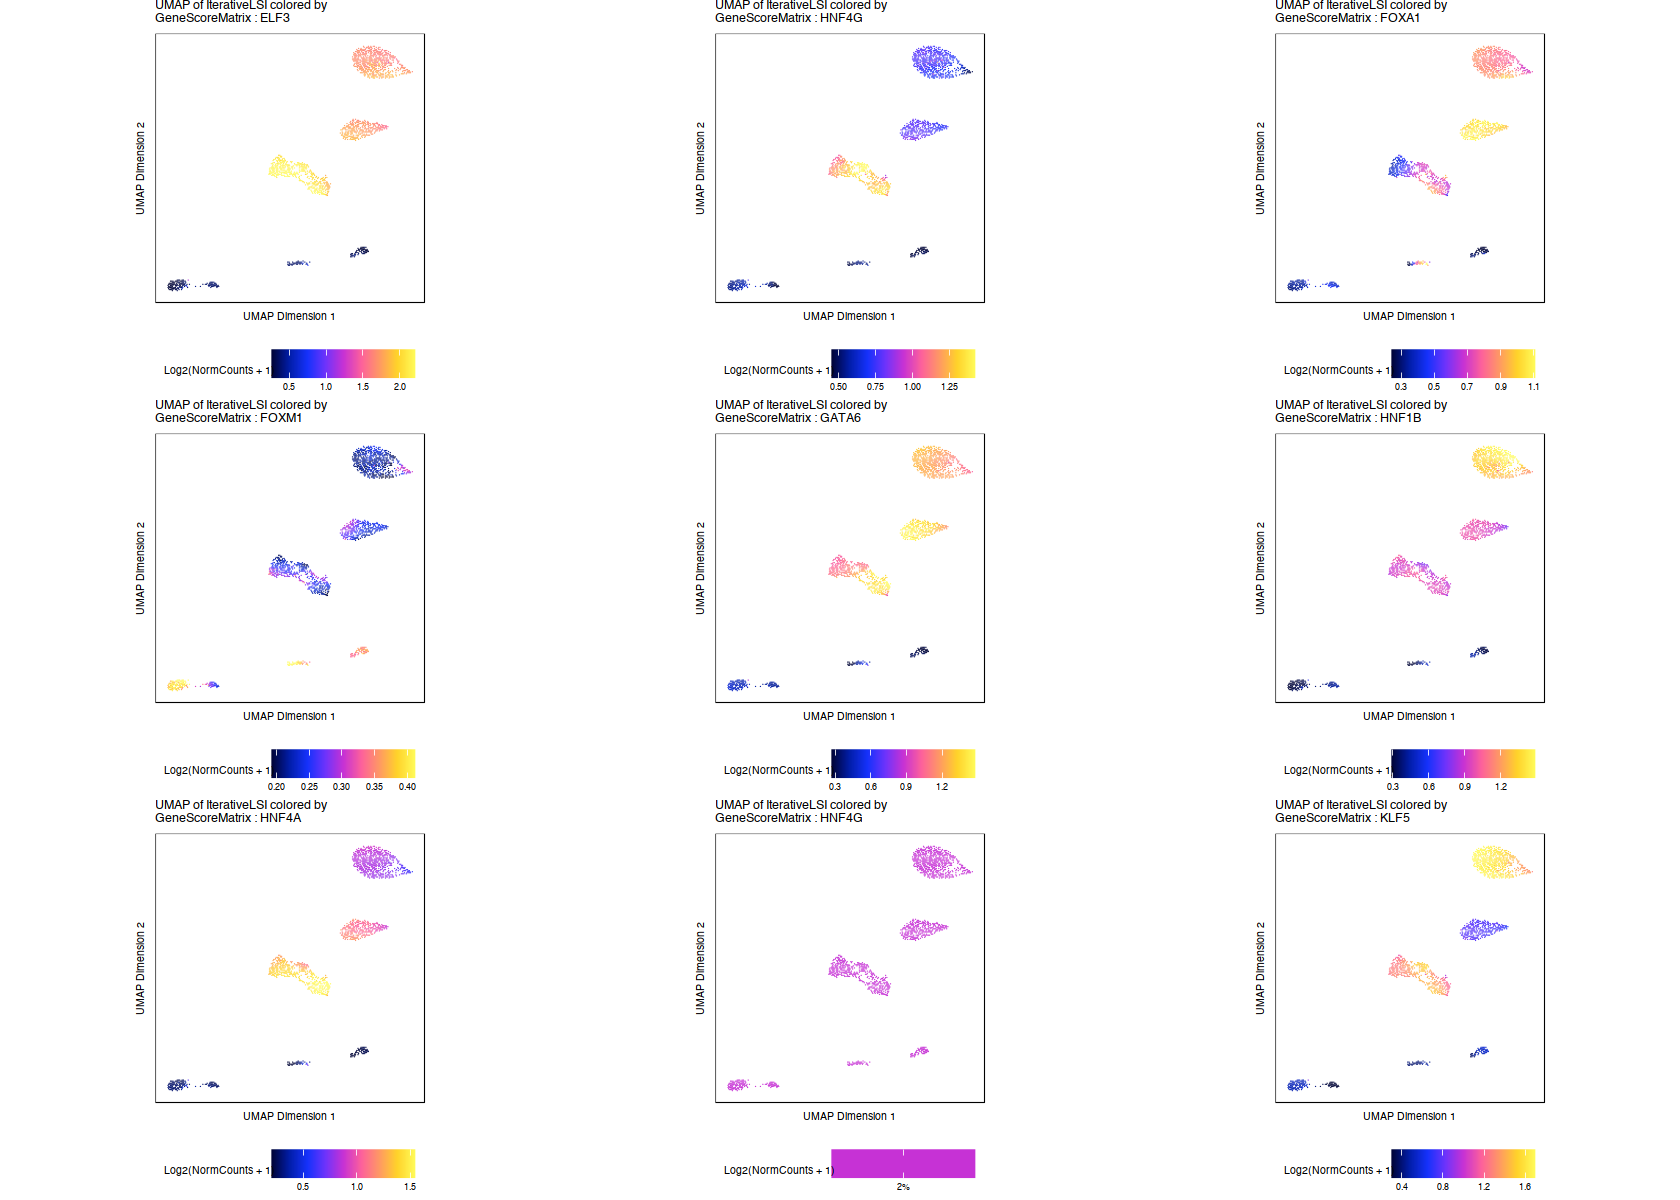

In [72]:
options(repr.plot.width=14, repr.plot.height=10)


p2c_Andy <- lapply(p2_Andy, function(x){
    x + 
    #guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})

#do.call(cowplot::plot_grid, c(list(ncol = 3), p1c))
do.call(cowplot::plot_grid, c(list(ncol = 3), p2c_Andy))

In [73]:
pdf('TF_plots.pdf')
do.call(cowplot::plot_grid, c(list(ncol = 3), p2c_Andy))
dev.off()

pdf 
  2

In [74]:
p <- plotBrowserTrack(
    ArchRProj = chrisAggrproj, 
    groupBy = "Clusters", 
    geneSymbol = makerPeakAndy, 
    upstream = 50000,
    downstream = 50000,
    loops = getCoAccessibility(chrisAggrproj),
    verbose = FALSE
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-cc1623fdd2a7-Date-2021-04-08_Time-16-11-01.log
If there is an issue, please report to github with logFile!



GRanges object with 8 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]     chr1 202007945-202017188      + |        1999        ELF3
  [2]     chr8   75407942-75566843      + |        3174       HNF4G
  [3]    chr14   37589984-37595110      - |        3169       FOXA1
  [4]    chr12     2857681-2877155      - |        2305       FOXM1
  [5]    chr18   22169443-22202528      + |        2627       GATA6
  [6]    chr17   37686432-37745247      - |        6928       HNF1B
  [7]    chr20   44355700-44434596      + |        3172       HNF4A
  [8]    chr13   73054976-73077542      + |         688        KLF5
  -------
  seqinfo: 24 sequences from hg38 genome


ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-cc1623fdd2a7-Date-2021-04-08_Time-16-11-01.log



In [76]:
plotPDF(plotList = p, 
    name = "Plot-Tracks-TF-with-CoAccessibility.pdf", 
    ArchRProj = chrisAggrproj, 
    addDOC = FALSE, width = 5, height = 5)

Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


## 5.3 Motif and Feature Enrichment with ArchR

After identification of a robust peak set, we often want to predict what transcription factors may be mediating the binding events that create those accessible chromatin sites. This can be helpful in assessing marker peaks or differential peaks to understand if these groups of peaks are enriched for binding sites of specific transcription factors. For example, we often find enrichment of key lineage-defining TFs in cell type-specific accessible chromatin regions. In a similar fashion, we might want to test various groups of peaks for enrichment of other known features. For example, we might want to know if cell type-specific ATAC-seq peaks for cell type A are enriched for another set of genomic regions such as ChIP-seq peaks. This chapter details how these enrichments are performed in ArchR.

### Motif Enrichment in Differential Peaks

We now look for motifs that are enriched in peaks that are up or down in various cell types. To do this, we must first add these motif annotations to our `ArchRProject`. This effectively creates a binary matrix where the presence of a motif in each peak is indicated numerically. We do this using the `addMotifAnnotations()` function which determines motif presence in the peak set stored in the ArchRProject.

In [20]:
chrisAggrproj <- addMotifAnnotations(ArchRProj = chrisAggrproj, 
                                     motifSet = "cisbp", 
                                     name = "Motif",
                                     force = TRUE)

ArchR logging to : ArchRLogs/ArchR-addMotifAnnotations-143024c388f3b-Date-2021-05-01_Time-12-53-42.log
If there is an issue, please report to github with logFile!

peakAnnotation name already exists! Overriding.

2021-05-01 12:53:42 : Gettting Motif Set, Species : Homo sapiens, 0.001 mins elapsed.

Using version 2 motifs!

2021-05-01 12:53:44 : Finding Motif Positions with motifmatchr!, 0.034 mins elapsed.

2021-05-01 12:57:40 : Creating Motif Overlap Matrix, 3.964 mins elapsed.

2021-05-01 12:57:44 : Finished Getting Motif Info!, 4.03 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addMotifAnnotations-143024c388f3b-Date-2021-05-01_Time-12-53-42.log



In [25]:
motifsUp <- peakAnnoEnrichment(
    seMarker = markersPeaks, # markerpeakss identified in the previous section
    ArchRProj = chrisAggrproj,
    peakAnnotation = "Motif",
    cutOff = "FDR <= 0.1 & Log2FC >= 0.5"
  )

ArchR logging to : ArchRLogs/ArchR-peakAnnoEnrichment-143026bac893e-Date-2021-05-01_Time-13-03-55.log
If there is an issue, please report to github with logFile!

2021-05-01 13:04:02 : Computing Enrichments 1 of 10, 0.121 mins elapsed.

2021-05-01 13:04:03 : Computing Enrichments 2 of 10, 0.142 mins elapsed.

2021-05-01 13:04:04 : Computing Enrichments 3 of 10, 0.15 mins elapsed.

2021-05-01 13:04:05 : Computing Enrichments 4 of 10, 0.17 mins elapsed.

2021-05-01 13:04:06 : Computing Enrichments 5 of 10, 0.19 mins elapsed.

2021-05-01 13:04:07 : Computing Enrichments 6 of 10, 0.197 mins elapsed.

2021-05-01 13:04:07 : Computing Enrichments 7 of 10, 0.208 mins elapsed.

2021-05-01 13:04:08 : Computing Enrichments 8 of 10, 0.217 mins elapsed.

2021-05-01 13:04:09 : Computing Enrichments 9 of 10, 0.236 mins elapsed.

2021-05-01 13:04:10 : Computing Enrichments 10 of 10, 0.245 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-peakAnnoEnrichment-143026bac893e-Date-2021-05-01_Time

In [26]:
df <- data.frame(TF = rownames(motifsUp), mlog10Padj = assay(motifsUp)[,1])
df <- df[order(df$mlog10Padj, decreasing = TRUE),]
df$rank <- seq_len(nrow(df))

In [27]:
head(df)

TF         mlog10Padj rank
330 SPDEF_330  2.4868575  1   
456 BARHL1_456 1.6947575  2   
40  MXI1_40    1.4819575  3   
777 STAT3_777  1.3884575  4   
728 RFX7_728   1.2954575  5   
340 ETS2_340   0.9346575  6

Warning message:
“ggrepel: 22 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


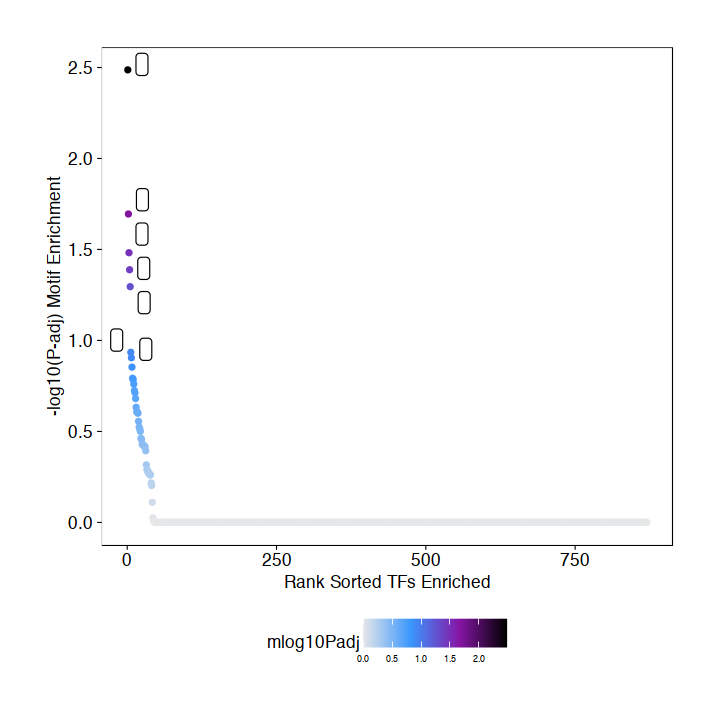

In [28]:
ggUp <- ggplot(df, aes(rank, mlog10Padj, color = mlog10Padj)) + 
  geom_point(size = 1) +
  ggrepel::geom_label_repel(
        data = df[rev(seq_len(30)), ], aes(x = rank, y = mlog10Padj, label = TF), 
        size = 1.5,
        nudge_x = 2,
        color = "black"
  ) + theme_ArchR() + 
  ylab("-log10(P-adj) Motif Enrichment") + 
  xlab("Rank Sorted TFs Enriched") +
  scale_color_gradientn(colors = paletteContinuous(set = "comet"))

ggUp

In [29]:
enrichMotifs <- peakAnnoEnrichment(
    seMarker = markersPeaks,
    ArchRProj = chrisAggrproj,
    peakAnnotation = "Motif",
    cutOff = "FDR <= 0.1 & Log2FC >= 0.5"
  )

ArchR logging to : ArchRLogs/ArchR-peakAnnoEnrichment-1430219138c8a-Date-2021-05-01_Time-13-04-24.log
If there is an issue, please report to github with logFile!

2021-05-01 13:04:31 : Computing Enrichments 1 of 10, 0.122 mins elapsed.

2021-05-01 13:04:33 : Computing Enrichments 2 of 10, 0.143 mins elapsed.

2021-05-01 13:04:33 : Computing Enrichments 3 of 10, 0.15 mins elapsed.

2021-05-01 13:04:34 : Computing Enrichments 4 of 10, 0.159 mins elapsed.

2021-05-01 13:04:34 : Computing Enrichments 5 of 10, 0.168 mins elapsed.

2021-05-01 13:04:35 : Computing Enrichments 6 of 10, 0.187 mins elapsed.

2021-05-01 13:04:36 : Computing Enrichments 7 of 10, 0.198 mins elapsed.

2021-05-01 13:04:37 : Computing Enrichments 8 of 10, 0.207 mins elapsed.

2021-05-01 13:04:37 : Computing Enrichments 9 of 10, 0.216 mins elapsed.

2021-05-01 13:04:38 : Computing Enrichments 10 of 10, 0.224 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-peakAnnoEnrichment-1430219138c8a-Date-2021-05-01_Ti

In [30]:
heatmapEM <- plotEnrichHeatmap(enrichMotifs, n = 10, transpose = TRUE)

ArchR logging to : ArchRLogs/ArchR-plotEnrichHeatmap-143027b548073-Date-2021-05-01_Time-13-04-38.log
If there is an issue, please report to github with logFile!

Adding Annotations..

Preparing Main Heatmap..



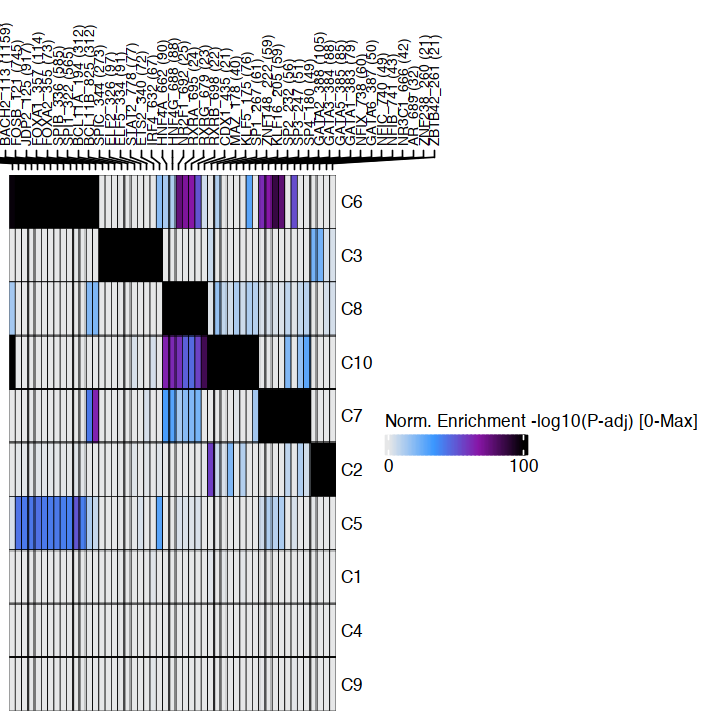

In [31]:
heatmapEM

In [32]:
plotPDF(heatmapEM, name = "Motifs-Enriched-Marker-Heatmap", 
        width = 8, height = 6, ArchRProj = chrisAggrproj, addDOC = FALSE)

Plotting ComplexHeatmap!



In [33]:
heatmapEMLarge <- plotEnrichHeatmap(enrichMotifs, n = 200, transpose = FALSE)

ArchR logging to : ArchRLogs/ArchR-plotEnrichHeatmap-143027e80b132-Date-2021-05-01_Time-13-05-03.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..



In [34]:
plotPDF(heatmapEMLarge, name = "Motifs-Enriched-Marker-Heatmap-large", 
        width = 8, height = 82, ArchRProj = chrisAggrproj, addDOC = FALSE)

Plotting ComplexHeatmap!



In [35]:
heatmapEMLarge <- plotEnrichHeatmap(enrichMotifs, n = 20, transpose = FALSE)

ArchR logging to : ArchRLogs/ArchR-plotEnrichHeatmap-1430239761de5-Date-2021-05-01_Time-13-05-05.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..



In [36]:
plotPDF(heatmapEMLarge, name = "Motifs-Enriched-Marker-Heatmap-large-top20", width = 8, height = 28, 
        ArchRProj = chrisAggrproj, addDOC = FALSE)

Plotting ComplexHeatmap!



# 6 ChromVAR Deviatons Enrichment with ArchR

As shown in previous chapters, TF motif enrichments can help us predict which regulatory factors are most active in our cell type of interest. These enrichments, however, are not calculated on a per-cell basis and they do not take into account the insertion sequence bias of the Tn5 transposase. `chromVAR`, an R packaged from the Greenlead Lab, was created to account for these issues. `chromVAR` is designed for predicting enrichment of TF activity on a per-cell basis from sparse chromatin accessibility data. The two primary outputs of chromVAR are:

1. “deviations” - A deviation is a bias-corrected measurement of how far the per-cell accessibility of a given feature (i.e motif) deviates from the expected accessibility based on the average of all cells or samples.

2. “z-score” - The z-score, also known as a “deviation score” is the z-score for each bias-corrected deviation across all cells. The absolute value of the deviation score is correlated with the per-cell read depth. This is because, with more reads, you have higher confidence that the difference in per-cell accessibility of the given feature (i.e. motif) from the expectation is greater than would occur by chance.

One of the primary limitations of `chromVAR` is that it was designed during the early era of scATAC-seq data generation when an experiment consisted of a few hundred of cells. At this experimental scale, chromVAR could easily read the entire cell-by-peak matrix into memory to quickly compute TF deviations. However, current experimental approaches use tens to hundreds of thousands of cells, generating cell-by-peak matrices that are much more difficult to read into memory. This leads to dramatic increases in run time and memory usage for even moderately sized datasets of 50,000 cells.

To circumvent these limitations, ArchR implements the same chromVAR analysis workflow by analyzing sample sub-matrices independently.

<img src='documentFigures/ArchR_chromVAR_Parallelization.png' width='40%'>

## Motif Deviations

First, lets make sure we have added motif annotations to our `ArchRProject`

In [55]:
if("Motif" %ni% names(chrisAggrproj@peakAnnotation)){
    chrisAggrproj <- addMotifAnnotations(ArchRProj = chrisAggrproj, motifSet = "cisbp", name = "Motif")
}

We also need to add a set of background peaks which are used in computing deviations. Background peaks are chosen using the `chromVAR::getBackgroundPeaks()` function which samples peaks based on similarity in GC-content and number of fragments across all samples using the Mahalanobis distance.

In [56]:
chrisAggrproj <- addBgdPeaks(chrisAggrproj)

Identifying Background Peaks!



We are now ready to compute per-cell deviations accross all of our motif annotations using the `addDeviationsMatrix()` function. This function has an optional parameter called `matrixName` that allows us to define the name of the deviations matrix that will be stored in the Arrow files. If we do not provide a value to this parameter, as in the example below, this function creates a matrix name by adding the word “Matrix” to the name of the `peakAnnotation`. The example below creates a deviations matrix in each of our Arrow files called “MotifMatrix”.

In [57]:
chrisAggrproj <- addDeviationsMatrix(
  ArchRProj = chrisAggrproj, 
  peakAnnotation = "Motif",
  force = TRUE
)

Using Previous Background Peaks!

ArchR logging to : ArchRLogs/ArchR-addDeviationsMatrix-1430236176d51-Date-2021-05-01_Time-13-25-47.log
If there is an issue, please report to github with logFile!



NULL


2021-05-01 13:25:51 : Batch Execution w/ safelapply!, 0 mins elapsed.

2021-05-01 13:25:52 : chromVAR deviations Liver Metastasis (1 of 2) Schep (2017), 0.017 mins elapsed.

2021-05-01 13:26:29 : Liver Metastasis (1 of 2) : Deviations for Annotation 43 of 870, 0.501 mins elapsed.

2021-05-01 13:26:56 : Liver Metastasis (1 of 2) : Deviations for Annotation 86 of 870, 0.965 mins elapsed.

2021-05-01 13:27:23 : Liver Metastasis (1 of 2) : Deviations for Annotation 129 of 870, 1.412 mins elapsed.

2021-05-01 13:27:56 : Liver Metastasis (1 of 2) : Deviations for Annotation 172 of 870, 1.952 mins elapsed.

2021-05-01 13:28:34 : Liver Metastasis (1 of 2) : Deviations for Annotation 215 of 870, 2.587 mins elapsed.

2021-05-01 13:29:09 : Liver Metastasis (1 of 2) : Deviations for Annotation 258 of 870, 3.18 mins elapsed.

2021-05-01 13:29:40 : Liver Metastasis (1 of 2) : Deviations for Annotation 301 of 870, 3.687 mins elapsed.

2021-05-01 13:30:05 : Liver Metastasis (1 of 2) : Deviations for A

To access these deviations, we use the `getVarDeviations()` function. If we want this function to return a `ggplot` object, we set `plot = TRUE` otherwise, this function would return the DataFrame object. The head of that DataFrame object is displayed by default when the function is run.

In [58]:
plotVarDev <- getVarDeviations(chrisAggrproj, name = "MotifMatrix", plot = TRUE)

DataFrame with 6 rows and 6 columns
     seqnames     idx        name combinedVars combinedMeans      rank
        <Rle> <array>     <array>    <numeric>     <numeric> <integer>
f139        z     139    JUNB_139      75.4003      -1.64575         1
f142        z     142   FOSL1_142      74.4479      -1.63029         2
f105        z     105   FOSL2_105      73.5514      -1.62656         3
f651        z     651 SMARCC1_651      73.4090      -1.59488         4
f137        z     137     FOS_137      70.9050      -1.61129         5
f124        z     124    JUND_124      70.2231      -1.60782         6


From the above snapshot of the DataFrame, you can see that the seqnames of the `MotifMatrix` are not chromosomes. Typically, in matrices like the `TileMatrix`, `PeakMatrix`, and `GeneScoreMatrix`, we store the chromosome information in `seqnames`. The `MotifMatrix` does not have any corresponding position information but, instead, stores both the “devations” and “z-scores” from `chromVA`R into the same matrix using two different seqnames - `deviations` and `z`. This becomes important later on if you try to use the `MotifMatrix` (which is of class `Sparse.Assays.Matrix`) in functions such as `getMarkerFeatures()`. In these types of operations, ArchR will expect you to subset `MotifMatrix` to one of the two seqnames (i.e. select either `z-scores` or `deviations` to perform calculations).

We can then plot these variable deviations.

Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


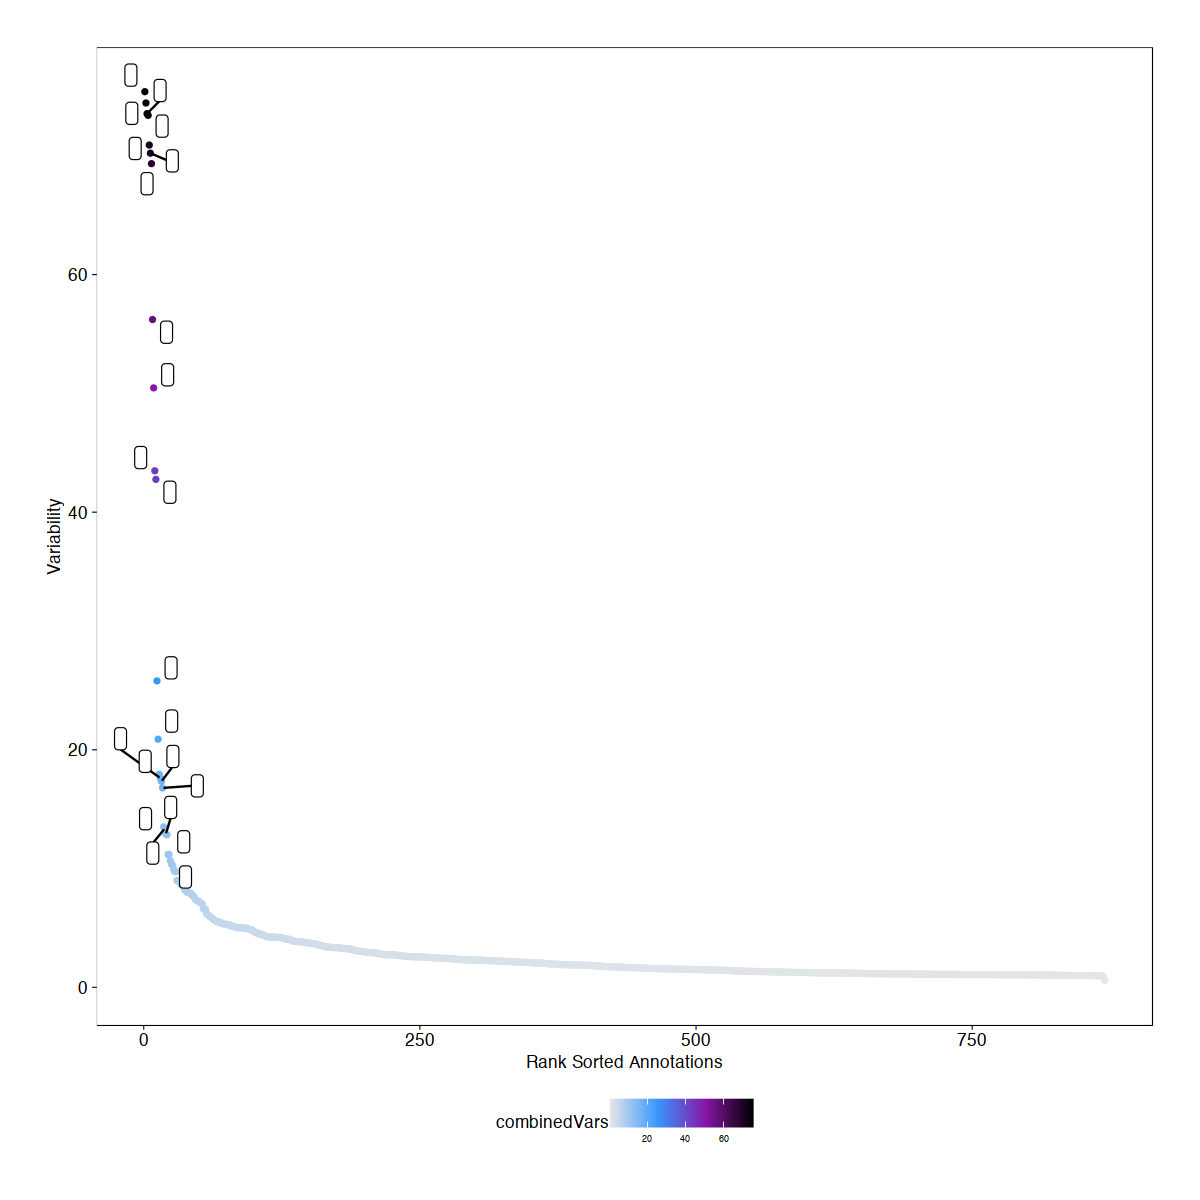

In [59]:
plotVarDev

In [60]:
getAvailableMatrices(chrisAggrproj)

[1] "GeneScoreMatrix" "MotifMatrix"     "PeakMatrix"      "TileMatrix"

# 6 Footprinting with ArchR

Transcription factor (TF) footprinting allows for the prediction of the precise binding location of a TF at a particular locus. This is because the DNA bases that are directly bound by the TF are actually protected from transposition while the DNA bases immediately adjacent to TF binding are accessible.

<img src='documentFigures/footprintingSchematic.png' width='30%'>

Ideally, TF footprinting is performed at a single site to determine the precise binding location of the TF. However, in practice, this requires very high sequencing depth, often much higher depth than what most users would obtain from either bulk or single-cell ATAC-seq. To get around this problem, we can combine Tn5 insertion locations across many instances of predicted TF binding. For example, we can take all peaks that harbor a CTCF motif and make an aggregate TF footprint for CTCF across the whole genome.

The accuracy of this footprint relies on generating a reliable curated list of predicted binding sites for the TF of interest. ArchR does this in a naive way via the `addMotifAnnotations()` functions by searching the peak regions for any DNA sequence matching a motif. Depending on the degeneracy of the motif of interest, this may or may not be sufficient. These motif annotations get added to the `ArchRProject` as a binary representation on a per peak basis `(0 = no motif, 1 = motif present)`. Once you have these motif annotations, ArchR performs footprinting using the `getFootprints()` function which takes as input an `ArchRProject` object and a `GenomicRanges` object that contains the positions of the motifs. These positions can be accessed from the `ArchRProjec`t via the `getPositions()` function. These footprints can then be plotted using the `plotFootprints()` function.

Perhaps most importantly, the footprinting analyses in ArchR account for known Tn5 insertion sequence bias. To do this, ArchR uses a matrix of hexamer position frequencies and a matrix of k-mer frequencies at Tn5 insertion sites:

<img src='documentFigures/footprintingMethods.png' width='50%'>

When footprinting, the first thing we need to do is obtain the positions of the relevant motifs. To do this, we call the `getPositions(`) function. This function has an optional parameter called name which can accept the `name` of the `peakAnnotation` object from which we would like to obtain the positions. If `name = NULL`, then ArchR will use the first entry in the `peakAnnotation` slot. In the code below, we do not specify `name` and `ArchR` uses the first entry which is our CIS-BP motifs.

In [37]:
motifPositions <- getPositions(chrisAggrproj)

In [38]:
motifPositions

GRangesList object of length 870:
$TFAP2B_1
GRanges object with 29694 ranges and 1 metadata column:
          seqnames              ranges strand |     score
             <Rle>           <IRanges>  <Rle> | <numeric>
      [1]     chr1       929418-929429      + |   7.75764
      [2]     chr1       938095-938106      + |   8.22318
      [3]     chr1       938536-938547      + |   8.01556
      [4]     chr1       938536-938547      - |   8.01556
      [5]     chr1       939597-939608      + |   7.77929
      ...      ...                 ...    ... .       ...
  [29690]     chrX 154751280-154751291      - |   8.77497
  [29691]     chrX 154762826-154762837      + |   8.00793
  [29692]     chrX 155071293-155071304      + |   8.66871
  [29693]     chrX 155071293-155071304      - |   7.89001
  [29694]     chrX 155435268-155435279      - |   7.93481
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

...
<869 more elements>

In [39]:
motifs <- c("GATA1", "CEBPA", "EBF1", "IRF4", "TBX21", "PAX5")
markerMotifs <- unlist(lapply(motifs, function(x) grep(x, names(motifPositions), value = TRUE)))
markerMotifs <- markerMotifs[markerMotifs %ni% "SREBF1_22"]
markerMotifs

[1] "GATA1_383" "CEBPA_155" "EBF1_67"   "IRF4_632"  "TBX21_780" "PAX5_709"

To accurately profile TF footprints, a large number of reads are required. Therefore, cells are grouped to create pseudo-bulk ATAC-seq profiles that can be then used for TF footprinting. These pseudo-bulk profiles are stored as group coverage files which we originally created in a previous chapter to perform peak calling. If you haven’t already added group coverages to your `ArchRProject`, lets do that now.

In [40]:
chrisAggrproj <- addGroupCoverages(ArchRProj = chrisAggrproj, groupBy = "Clusters")

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-14302da9261a-Date-2021-05-01_Time-13-05-24.log
If there is an issue, please report to github with logFile!



ERROR: Error in addGroupCoverages(ArchRProj = chrisAggrproj, groupBy = "Clusters"): Group Coverages Already Computed, Set force = TRUE to continue!


With group coverages calculated, we can now compute footprints for the subset of marker motifs that we previously selected using the `getFootprints()` function. Even though ArchR implements a highly optimized footprinting workflow, it is recommended to perform footprinting on a subset of motifs rather than all motifs. As such, we provide the subset of motifs to footprint via the positions parameter.

In [41]:
seFoot <- getFootprints(
  ArchRProj = chrisAggrproj, 
  positions = motifPositions[markerMotifs], 
  groupBy = "Clusters"
)

ArchR logging to : ArchRLogs/ArchR-getFootprints-1430214f661c4-Date-2021-05-01_Time-13-05-27.log
If there is an issue, please report to github with logFile!

2021-05-01 13:05:27 : Computing Kmer Bias Table, 0.003 mins elapsed.

2021-05-01 13:05:40 : Finished Computing Kmer Tables, 0.208 mins elapsed.

2021-05-01 13:05:40 : Computing Footprints, 0.211 mins elapsed.

2021-05-01 13:06:12 : Computing Footprints Bias, 0.748 mins elapsed.

2021-05-01 13:06:26 : Summarizing Footprints, 0.987 mins elapsed.



## 6.1 Normalization of Footprints for Tn5 Bias

One major challenge with TF footprinting using ATAC-seq data is the insertion sequence bias of the Tn5 transposase which can lead to misclassification of TF footprints. To account for Tn5 insertion bias, ArchR identifies the k-mer (user-defined length, default length 6) sequences surrounding each Tn5 insertion site. To do this analysis, ArchR identifies single-base resolution Tn5 insertion sites for each pseudo-bulk, resizes these 1-bp sites to k-bp windows (-k/2 and + (k/2 - 1) bp from insertion), and then creates a k-mer frequency table using the `oligonucleotidefrequency(w=k, simplify.as="collapse")` function from the `Biostrings` package. ArchR then calculates the expected k-mers genome-wide using the same function with the BSgenome-associated genome file. To calculate the insertion bias for a pseudo-bulk footprint, ArchR creates a k-mer frequency matrix that is represented as all possible k-mers across a window +/- N bp (user-defined, default 250 bp) from the motif center. Then, iterating over each motif site, ArchR fills in the positioned k-mers into the k-mer frequency matrix. This is then calculated for each motif position genome-wide. Using the sample’s k-mer frequency table, ArchR can then compute the expected Tn5 insertions by multiplying the k-mer position frequency table by the observed/expected Tn5 k-mer frequency.

All of this happens under the hood within the `plotFootprints()` function.

### Subtracting the Tn5 Bias

One normalization method subtracts the Tn5 bias from the footprinting signal. This normalization is performed by setting `normMethod = "Subtract"` when calling `plotFootprints()`.

In [42]:
plotFootprints(
  seFoot = seFoot,
  ArchRProj = chrisAggrproj, 
  normMethod = "Subtract",
  plotName = "Footprints-Subtract-Bias",
  addDOC = FALSE,
  smoothWindow = 5
)

ArchR logging to : ArchRLogs/ArchR-plotFootprints-14302a959907-Date-2021-05-01_Time-13-06-27.log
If there is an issue, please report to github with logFile!

2021-05-01 13:06:27 : Plotting Footprint : GATA1_383 (1 of 6), 0.001 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = Subtract

2021-05-01 13:06:29 : Plotting Footprint : CEBPA_155 (2 of 6), 0.026 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = Subtract

2021-05-01 13:06:30 : Plotting Footprint : EBF1_67 (3 of 6), 0.05 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = Subtract

2021-05-01 13:06:31 : Plotting Footprint : IRF4_632 (4 of 6), 0.075 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = Subtract

2021-05-01 13:06:33 : Plotting Footprint : TBX21_780 (5 of 6), 0.099 mins elapsed.

Applying smoothing window to footprint

No

# 7. Co-accessibility with ArchR

Co-accessibility is a correlation in accessibility between two peaks across many single cells. Said another way, when Peak A is accessible in a single cell, Peak B is often also accessible. We illustrate this concept visually below, showing that Enhancer E3 is often co-accessible with Promoter P.

<img src='documentFigures/ArchR_Coaccessibility.png' width='30%'>

One thing to note about co-accessibility analysis is that it often identified cell type-specific peaks as being co-accessibile. This is because these peaks are often all accessible together within a single cell type and often all not accessible in all other cell types. This drives a strong correlation but does not necessarily mean that there is a regulatory relationship between these peaks.

To calculate co-accessibility in ArchR, we use the `addCoAccessibility()` function which stores peak co-accessibility information in the ArchRProject.

In [43]:
chrisAggrproj <- addCoAccessibility(
    ArchRProj = chrisAggrproj,
    reducedDims = "IterativeLSI",
    verbose = FALSE
)

ArchR logging to : ArchRLogs/ArchR-addCoAccessibility-1430274755039-Date-2021-05-01_Time-13-07-46.log
If there is an issue, please report to github with logFile!

ArchR logging successful to : ArchRLogs/ArchR-addCoAccessibility-1430274755039-Date-2021-05-01_Time-13-07-46.log



We can retrieve this co-accessibility information from the ArchRProject via the `getCoAccessibility()` function which returns a DataFrame object if `returnLoops = FALSE`.

In [44]:
cA <- getCoAccessibility(
    ArchRProj = chrisAggrproj,
    corCutOff = 0.5,
    resolution = 1000,
    returnLoops = TRUE
)

cA[[1]]

GRanges object with 654254 ranges and 1 metadata column:
           seqnames              ranges strand |     value
              <Rle>           <IRanges>  <Rle> | <numeric>
       [1]     chr1       898500-911500      * |  0.760166
       [2]     chr1       898500-929500      * |  0.728772
       [3]     chr1       898500-933500      * |  0.662891
       [4]     chr1       898500-938500      * |  0.609277
       [5]     chr1       904500-916500      * |  0.549848
       ...      ...                 ...    ... .       ...
  [654250]     chrX 155745500-155767500      * |  0.614846
  [654251]     chrX 155745500-155779500      * |  0.575359
  [654252]     chrX 155747500-155767500      * |  0.624952
  [654253]     chrX 155747500-155779500      * |  0.635557
  [654254]     chrX 155881500-155882500      * |  0.709285
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [45]:
markerGenes  <- c(
    "CD34", #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1", #B-Cell Trajectory
    "CD14", #Monocytes
    "CD3D", "CD8A", "TBX21", "IL7R" #TCells
  )

p <- plotBrowserTrack(
    ArchRProj = chrisAggrproj, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000,
    loops = getCoAccessibility(chrisAggrproj),
    verbose = FALSE
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-143026884686d-Date-2021-05-01_Time-13-08-56.log
If there is an issue, please report to github with logFile!



GRanges object with 9 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]     chr1 207880972-207911402      - |         947        CD34
  [2]     chrX   48786554-48794311      + |        2623       GATA1
  [3]     chr9   36833275-37034185      - |        5079        PAX5
  [4]    chr11   60455752-60470760      + |         931       MS4A1
  [5]     chr5 140631728-140633701      - |         929        CD14
  [6]    chr11 118338954-118342744      - |         915        CD3D
  [7]     chr2   86784610-86808396      - |         925        CD8A
  [8]    chr17   47733244-47746119      + |       30009       TBX21
  [9]     chr5   35852695-35879603      + |        3575        IL7R
  -------
  seqinfo: 24 sequences from hg38 genome


Getting Region From Arrow Files 1 of 2

Getting Region From Arrow Files 2 of 2

Getting Region From Arrow Files 1 of 2

Getting Region From Arrow Files 2 of 2

Getting Region From Arrow Files 1 of 2

Getting Region From Arrow Files 2 of 2

Getting Region From Arrow Files 1 of 2

Getting Region From Arrow Files 2 of 2

Getting Region From Arrow Files 1 of 2

Getting Region From Arrow Files 2 of 2

Getting Region From Arrow Files 1 of 2

Getting Region From Arrow Files 2 of 2

Getting Region From Arrow Files 1 of 2

Getting Region From Arrow Files 2 of 2

Getting Region From Arrow Files 1 of 2

Getting Region From Arrow Files 2 of 2

Getting Region From Arrow Files 1 of 2

Getting Region From Arrow Files 2 of 2

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-143026884686d-Date-2021-05-01_Time-13-08-56.log



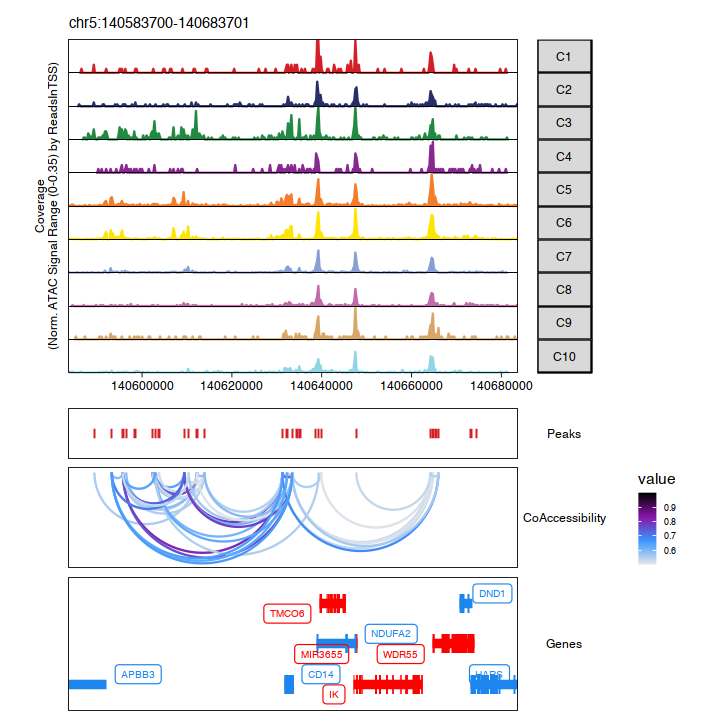

In [46]:
grid::grid.draw(p$CD14)

In [47]:
markerGenes  <- c(
    "HNF4A", #Early Progenitor
    "GATA6"
  )

p <- plotBrowserTrack(
    ArchRProj = chrisAggrproj, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes, 
    upstream = 5000,
    downstream = 100000,
    loops = getCoAccessibility(chrisAggrproj),
    verbose = FALSE
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-1430271d02e99-Date-2021-05-01_Time-13-09-22.log
If there is an issue, please report to github with logFile!



GRanges object with 2 ranges and 2 metadata columns:
      seqnames            ranges strand |     gene_id      symbol
         <Rle>         <IRanges>  <Rle> | <character> <character>
  [1]    chr20 44355700-44434596      + |        3172       HNF4A
  [2]    chr18 22169443-22202528      + |        2627       GATA6
  -------
  seqinfo: 24 sequences from hg38 genome


Getting Region From Arrow Files 1 of 2

Getting Region From Arrow Files 2 of 2

Getting Region From Arrow Files 1 of 2

Getting Region From Arrow Files 2 of 2

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-1430271d02e99-Date-2021-05-01_Time-13-09-22.log



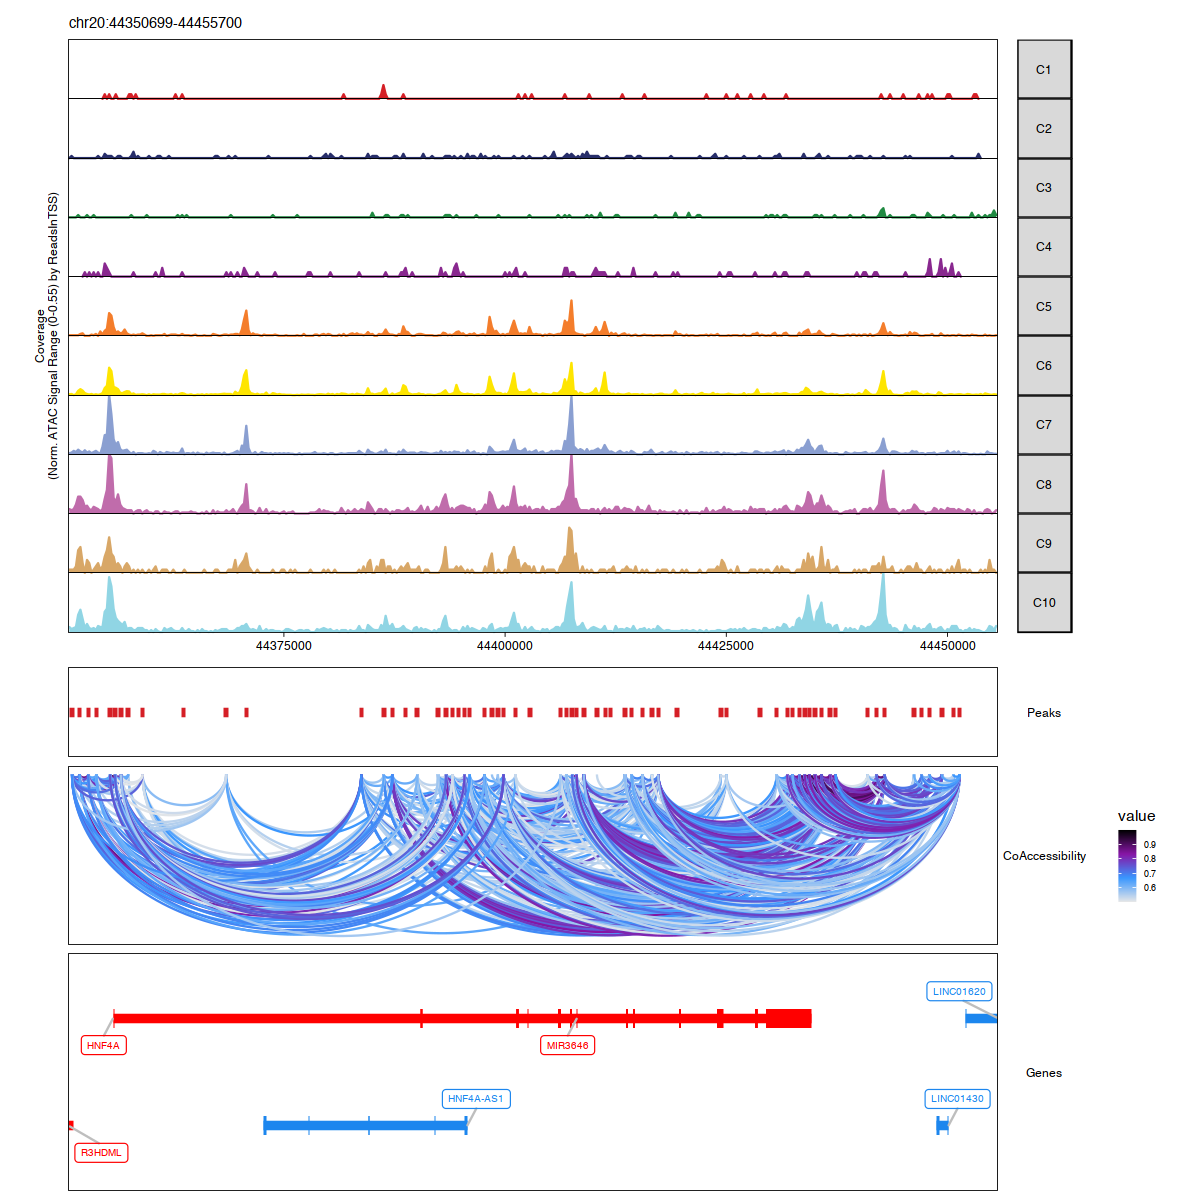

In [48]:
options(repr.plot.width=10, repr.plot.height=10)
grid::grid.draw(p$HNF4A)

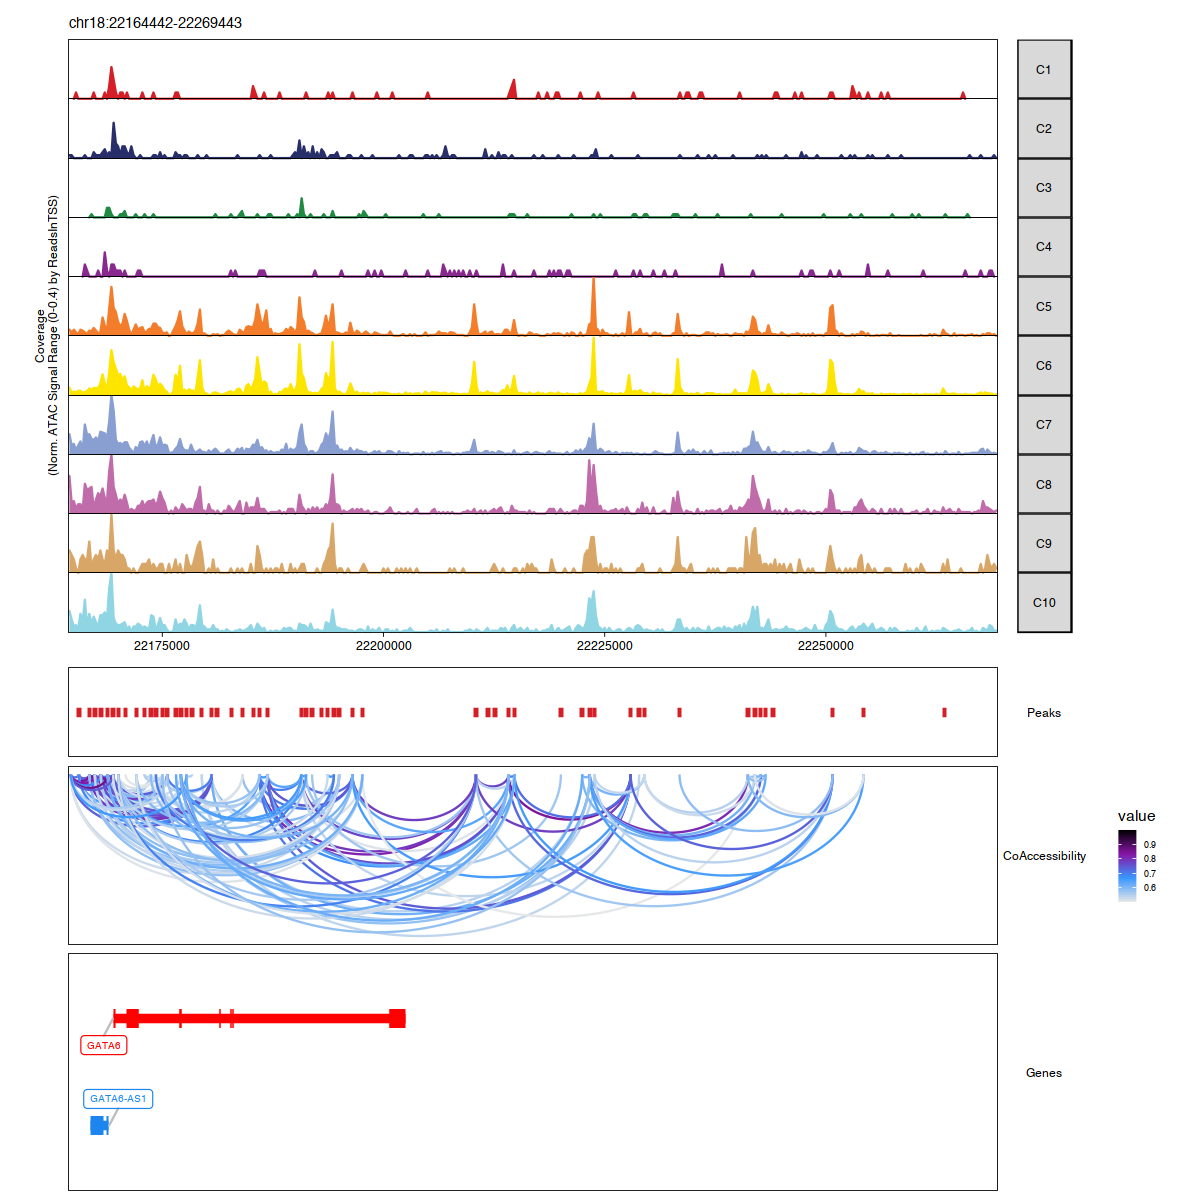

In [49]:
options(repr.plot.width=10, repr.plot.height=10)
grid::grid.draw(p$GATA6)

In [50]:
plotPDF(plotList = p, 
    name = "Plot-Tracks-Marker-Genes-with-CoAccessibility.pdf", 
    ArchRProj = chrisAggrproj, 
    addDOC = FALSE, width = 5, height = 5)

Plotting Gtable!



NULL


Plotting Gtable!



NULL


In [54]:
getAvailableMatrices(chrisAggrproj)

[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

# Saving project

In [61]:
saveArchRProject(ArchRProj = chrisAggrproj, outputDirectory = "chrisAggrproj", load = FALSE)

Saving ArchRProject...



In [119]:
save.image('data.RData')

In [59]:
ArchRBrowser(ArchRProj = aoibAggrproj)

ArchR logging to : ArchRLogs/ArchR-ArchRBrowser-3311719135f3-Date-2020-06-27_Time-20-48-15.log
If there is an issue, please report to github with logFile!


Listening on http://127.0.0.1:7335

Getting median of TSSEnrichment for Clusters

Getting median of nFrags for Clusters



NULL


Getting median of TSSEnrichment for Clusters

Getting median of nFrags for Clusters



NULL


## Generating bigWig files

In [106]:
getGroupBW(ArchRProj = chrisAggrproj,
          groupBy = "Clusters",
          normMethod = "ReadsInTSS",
          tileSize = 100,
          maxCells = 1000)

ArchR logging to : ArchRLogs/ArchR-getGroupBW-cc161dbb09fb-Date-2021-04-08_Time-16-26-23.log
If there is an issue, please report to github with logFile!

2021-04-08 16:26:34 : C1 (1 of 10) : Creating BigWig for Group, 0.185 mins elapsed.

2021-04-08 16:27:10 : C10 (2 of 10) : Creating BigWig for Group, 0.779 mins elapsed.

2021-04-08 16:27:35 : C2 (3 of 10) : Creating BigWig for Group, 1.186 mins elapsed.

2021-04-08 16:27:50 : C3 (4 of 10) : Creating BigWig for Group, 1.446 mins elapsed.

2021-04-08 16:28:04 : C4 (5 of 10) : Creating BigWig for Group, 1.682 mins elapsed.

2021-04-08 16:28:16 : C5 (6 of 10) : Creating BigWig for Group, 1.886 mins elapsed.

2021-04-08 16:28:40 : C6 (7 of 10) : Creating BigWig for Group, 2.272 mins elapsed.

2021-04-08 16:29:06 : C7 (8 of 10) : Creating BigWig for Group, 2.714 mins elapsed.

2021-04-08 16:29:27 : C8 (9 of 10) : Creating BigWig for Group, 3.054 mins elapsed.

2021-04-08 16:29:42 : C9 (10 of 10) : Creating BigWig for Group, 3.318 mins elap

[1] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj/GroupBigWigs/Clusters/C1-TileSize-100-normMethod-ReadsInTSS-ArchR.bw" 
 [2] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj/GroupBigWigs/Clusters/C10-TileSize-100-normMethod-ReadsInTSS-ArchR.bw"
 [3] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj/GroupBigWigs/Clusters/C2-TileSize-100-normMethod-ReadsInTSS-ArchR.bw" 
 [4] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj/GroupBigWigs/Clusters/C3-TileSize-100-normMethod-ReadsInTSS-ArchR.bw" 
 [5] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj/GroupBigWigs/Clusters/C4-TileSize-100-normMethod-ReadsInTSS-ArchR.bw" 
 [6] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj/GroupBigWigs/Clusters/C5-TileSize-100-normMethod-ReadsInTSS-ArchR.bw" 
 [7] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj/GroupBigWigs/Clusters/C6-TileSize-100-normMethod-ReadsInTSS-ArchR.bw" 
 [8] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj/GroupBigWigs/Clusters/C7-TileSize-100-normMethod-ReadsInTSS-ArchR.bw" 
 [9] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj/GroupBigWigs/Clusters/C8-TileSize-100-normMethod-ReadsInTSS-ArchR.bw" 
[10] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj/GroupBigWigs/Clusters/C9-TileSize-100-normMethod-ReadsInTSS-ArchR.bw"

In [107]:
getGroupBW(ArchRProj = chrisAggrproj,
          groupBy = "Sample",
          normMethod = "ReadsInTSS",
          tileSize = 100,
          maxCells = 1000)

ArchR logging to : ArchRLogs/ArchR-getGroupBW-cc16425586b2-Date-2021-04-08_Time-16-29-54.log
If there is an issue, please report to github with logFile!

2021-04-08 16:30:02 : Adenocarcinoma Tumour (1 of 2) : Creating BigWig for Group, 0.14 mins elapsed.

2021-04-08 16:30:31 : Liver Metastasis (2 of 2) : Creating BigWig for Group, 0.617 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-getGroupBW-cc16425586b2-Date-2021-04-08_Time-16-29-54.log



[1] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj/GroupBigWigs/Sample/Adenocarcinoma.Tumour-TileSize-100-normMethod-ReadsInTSS-ArchR.bw"
[2] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj/GroupBigWigs/Sample/Liver.Metastasis-TileSize-100-normMethod-ReadsInTSS-ArchR.bw"

## Generating  co-accessibility as dataframe

In [108]:
cA <- getCoAccessibility(
    ArchRProj = chrisAggrproj,
    corCutOff = 0.8,
    resolution = 1000,
    returnLoops = TRUE
)

In [109]:
cA_DF <- as.data.frame(cA[[1]])

In [110]:
dim(cA_DF)

[1] 208684      6

In [111]:
cA_DF_mod <- data.frame(Peak1 = paste0(cA_DF$seqnames,'_',cA_DF$start,'_',cA_DF$start),
                       Peak2 = paste0(cA_DF$seqnames,'_',cA_DF$end,'_',cA_DF$end),
                       coaccess = cA_DF$value)

In [112]:
cA_DF_bed = data.frame(chrom = cA_DF$seqnames,
                      chromStart = cA_DF$start,
                      chromEnd = cA_DF$end,
                      name = 'EsophagusDevelop',
                      score = as.integer(cA_DF$value*1000),
                      value = cA_DF$value,
                      exp = '.',
                      color = '0',
                      sourceChrom = cA_DF$seqnames,
                       sourceStart = cA_DF$start,
                       sourceEnd = cA_DF$start,
                       sourceName = '.',
                       sourceStrand = '.',
                       targetChrom = cA_DF$seqnames,
                       targetStart = cA_DF$end,
                       targetEnd = cA_DF$end,
                       targetName = '.',
                       targetStrand = '.'
                      )

In [113]:
write.table(cA_DF,'coAccessibility.csv', sep='\t', quote=FALSE, row.names = FALSE)
write.table(cA_DF,'coAccessibility.bed', sep='\t', quote=FALSE, row.names = FALSE)
write.table(cA_DF_bed,'coAccessibility13.bed', sep='\t', quote=FALSE, row.names = FALSE)
write.table(cA_DF_mod,'coAccessibility_modified.csv', sep='\t', quote=FALSE, row.names = FALSE)

## SingleR for cell type annotation

We will use `SingleR` here to annotate the cell types using `GeneScoreMatrix` here

In [10]:
chrisAggrproj <- loadArchRProject(path = "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj")

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [5]:
getAvailableMatrices(chrisAggrproj)

[1] "GeneScoreMatrix" "MotifMatrix"     "PeakMatrix"      "TileMatrix"

In [8]:
geneScoreMatrix <- getMatrixFromProject(chrisAggrproj,'GeneScoreMatrix')

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-9ca92d446e64-Date-2021-04-21_Time-16-12-22.log
If there is an issue, please report to github with logFile!

2021-04-21 16:12:32 : Organizing colData, 0.165 mins elapsed.

2021-04-21 16:12:32 : Organizing rowData, 0.165 mins elapsed.

2021-04-21 16:12:32 : Organizing Assays (1 of 1), 0.165 mins elapsed.

2021-04-21 16:12:32 : Constructing SummarizedExperiment, 0.169 mins elapsed.

2021-04-21 16:12:33 : Finished Matrix Creation, 0.178 mins elapsed.



In [17]:
rownames(geneScoreMatrix) <- rowData(geneScoreMatrix)$name

In [18]:
geneScoreMatrix

class: SummarizedExperiment 
dim: 24919 2335 
metadata(0):
assays(1): GeneScoreMatrix
rownames(24919): OR4F5 LOC729737 ... F8A2 TMLHE
rowData names(6): seqnames start ... name idx
colnames(2335): Liver Metastasis#AACCGATCAGCGTCGT-1 Liver
  Metastasis#TACGCCTTCAGGAATA-1 ... Adenocarcinoma
  Tumour#AAGGAGCGTTCCTGTC-1 Adenocarcinoma Tumour#ATGTACGCACTCGGAC-1
colData names(18): BlacklistRatio DoubletEnrichment ... ReadsInPeaks
  FRIP

In [24]:
library(SingleR)
library(ggforce)

In [31]:
# Use celldex if installed, else falls back to SingleR
if ( requireNamespace("celldex", quietly = TRUE) ) {
    # For Human
    bpen <- celldex::BlueprintEncodeData()
#   dice <- celldex::DatabaseImmuneCellExpressionData()
    hpca <- celldex::HumanPrimaryCellAtlasData()
#   mona <- celldex::MonacoImmuneData()
#   dmap <- celldex::NovershternHematopoieticData()

    # For mouse
#   immg <- celldex::ImmGenData()
#   mmrna <- celldex::MouseRNAseqData()
} else {
    # For Human
    bpen <- SingleR::BlueprintEncodeData()
#   dice <- SingleR::DatabaseImmuneCellExpressionData()
    hpca <- SingleR::HumanPrimaryCellAtlasData()
#   mona <- SingleR::MonacoImmuneData()
#   dmap <- SingleR::NovershternHematopoieticData()

    # For mouse
#   immg <- SingleR::ImmGenData()
#   mmrna <- SingleR::MouseRNAseqData()    
}

snapshotDate(): 2020-10-27

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

snapshotDate(): 2020-10-27

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache



In [19]:
# For human
singler_results_encode_main <- SingleR(
    test = assay(geneScoreMatrix), 
    #ref = list(BP=bp.se, HPCA=hpca.se, Immuno=db.Immuno, MoncoImmuno=db.MoncoImmuno, ImmGen = db.ImmGen), 
    ref = list(BP=bp.se, HPCA=hpca.se), 
    #labels = list(bp.se$label.main, hpca.se$label.main, db.Immuno$label.main, 
    #              db.MoncoImmuno$label.main, db.ImmGen$label.main),
    labels = list(bp.se$label.main, hpca.se$label.main),
    method='single'
)

Warning message:
“'method="cluster"' is no longer necessary when 'cluster=' is specified”


In [32]:
# For human
pred.singler.bp <- SingleR(
    test = geneScoreMatrix, # only use is_pass and non-ambient genes
#    clusters = colLabels(cdScFiltSub), # To obtain per-cluster profiles
    assay.type.test = "GeneScoreMatrix",
    de.method = "wilcox",
    ref = list(BP = bpen), 
    labels = list(bpen$label.main)
)

pred.singler.hpca <- SingleR(
    test = geneScoreMatrix,
#    clusters = colLabels(cdScFiltSub),
    assay.type.test = "GeneScoreMatrix",
    de.method = "wilcox",
    ref = list(HPCA = hpca), 
    labels = list(hpca$label.main)
)

pred.singler <- SingleR(
    test = geneScoreMatrix,
#    clusters = colLabels(cdScFiltSub),
    assay.type.test = "GeneScoreMatrix",
    de.method = "wilcox",
    ref = list(BP = bpen, HPCA = hpca), 
    labels = list(bpen$label.main, hpca$label.main)
)

Warning message in FUN(...):
“no within-block comparison between Eosinophils and DC”
Warning message in FUN(...):
“no within-block comparison between Neuroepithelial_cell and BM & Prog.”
Warning message in FUN(...):
“no within-block comparison between Eosinophils and DC”
Warning message in FUN(...):
“no within-block comparison between Neuroepithelial_cell and BM & Prog.”


In [33]:
table(BP = pred.singler.bp$labels)
table(HPCA = pred.singler.hpca$labels)
table(Combined = pred.singler$labels)

BP
       Adipocytes        Astrocytes           B-cells      CD4+ T-cells 
              331                40                24                15 
     CD8+ T-cells      Chondrocytes                DC Endothelial cells 
                4               110                 7               133 
      Eosinophils  Epithelial cells      Erythrocytes       Fibroblasts 
                1              1097                 3                49 
              HSC     Keratinocytes       Macrophages       Melanocytes 
               13                10                37                31 
  Mesangial cells         Monocytes          Myocytes           Neurons 
              117                36                26               174 
      Neutrophils          NK cells         Pericytes   Skeletal muscle 
               16                 1                 6                28 
    Smooth muscle 
               26 

HPCA
           Astrocyte               B_cell                   BM 
                 122                   17                    1 
          BM & Prog.         Chondrocytes                   DC 
                   1                   61                    8 
Embryonic_stem_cells    Endothelial_cells     Epithelial_cells 
                  24                  163                  747 
        Erythroblast          Fibroblasts          Gametocytes 
                   1                   68                   60 
         Hepatocytes           HSC_-G-CSF            HSC_CD34+ 
                  83                    3                    2 
           iPS_cells        Keratinocytes           Macrophage 
                  13                  139                   38 
            Monocyte                  MSC Neuroepithelial_cell 
                  23                   11                  162 
             Neurons          Neutrophils              NK_cell 
                 165               

Combined
          Adipocytes            Astrocyte           Astrocytes 
                 195                   39                   29 
              B_cell              B-cells                   BM 
                   3                   18                    1 
        CD4+ T-cells         CD8+ T-cells         Chondrocytes 
                   8                    1                   65 
                  DC Embryonic_stem_cells    Endothelial cells 
                   6                    4                  147 
   Endothelial_cells          Eosinophils     Epithelial cells 
                  25                    2                  900 
    Epithelial_cells         Erythrocytes          Fibroblasts 
                 241                    1                   39 
         Gametocytes          Hepatocytes                  HSC 
                  12                   10                    4 
          HSC_-G-CSF            HSC_CD34+            iPS_cells 
                   1           

In [34]:
# Re-label for consistency
HPCA_to_BP_labels <- function(pred = pred.singler) {
    HPCA <- c("Astrocyte","B_cell","T_cells","Endothelial_cells","Epithelial_cells","Macrophage","Monocyte",
              "NK_cell","Smooth_muscle_cells")
    BP <- c("Astrocytes","B-cells","T-cells","Endothelial cells","Epithelial cells","Macrophages","Monocytes",
            "NK cells","Smooth muscle")
    
    for(i in 1:length(HPCA)) {
        if(sum(pred$labels == HPCA[i]) > 0) {
            pred[pred$labels == HPCA[i],]$labels = BP[i]
        }
    }
    return(pred)
}

pred.singler <- HPCA_to_BP_labels(pred.singler)

In [35]:
colData(geneScoreMatrix)$CellType <- factor(pred.singler$labels) # Use BP + HPCA combined prediction
table(colData(geneScoreMatrix)$CellType)


          Adipocytes           Astrocytes              B-cells 
                 195                   68                   21 
                  BM         CD4+ T-cells         CD8+ T-cells 
                   1                    8                    1 
        Chondrocytes                   DC Embryonic_stem_cells 
                  65                    6                    4 
   Endothelial cells          Eosinophils     Epithelial cells 
                 172                    2                 1141 
        Erythrocytes          Fibroblasts          Gametocytes 
                   1                   39                   12 
         Hepatocytes                  HSC           HSC_-G-CSF 
                  10                    4                    1 
           HSC_CD34+            iPS_cells        Keratinocytes 
                   2                    2                   28 
         Macrophages          Melanocytes      Mesangial cells 
                  46                   

In [37]:
# Use the same cell type colour from plotScoreHeatmap and store in c_celltype_col
celltype.df <- data.frame(Cell = colnames(geneScoreMatrix), 
                          CellType = colData(geneScoreMatrix)$CellType) %>% arrange(Cell)

celltype.df$color <- data.frame(Cell = rownames(p$gtable$grobs[[5]]$gp[[1]]), 
                                color = p$gtable$grobs[[5]]$gp[[1]][,1]) %>% arrange(Cell) %>% pull(color) 

c_celltype_col <- distinct(celltype.df[,c("CellType","color")], CellType, .keep_all = TRUE)
c_celltype_col <- setNames(c_celltype_col$color, c_celltype_col$CellType)
c_celltype_col

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'rownames': object 'p' not found


In [38]:
data <- as_tibble(colData(geneScoreMatrix)[,c("Clusters","CellType")]) %>% 
    group_by(Clusters, CellType) %>% tally() %>% ungroup() %>% gather_set_data(1:2) %>% 
    mutate(x = factor(x, levels = c("Clusters","CellType"))) # Cluster on the left and Cell type on the right

data_labels <- tibble(group = c(rep("Clusters", length(levels(geneScoreMatrix$Clusters))), 
                                rep("CellType", length(levels(geneScoreMatrix$CellType))))) %>%
    mutate(hjust = ifelse(group == "Clusters", 1, 0), # label: right-justified, CellType: left-justified
           nudge_x = ifelse(group == "Clusters", -0.1, 0.1)) # Horizontal nudge labels

Warning message:
“Removed 170 rows containing non-finite values (stat_parallel_sets).”
Warning message:
“Computation failed in `stat_parallel_sets()`:
non-numeric argument to binary operator”
Warning message:
“Removed 170 rows containing non-finite values (stat_parallel_sets_axes).”
Warning message:
“Removed 170 rows containing non-finite values (stat_parallel_sets_axes).”
Warning message in x + params$x:
“longer object length is not a multiple of shorter object length”
Warning message in x + params$x:
“longer object length is not a multiple of shorter object length”
Warning message in x + params$x:
“longer object length is not a multiple of shorter object length”
ERROR while rich displaying an object: Error: Aesthetics must be either length 1 or the same as the data (10): hjust

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2

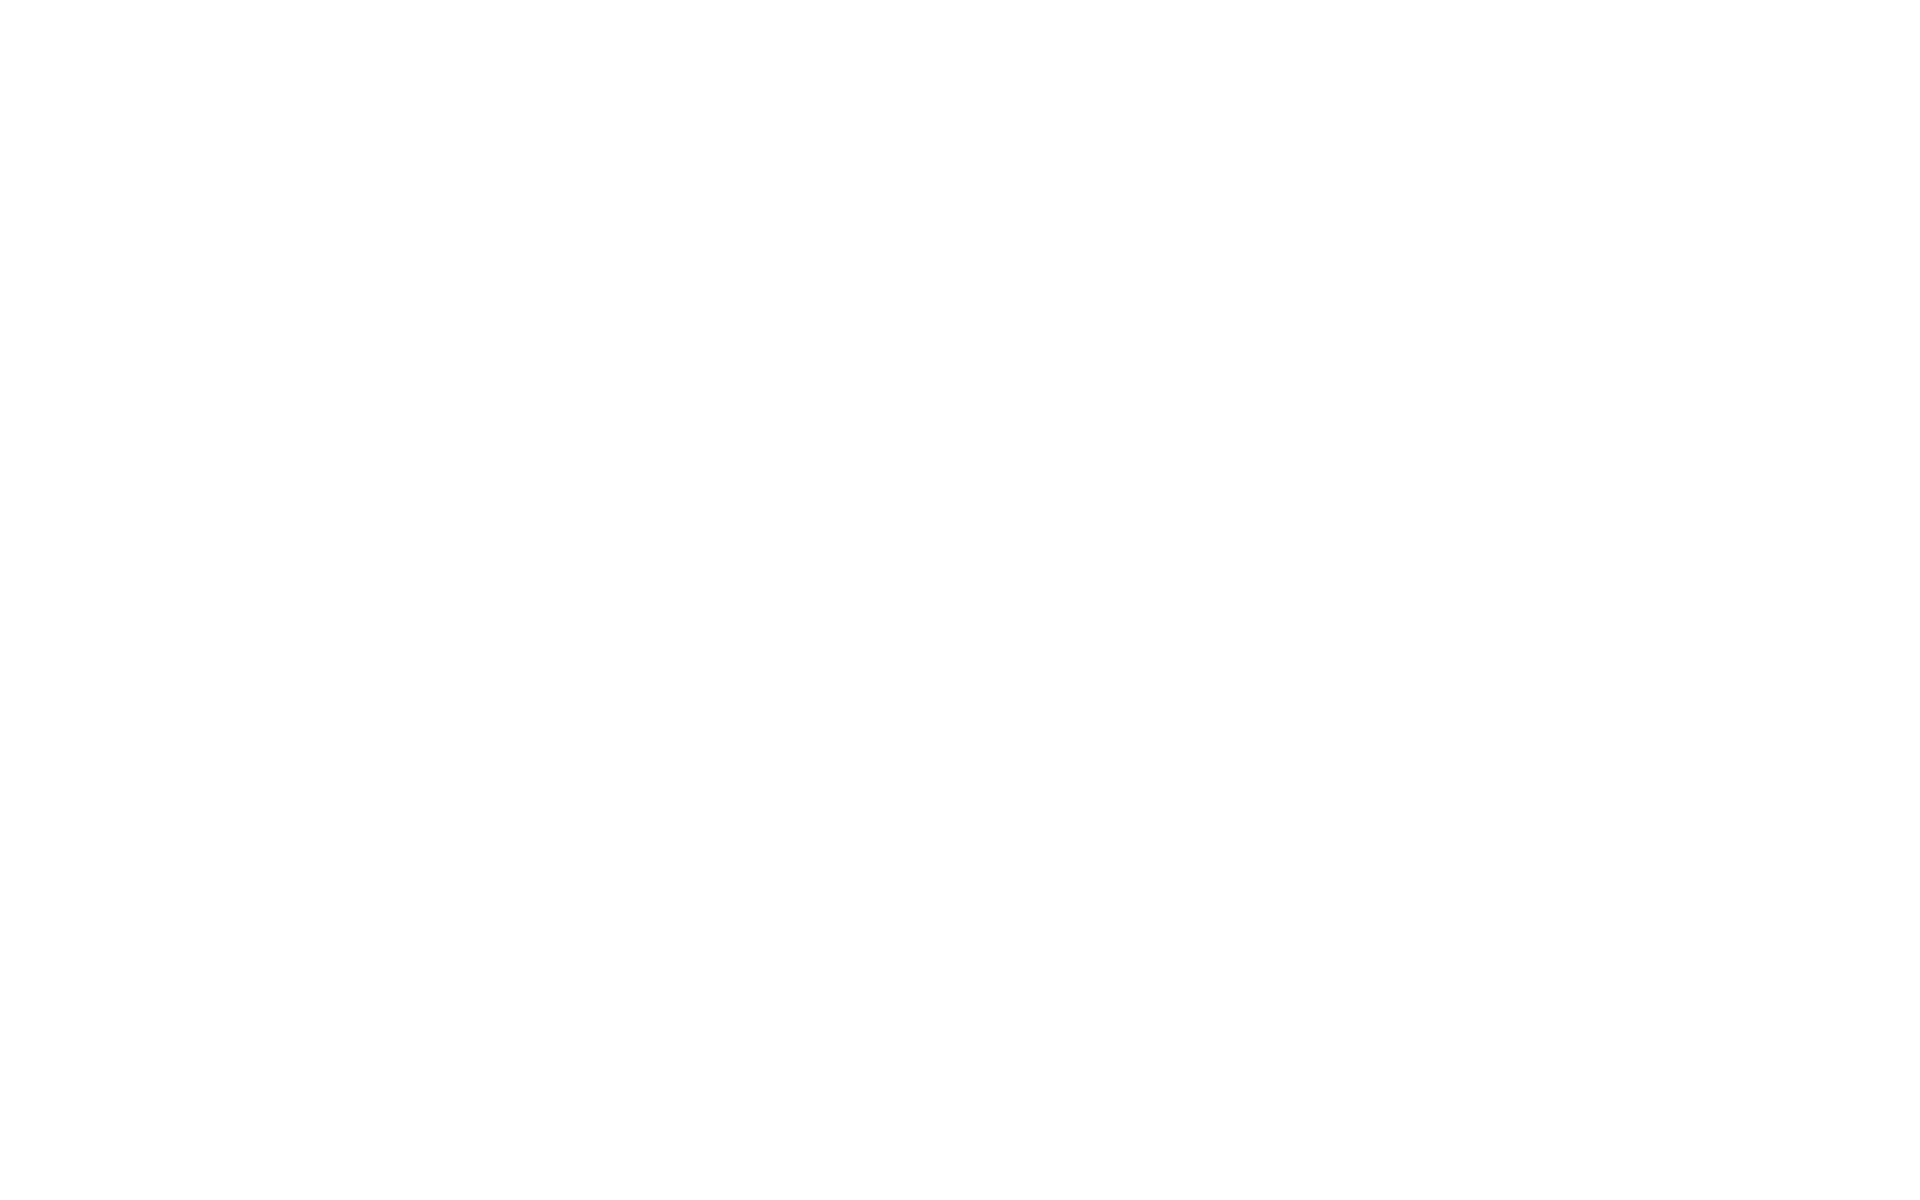

In [51]:
p2 <- ggplot(data, aes(x, id = id, split = y, value = n)) + 
    geom_parallel_sets(aes(fill = Clusters), alpha = 0.6, axis.width = 0.15) + 
    geom_parallel_sets_axes(aes(fill = y), color = "black", size = 0.3, axis.width = 0.1) + 
    geom_text(aes(y = n, split = y), stat = "parallel_sets_axes", hjust = data_labels$hjust, 
              nudge_x = data_labels$nudge_x, fontface = "bold", size = 5) + 
    scale_x_discrete(labels = c("Clusters", "Cell type")) + # Change x-axis labels
    scale_fill_manual(values = color_assignments) +
    theme_void(base_size = 20) + 
    theme(legend.position = "none", plot.margin = unit(c(1, 1, 1, 1), "lines"),
          axis.text.x = element_text(face = "bold", color = "black"))


p2

In [50]:
colData(geneScoreMatrix)$cellType <- singler_results_encode_main$labels
head(singler_results_encode_main$labels)

[1] "Epithelial cells" "Epithelial cells" "Epithelial_cells" "Epithelial cells"
[5] "Epithelial cells" "Epithelial_cells"

In [21]:
custom_colors <- list()

colors_dutch <- c(
  '#FFC312','#C4E538','#12CBC4','#FDA7DF','#ED4C67',
  '#F79F1F','#A3CB38','#1289A7','#D980FA','#B53471',
  '#EE5A24','#009432','#0652DD','#9980FA','#833471',
  '#EA2027','#006266','#1B1464','#5758BB','#6F1E51'
)

colors_spanish <- c(
  '#40407a','#706fd3','#f7f1e3','#34ace0','#33d9b2',
  '#2c2c54','#474787','#aaa69d','#227093','#218c74',
  '#ff5252','#ff793f','#d1ccc0','#ffb142','#ffda79',
  '#b33939','#cd6133','#84817a','#cc8e35','#ccae62'
)

custom_colors$discrete <- c(colors_dutch, colors_spanish)

custom_colors$cell_cycle <- setNames(
  c('#45aaf2', '#f1c40f', '#e74c3c', '#7f8c8d'),
  c('G1',      'S',       'G2M',     '-')
)

In [48]:
geneScoreMatrix$cellType <- geneScoreMatrix$CellType

In [53]:
geneScoreMatrix$cellType <- gsub('Astrocytes','Astrocyte',geneScoreMatrix$cellType)
geneScoreMatrix$cellType <- gsub('B-cells','B_cell',geneScoreMatrix$cellType)
geneScoreMatrix$cellType <- gsub('T-cells','T_cells',geneScoreMatrix$cellType)
geneScoreMatrix$cellType <- gsub('Endothelial cells','Endothelial_cells',geneScoreMatrix$cellType)
geneScoreMatrix$cellType <- gsub('Epithelial cells','Epithelial_cells',geneScoreMatrix$cellType)
geneScoreMatrix$cellType <- gsub('Macrophages','Macrophage',geneScoreMatrix$cellType)
geneScoreMatrix$cellType <- gsub('Monocytes','Monocyte',geneScoreMatrix$cellType)
geneScoreMatrix$cellType <- gsub('NK cells','NK_cell',geneScoreMatrix$cellType)
geneScoreMatrix$cellType <- gsub('Smooth muscle','Smooth_muscle_cells',geneScoreMatrix$cellType)

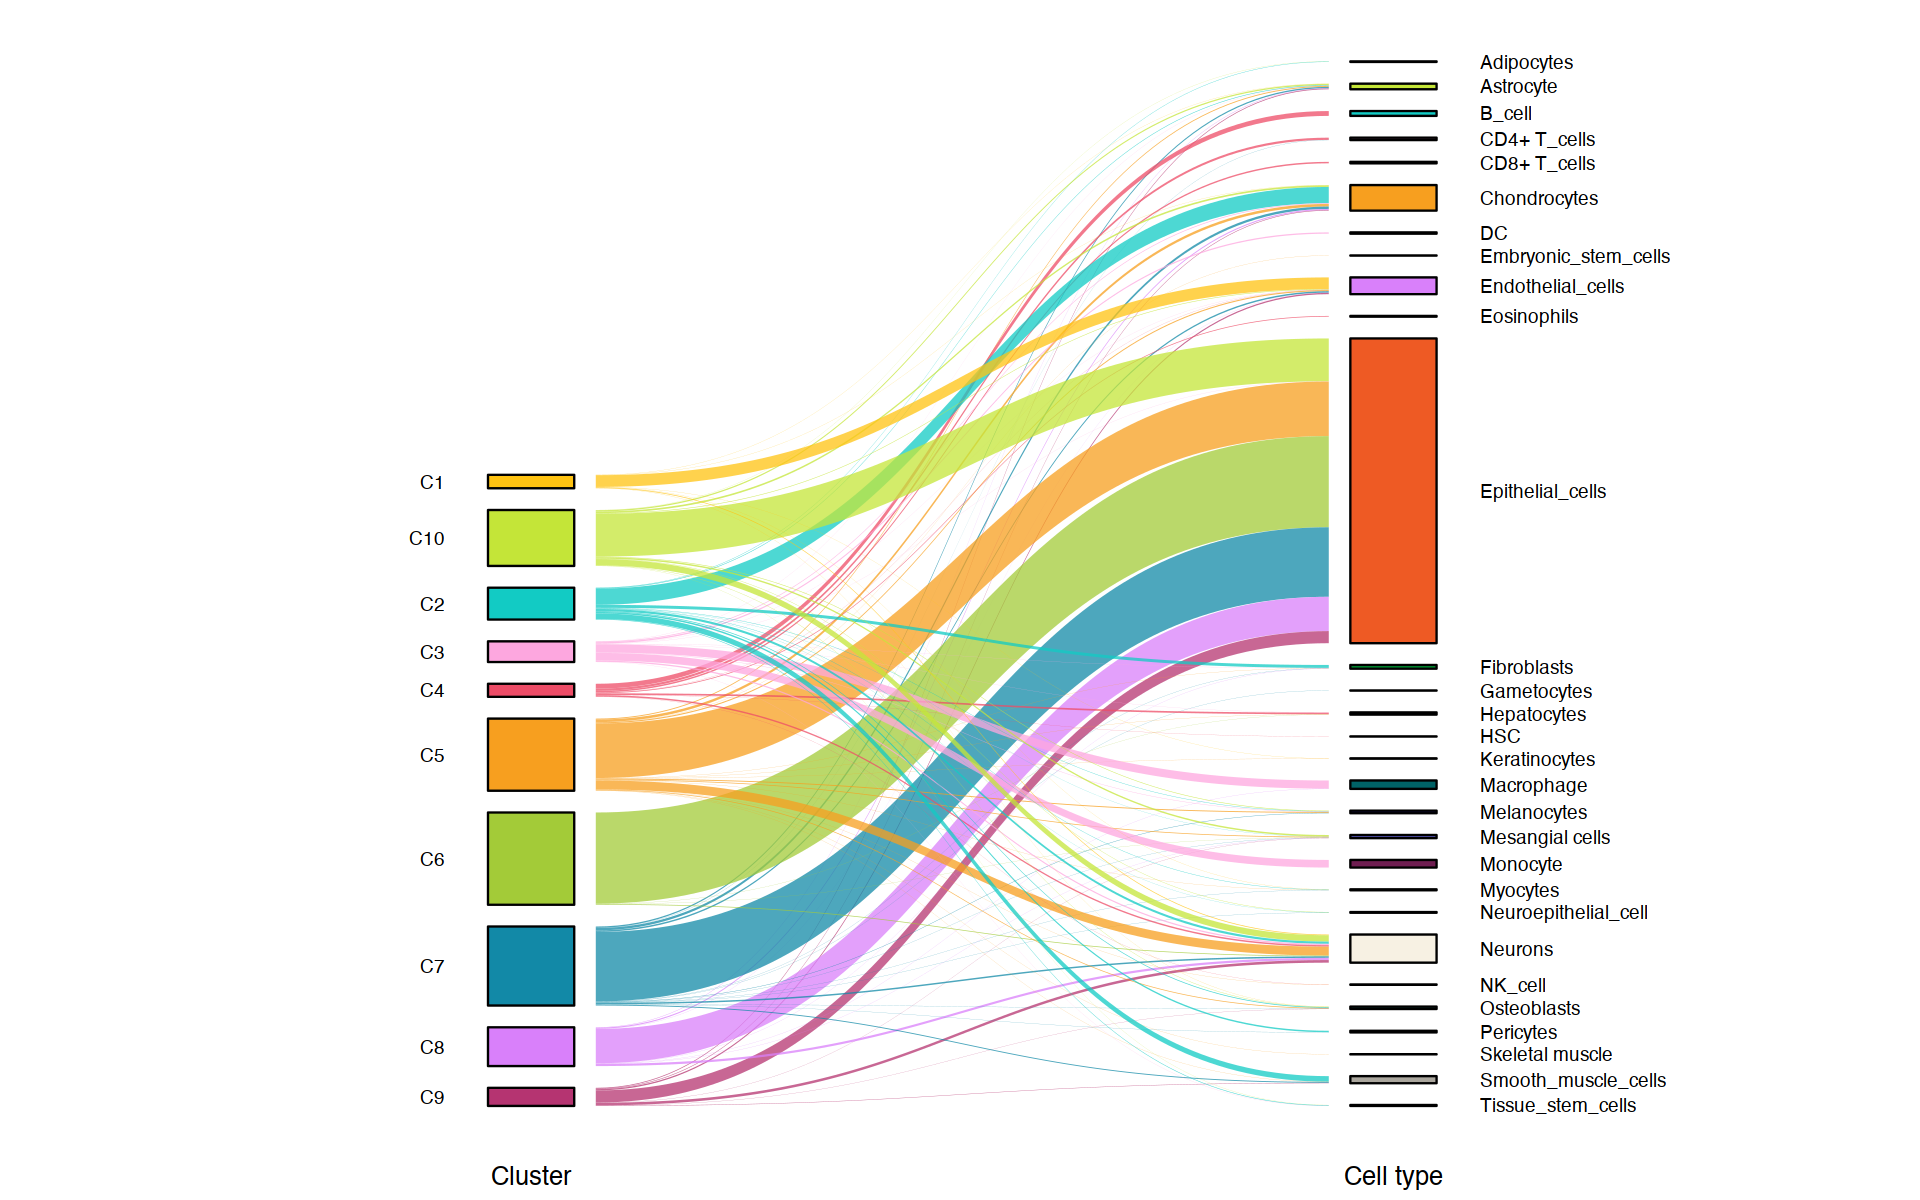

In [54]:
options(repr.plot.width=16, repr.plot.height=10)

geneScoreMatrix$Clusters <- as.factor(geneScoreMatrix$Clusters)

clusters <- levels(geneScoreMatrix$Clusters)
cell_types <- sort(unique(geneScoreMatrix$cellType))

color_assignments <- setNames(
  c(custom_colors$discrete[1:length(clusters)], custom_colors$discrete[1:length(cell_types)]),
  c(clusters,cell_types)
)

data <- as_tibble(colData(geneScoreMatrix)) %>%
  dplyr::rename(cell_type = cellType) %>%
  dplyr::mutate(cell_type = factor(cell_type, levels = cell_types)) %>%
  group_by(Clusters, cell_type) %>%
  tally() %>%
  ungroup() %>%
  gather_set_data(1:2) %>%
  dplyr::mutate(
    x = factor(x, levels = unique(x)),
    y = factor(y, levels = c(clusters,cell_types))
  )

data_labels <- tibble(
  group = c(
    rep('Clusters', length(clusters)),
    rep('cell_type', length(cell_types))
  )
) %>%
  mutate(
    hjust = ifelse(group == 'Clusters', 1, 0),
    nudge_x = ifelse(group == 'Clusters', -0.1, 0.1)
  )
p2 <- ggplot(data, aes(x, id = id, split = y, value = n)) +
  geom_parallel_sets(aes(fill = Clusters), alpha = 0.75, axis.width = 0.15) +
  geom_parallel_sets_axes(aes(fill = y), color = 'black', axis.width = 0.1) +
  geom_text(
    aes(y = n, split = y), stat = 'parallel_sets_axes', fontface = 'bold',
    hjust = data_labels$hjust, nudge_x = data_labels$nudge_x
  ) +
  scale_x_discrete(labels = c('Cluster','Cell type')) +
  scale_fill_manual(values = color_assignments) +
  theme_bw() +
  theme(
    legend.position = 'none',
    axis.title = element_blank(),
    axis.text.x = element_text(face = 'bold', colour = 'black', size = 15),
    axis.text.y = element_blank(),
    axis.ticks = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank()
  )
p2

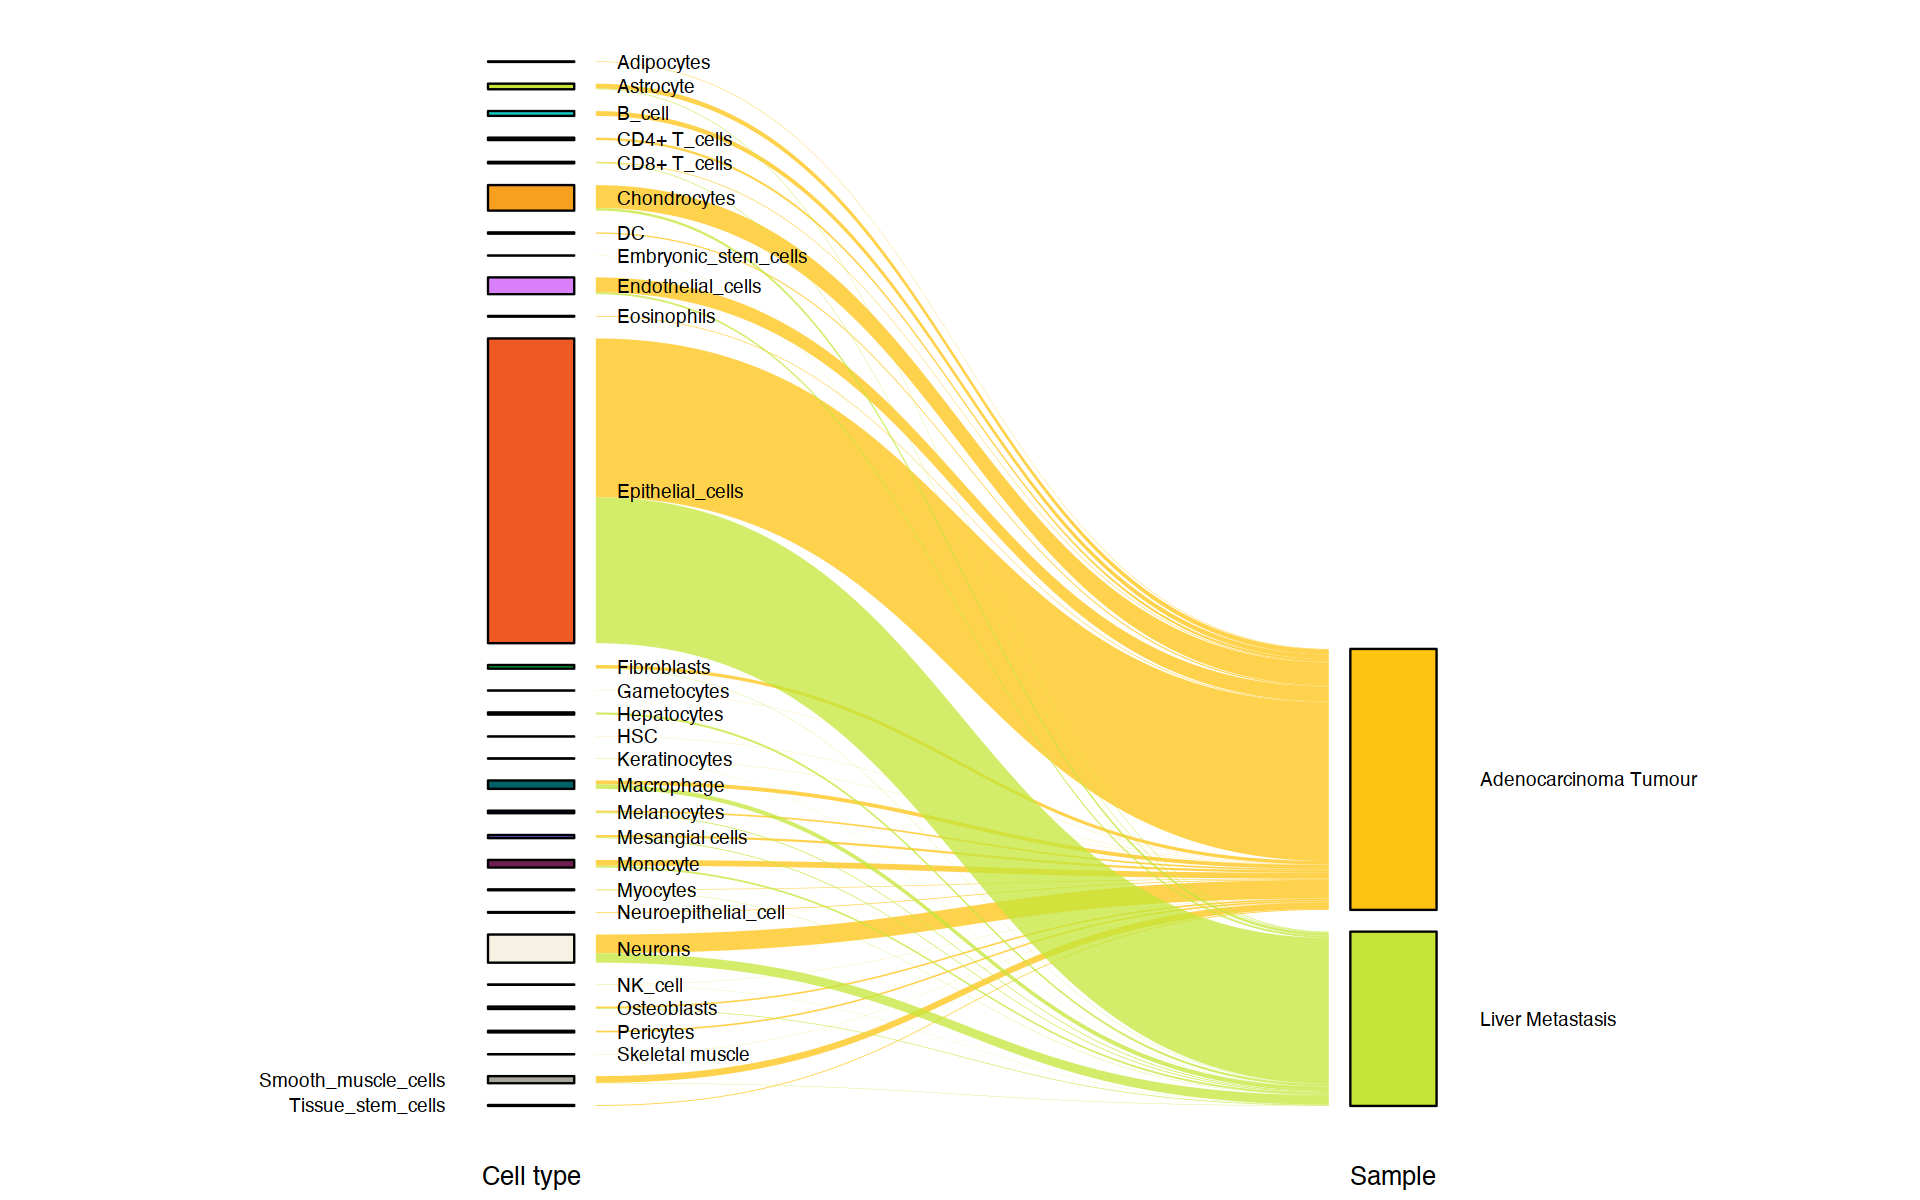

In [55]:
geneScoreMatrix$Sample <- as.factor(geneScoreMatrix$Sample)

Sample <- levels(geneScoreMatrix$Sample)
cell_types <- sort(unique(geneScoreMatrix$cellType))

color_assignments <- setNames(
  c(custom_colors$discrete[1:length(Sample)], custom_colors$discrete[1:length(cell_types)]),
  c(Sample,cell_types)
)

data <- as_tibble(colData(geneScoreMatrix)) %>%
  dplyr::rename(cell_type = cellType) %>%
  dplyr::mutate(cell_type = factor(cell_type, levels = cell_types)) %>%
  group_by(Sample, cell_type) %>%
  tally() %>%
  ungroup() %>%
  gather_set_data(1:2) 

data_labels <- tibble(
  group = c(
    rep('Sample', length(Sample)),
    rep('cell_type', length(cell_types))
  )
) %>%
  mutate(
    hjust = ifelse(group == 'Sample', 1, 0),
    nudge_x = ifelse(group == 'Sample', -0.1, 0.1)
  )

p2 <- ggplot(data, aes(x, id = id, split = y, value = n)) +
  geom_parallel_sets(aes(fill = Sample), alpha = 0.75, axis.width = 0.15) +
  geom_parallel_sets_axes(aes(fill = y), color = 'black', axis.width = 0.1) +
  geom_text(
    aes(y = n, split = y), stat = 'parallel_sets_axes', fontface = 'bold',
    hjust = data_labels$hjust, nudge_x = data_labels$nudge_x
  ) +
  scale_x_discrete(labels = c('Cell type','Sample')) +
  scale_fill_manual(values = color_assignments) +
  theme_bw() +
  theme(
    legend.position = 'none',
    axis.title = element_blank(),
    axis.text.x = element_text(face = 'bold', colour = 'black', size = 15),
    axis.text.y = element_blank(),
    axis.ticks = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank()
  )
p2

# Pseudotime analysis

Pseudotime analysis will be interesting when performed on primary sample alone with emphasis on clusters 7-10. From looking at the presence and absence of amplifications by browser track alone an estimation of this can be made. CREB3L1 is amplified in all 4 clusters, EGFR in C7 and FGFR2 in C8. Perhaps C10 gives rise to C7 and C9 which then gives rise to C8. It would be interesting to have a more in depth attempt at this, both with amplifications included and excluded from the analysis. Pseudotime analysis would also be interesting when including the metastatic sample looking at the development of C5 & C6 including C7-10.

We will calculate trajectory for Cluster 10 -> 7 -> 9 -> 8

In [7]:
table(chrisAggrproj$Clusters)


 C1 C10  C2  C3  C4  C5  C6  C7  C8  C9 
 72 300 171 111  70 387 495 424 208  97 

In [8]:
trajectory <- c("C10", "C7", "C9", "C8")
trajectory

[1] "C10" "C7"  "C9"  "C8"

We use the `addTrajectory()` function to create a trajectory and we add this to our `ArchRProject`. We will call this trajectory “Paranchymal_Trajectory”. What this does is it creates a new column in `cellColData` called “Paranchymal_Trajectory” that stores the pseudo-time value for each cell in the trajectory. Cells that are not part of the trajectory are labeled with `NA`.

In [9]:
chrisAggrproj <- addTrajectory(
    ArchRProj = chrisAggrproj, 
    name = "Trajectory", 
    groupBy = "Clusters",
    trajectory = trajectory, 
    embedding = "UMAP", 
    force = TRUE
)

ArchR logging to : ArchRLogs/ArchR-addTrajectory-14302522c96af-Date-2021-05-01_Time-12-45-52.log
If there is an issue, please report to github with logFile!

Filtering outliers

Initial Alignment Before Spline Fit

Spline Fit

KNN to Spline

ArchR logging successful to : ArchRLogs/ArchR-addTrajectory-14302522c96af-Date-2021-05-01_Time-12-45-52.log



To plot this trajectory, we use the `plotTrajectory()` function which overlays the pseudo-time values on our UMAP embedding and displays an arrow approximating the trajectory path from the spline-fit. Cells that are not part of the trajectory are colored gray. In this example, we use `colorBy = "cellColData"` to tell ArchR to look within `cellColData` for the column specified by name - in this case, the “Paranchymal_Trajectory” pseudo-time trajectory. While it may seem conterintuitive to list “Paranchymal_Trajectory” for both trajectory and name, this is done because trajectory tells ArchR which subset of cells we are interested in and name tells ArchR how to color that subset of cells.

In [10]:
p <- plotTrajectory(chrisAggrproj, 
                    trajectory = "Trajectory", 
                    colorBy = "cellColData", 
                    name = "Trajectory")

ArchR logging to : ArchRLogs/ArchR-plotTrajectory-14302217205de-Date-2021-05-01_Time-12-46-54.log
If there is an issue, please report to github with logFile!

Plotting

Warning message:
“Removed 1409 rows containing non-finite values (stat_summary_hex).”
Plotting Trajectory

Adding Inferred Arrow Trajectory to Plot

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectory-14302217205de-Date-2021-05-01_Time-12-46-54.log



Warning message:
“Removed 1409 rows containing non-finite values (stat_summary_hex).”


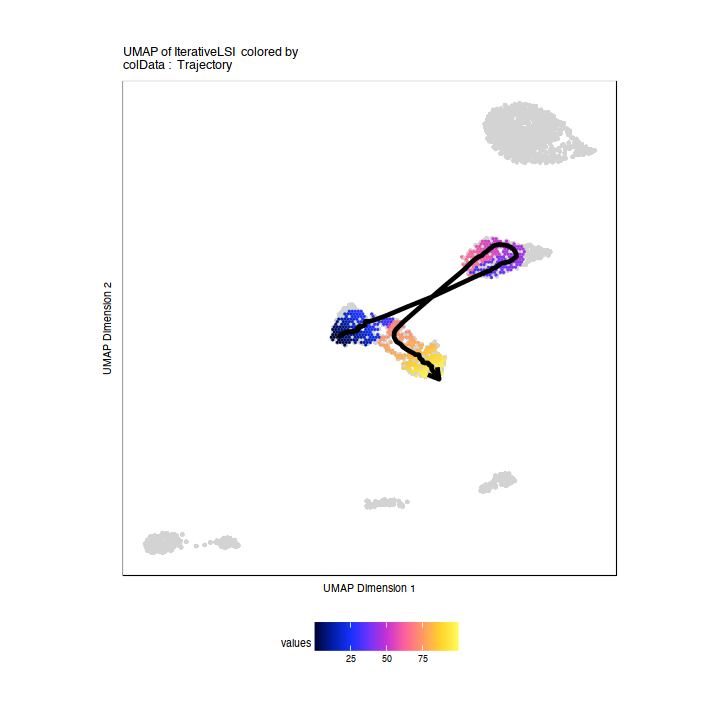

In [11]:
options(repr.plot.width=6, repr.plot.height=6)
p[[1]]

In [12]:
plotPDF(p, 
        name = "Traj-UMAP.pdf", 
        ArchRProj = chrisAggrproj, 
        addDOC = FALSE, 
        width = 7, height = 7)

Plotting Ggplot!

Warning message:
“Removed 1409 rows containing non-finite values (stat_summary_hex).”
Warning message:
“Removed 1409 rows containing non-finite values (stat_summary_hex).”
Plotting Ggplot!

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



In [14]:
p1 <- plotTrajectory(chrisAggrproj, 
                     trajectory = "Trajectory", 
                     colorBy = "GeneScoreMatrix", 
                     name = "CREB3L1", 
                     continuousSet = "horizonExtra")

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotTrajectory-1430266c8d054-Date-2021-05-01_Time-12-49-09.log
If there is an issue, please report to github with logFile!

Getting Matrix Values...

2021-05-01 12:49:09 : 

1 
2 


Imputing Matrix

Using weights on disk

1 of 1

Plotting

Warning message:
“Removed 1409 rows containing non-finite values (stat_summary_hex).”
Plotting Trajectory

Adding Inferred Arrow Trajectory to Plot

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectory-1430266c8d054-Date-2021-05-01_Time-12-49-09.log



Warning message:
“Removed 1409 rows containing non-finite values (stat_summary_hex).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'



[[1]]

[[2]]


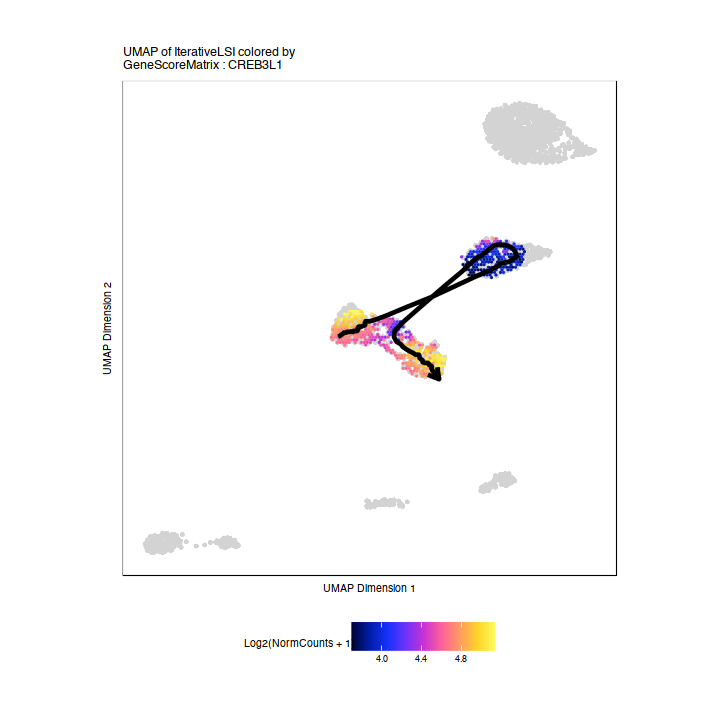

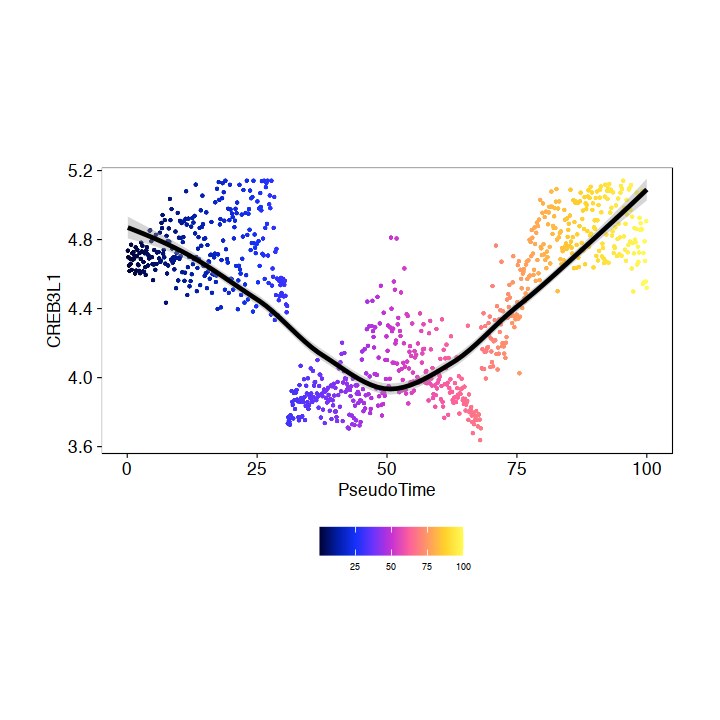

In [15]:
p1

In [16]:
plotPDF(p1, 
        name = "Plot-CREB3L1-Traj-UMAP.pdf", 
        ArchRProj = chrisAggrproj, 
        addDOC = FALSE, 
        width = 7, height = 7)

Plotting Ggplot!

Warning message:
“Removed 1409 rows containing non-finite values (stat_summary_hex).”
Warning message:
“Removed 1409 rows containing non-finite values (stat_summary_hex).”
Plotting Ggplot!

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



### Pseudo-time heatmaps

We can visualize changes in many features across pseudo-time using heatmaps. To do this, we first retrieve the trajectory of interest from the ArchRProject using the `getTrajectory()` function which returns the trajectory as a `SummarizedExperiment` object. We will create these pseudo-time heatmaps for motifs, gene scores, gene expression, and peak accessibility by passing the corresponding matrix to the `useMatrix` parameter.

In [53]:
getAvailableMatrices(chrisAggrproj)

[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

In [62]:
trajMM  <- getTrajectory(ArchRProj = chrisAggrproj, 
                         name = "Trajectory", 
                         useMatrix = "MotifMatrix", 
                         log2Norm = FALSE)

Creating Trajectory Group Matrix..

Some values are below 0, this could be a DeviationsMatrix in which scaleTo should be set = NULL.
Continuing without depth normalization!

Smoothing...



In [65]:
p1 <- plotTrajectoryHeatmap(trajMM, 
                            maxFeatures=5000, 
                            labelTop=100, 
                            pal = 
                            paletteContinuous(set = "solarExtra"))

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1430235507f6e-Date-2021-05-01_Time-13-45-15.log
If there is an issue, please report to github with logFile!

useSeqnames is NULL or greater than 1 with a Sparse.Assays.Matrix trajectory input.

2021-05-01 13:45:15 : 

force=FALSE thus continuing with subsetting useSeqnames = z

2021-05-01 13:45:15 : 

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1430235507f6e-Date-2021-05-01_Time-13-45-15.log



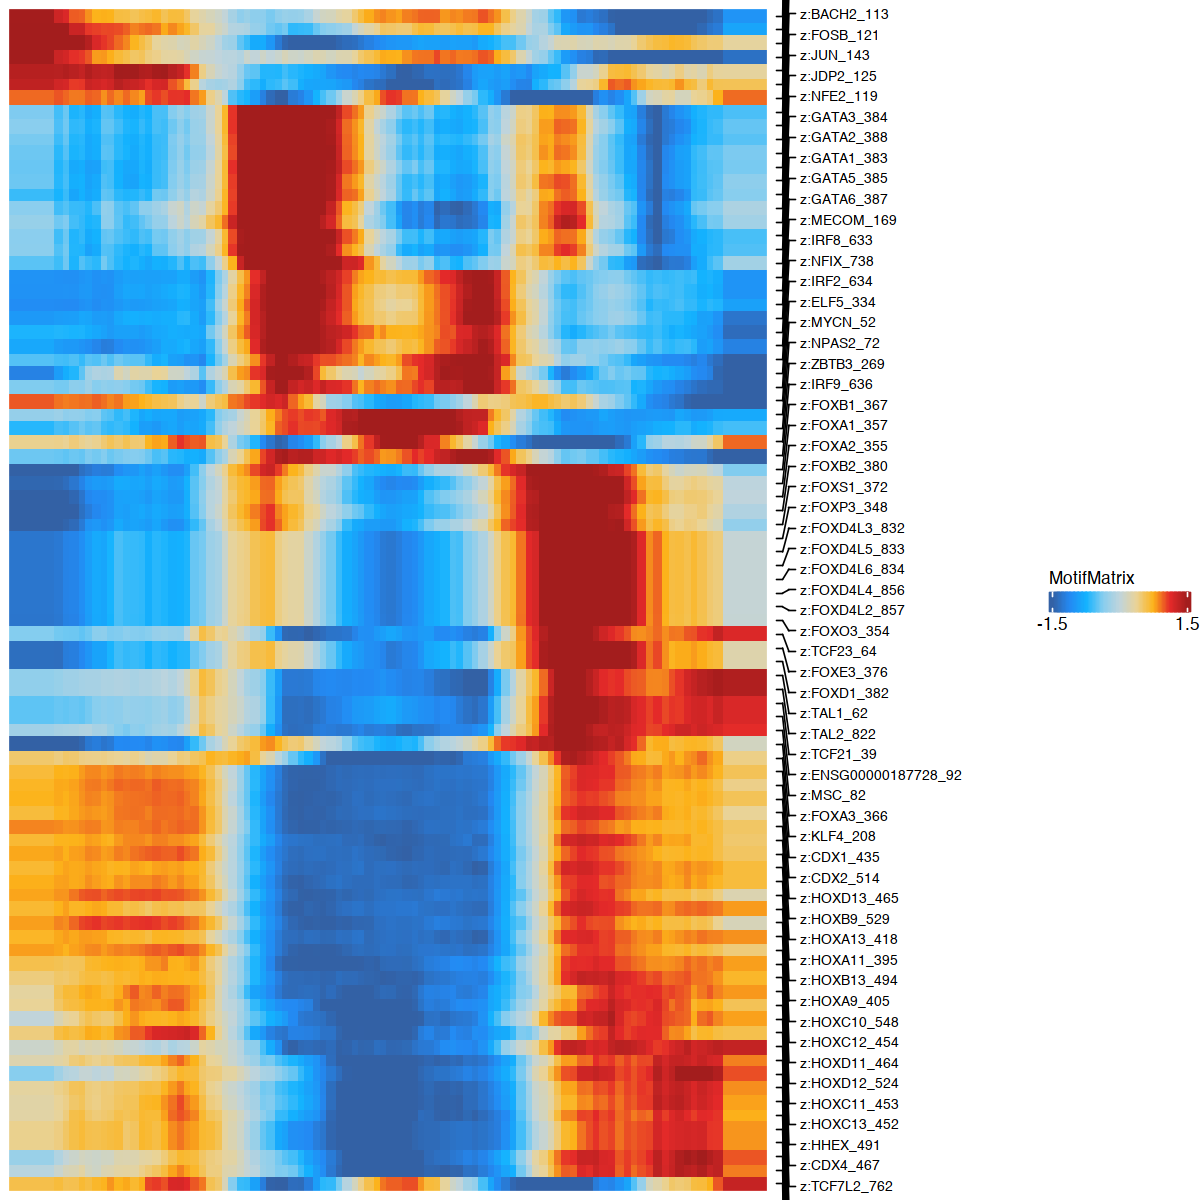

In [66]:
p1

In [67]:
plotPDF(p1, 
        name = "Plot-traj-motif-heatmap.pdf", 
        ArchRProj = chrisAggrproj, 
        addDOC = FALSE, 
        width = 7, height = 10)

Plotting ComplexHeatmap!



In [68]:
trajGSM <- getTrajectory(ArchRProj = chrisAggrproj, 
                         name = "Trajectory", 
                         useMatrix = "GeneScoreMatrix", 
                         log2Norm = TRUE)

Creating Trajectory Group Matrix..

Smoothing...



In [89]:
p2 <- plotTrajectoryHeatmap(trajGSM, 
                            maxFeatures=5000, 
                            labelTop=100, 
                            pal = paletteContinuous(set = "horizonExtra"))

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-14302793d0a08-Date-2021-05-01_Time-13-46-44.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-14302793d0a08-Date-2021-05-01_Time-13-46-44.log



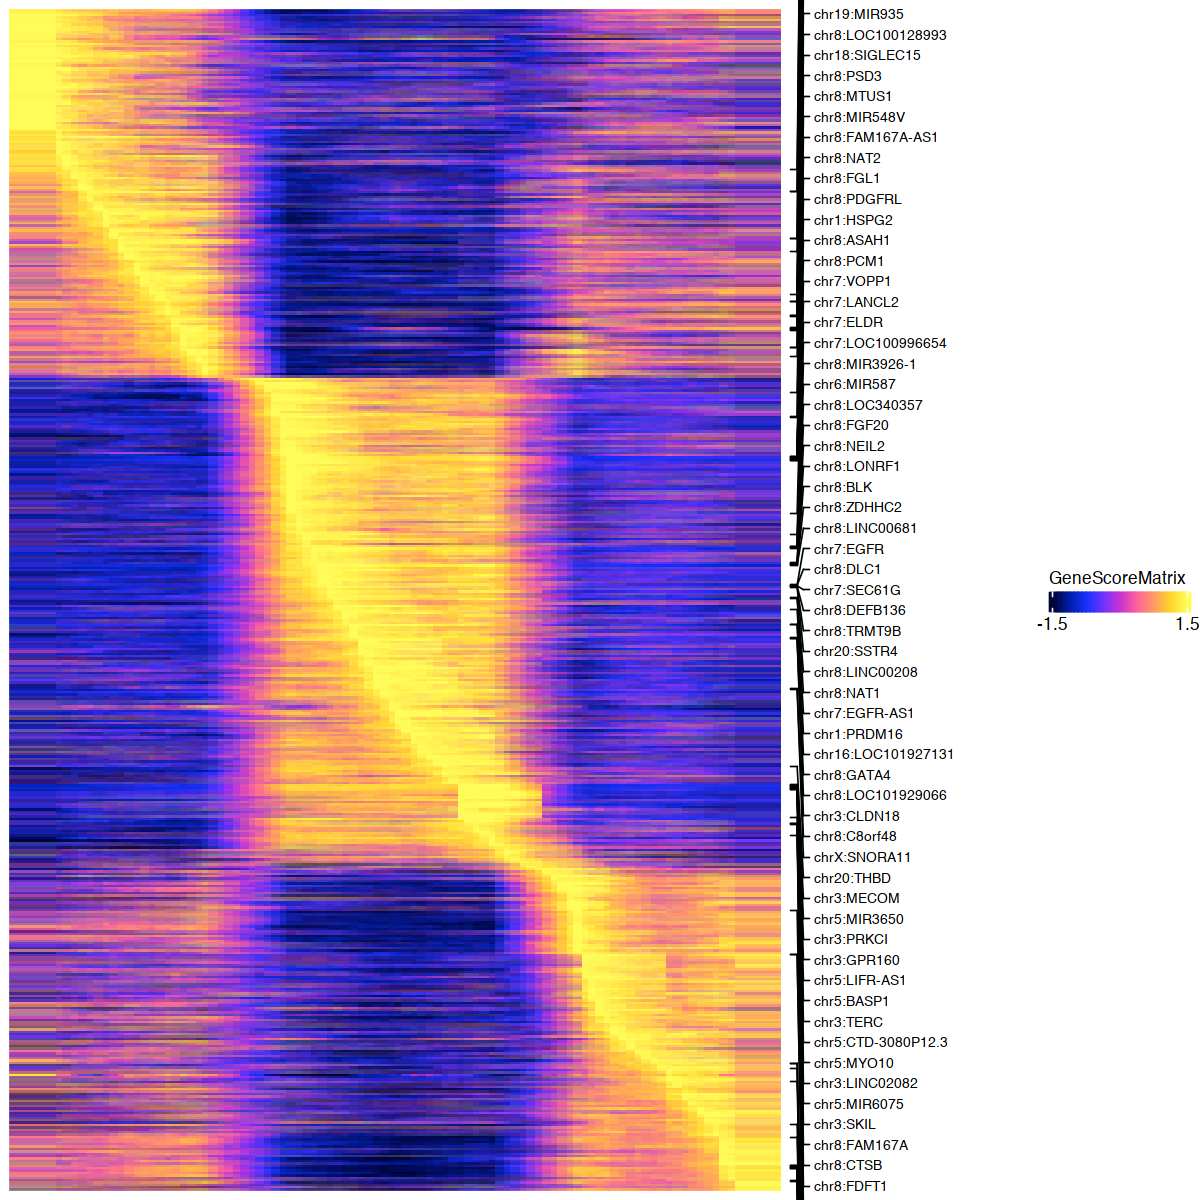

In [70]:
p2

In [71]:
plotPDF(p2, 
        name = "Plot-traj-genes-heatmap.pdf", 
        ArchRProj = chrisAggrproj, 
        addDOC = FALSE, 
        width = 7, height = 10)

Plotting ComplexHeatmap!



In [72]:
trajPM  <- getTrajectory(ArchRProj = chrisAggrproj, 
                         name = "Trajectory", 
                         useMatrix = "PeakMatrix", 
                         log2Norm = TRUE)

Creating Trajectory Group Matrix..

Smoothing...



In [73]:
p4 <- plotTrajectoryHeatmap(trajPM,  
                            maxFeatures=5000, labelTop=100, 
                            pal = paletteContinuous(set = "solarExtra"))

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1430257ca44f9-Date-2021-05-01_Time-13-48-22.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1430257ca44f9-Date-2021-05-01_Time-13-48-22.log



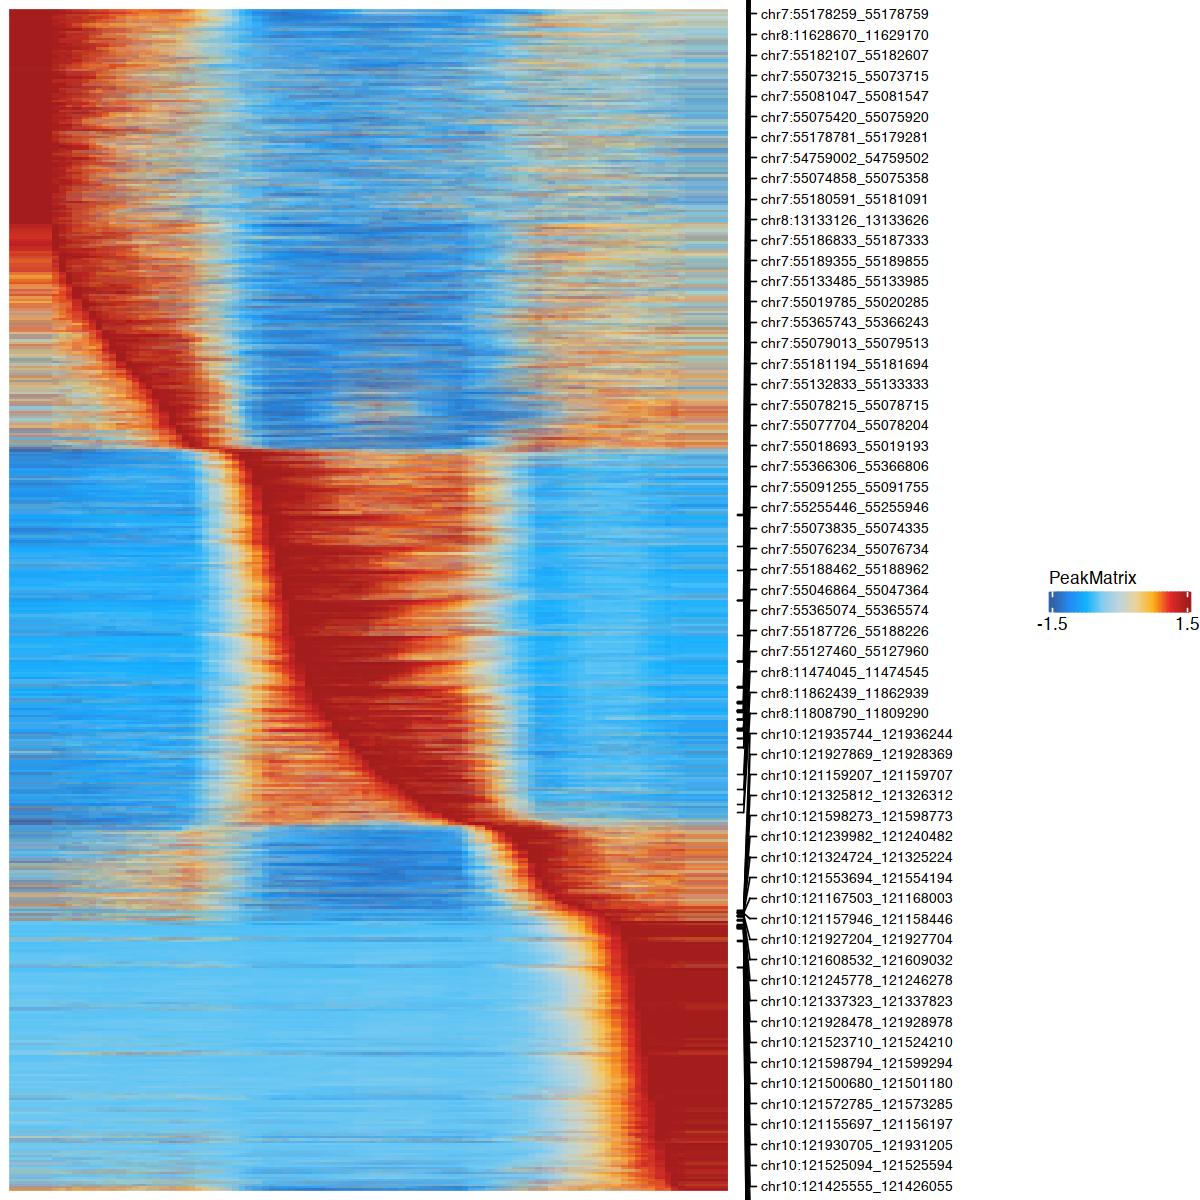

In [74]:
p4

In [75]:
plotPDF(p4, name = "Plot-traj-peaks-heatmap.pdf", 
        ArchRProj = chrisAggrproj, 
        addDOC = FALSE, 
        width = 7, height = 10)

Plotting ComplexHeatmap!



## Integrative pseudo-time analyses

We can also perform integrative analyses, such as identification of positive TF regulators by integration of gene scores / gene expression with motif accessibility across pseudo-time. This can be very powerful, for example in identifying drivers of differentiation. To do this, we use the `correlateTrajectories()` function which takes two `SummarizedExperiment` objects retrived from the `getTrajectories()` function.

First, lets find motifs whose accessibility across pseudo-time is correlated with the gene score of the TF gene.

In [76]:
corGSM_MM <- correlateTrajectories(trajGSM, trajMM, corCutOff = 0.5)

ArchR logging to : ArchRLogs/ArchR-correlateTrajectories-143024ed0ae0a-Date-2021-05-01_Time-13-49-23.log
If there is an issue, please report to github with logFile!

Found 12 Correlated Pairings!

2021-05-01 13:49:39 : 



In [77]:
corGSM_MM

List of length 4
names(4): correlatedMappings allMappings seTrajectory1 seTrajectory2

In [79]:
trajGSM_2 <- trajGSM[corGSM_MM[[1]]$name1, ]
trajMM_2 <- trajMM[corGSM_MM[[1]]$name2, ]

In [81]:
trajCombined <- trajGSM_2
assay(trajCombined) <- t(apply(assay(trajGSM_2), 1, scale)) + t(apply(assay(trajMM_2), 1, scale))

ERROR: Error in `assays<-`(`*tmp*`, withDimnames = withDimnames, ..., value = `*vtmp*`): please use 'assay(x, withDimnames=FALSE)) <- value' or 'assays(x,
  withDimnames=FALSE)) <- value' when the dimnames on the supplied
  assay(s) are not identical to the dimnames on SummarizedExperiment
  object 'x'


In [82]:
combinedMat <- plotTrajectoryHeatmap(trajCombined, returnMat = TRUE, varCutOff = 0)

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-14302711f5374-Date-2021-05-01_Time-13-50-54.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-14302711f5374-Date-2021-05-01_Time-13-50-54.log



In [83]:
rowOrder <- match(rownames(combinedMat), rownames(trajGSM_2))

In [84]:
ht1 <- plotTrajectoryHeatmap(trajGSM_2,  
                             pal = paletteContinuous(set = "horizonExtra"),  
                             varCutOff = 0, 
                             rowOrder = rowOrder)

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-143026200703f-Date-2021-05-01_Time-13-51-26.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-143026200703f-Date-2021-05-01_Time-13-51-26.log



In [85]:
ht2 <- plotTrajectoryHeatmap(trajMM_2, 
                             pal = paletteContinuous(set = "solarExtra"), 
                             varCutOff = 0, 
                             rowOrder = rowOrder)

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1430231adaab6-Date-2021-05-01_Time-13-51-47.log
If there is an issue, please report to github with logFile!

useSeqnames is NULL or greater than 1 with a Sparse.Assays.Matrix trajectory input.

2021-05-01 13:51:47 : 

force=FALSE thus continuing with subsetting useSeqnames = z

2021-05-01 13:51:47 : 

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-1430231adaab6-Date-2021-05-01_Time-13-51-47.log



In [87]:
plotPDF(ht1 + ht2, name = "Plot-traj-motif-geneintegration-correlated-heatmap.pdf", 
        ArchRProj = chrisAggrproj, 
        addDOC = FALSE, 
        width = 7, height = 10)

Plotting ComplexHeatmap!



In [88]:
chrisAggrproj <- saveArchRProject(ArchRProj = chrisAggrproj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

## Saving valid barcodes to extract reads from BAM files

In [5]:
chrisAggrproj <- loadArchRProject(path = "chrisAggrproj")

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [6]:
set.tileSize <- 500000
#set.binarize <- TRUE
set.binarize <- FALSE
current.proj.temp <- chrisAggrproj
current.proj.temp <- addTileMatrix(
input = current.proj.temp,
tileSize = set.tileSize,
binarize = set.binarize,
force = TRUE)

ArchR logging to : ArchRLogs/ArchR-addTileMatrix-150ad155895b8-Date-2021-05-28_Time-00-44-30.log
If there is an issue, please report to github with logFile!

2021-05-28 00:44:30 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

2021-05-28 00:44:38 : Adding TileMatrix to Liver Metastasis for Chr (1 of 23)!, 0.004 mins elapsed.

2021-05-28 00:44:41 : Adding TileMatrix to Liver Metastasis for Chr (2 of 23)!, 0.053 mins elapsed.

2021-05-28 00:44:43 : Adding TileMatrix to Liver Metastasis for Chr (3 of 23)!, 0.087 mins elapsed.

2021-05-28 00:44:45 : Adding TileMatrix to Liver Metastasis for Chr (4 of 23)!, 0.116 mins elapsed.

2021-05-28 00:44:47 : Adding T

In [7]:
getAvailableMatrices(current.proj.temp)

[1] "GeneScoreMatrix" "MotifMatrix"     "PeakMatrix"      "TileMatrix"

In [8]:
tileMatrix <- getMatrixFromProject(current.proj.temp,'TileMatrix')

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-150ad540339ff-Date-2021-05-28_Time-00-45-57.log
If there is an issue, please report to github with logFile!

2021-05-28 00:46:02 : Organizing colData, 0.071 mins elapsed.

2021-05-28 00:46:02 : Organizing rowData, 0.072 mins elapsed.

2021-05-28 00:46:02 : Organizing Assays (1 of 1), 0.072 mins elapsed.

2021-05-28 00:46:02 : Constructing SummarizedExperiment, 0.074 mins elapsed.

2021-05-28 00:46:02 : Finished Matrix Creation, 0.081 mins elapsed.



In [9]:
tileMatrix

class: SummarizedExperiment 
dim: 6073 2335 
metadata(0):
assays(1): TileMatrix
rownames: NULL
rowData names(3): seqnames idx start
colnames(2335): Liver Metastasis#AACCGATCAGCGTCGT-1 Liver
  Metastasis#TACGCCTTCAGGAATA-1 ... Adenocarcinoma
  Tumour#AAGGAGCGTTCCTGTC-1 Adenocarcinoma Tumour#ATGTACGCACTCGGAC-1
colData names(19): BlacklistRatio DoubletEnrichment ... FRIP Trajectory

__There are 6073 tiles.__

In [10]:
tileMatrixCount <- assay(tileMatrix, 'TileMatrix')

In [15]:
tileMatrixCount[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
     Liver Metastasis#AACCGATCAGCGTCGT-1 Liver Metastasis#TACGCCTTCAGGAATA-1
[1,]                                   .                                   .
[2,]                                   .                                   .
[3,]                                 140                                 198
[4,]                                 122                                 132
[5,]                                 124                                 118
     Liver Metastasis#TAGCTTTGTAGCGGTA-1 Liver Metastasis#TTCGCGTAGGTCTTTG-1
[1,]                                   .                                   .
[2,]                                   .                                   .
[3,]                                 148                                 178
[4,]                                  94                                  54
[5,]                                 100                                  74
     Liver Metastasis#CCCTCTCTCTAAA

Adding the counts for each bean using `rowSums()` and identifying the median value for all the window read counts.

In [24]:
medianTile <- mad(rowSums(tileMatrixCount))
medianTile

[1] 16783.03

Identifying the tiles that have reads more than 3 fold higher than the median.

In [16]:
TilesToRem <- rowSums(tileMatrixCount) > 3*medianTile

In [17]:
sum(TilesToRem)

[1] 458

So there are 458 tiles to remove.

In [21]:
tileMatrixCount <- tileMatrixCount[!TilesToRem,]

In [23]:
dim(tileMatrixCount)

[1] 5615 2335

In [24]:
#assay(tileMatrix, 'TileMatrix') <- tileMatrixCount

In [29]:
validTilesDF <- rowData(tileMatrix)[!TilesToRem,]
validTilesDF$end <- validTilesDF$start + set.tileSize
validTilesDF

DataFrame with 5615 rows and 4 columns
     seqnames     idx     start       end
        <Rle> <array>   <array>   <array>
1        chr1       1         0     5e+05
2        chr1       2     5e+05     1e+06
3        chr1       6   2500000     3e+06
4        chr1       9     4e+06   4500000
5        chr1      10   4500000     5e+06
...       ...     ...       ...       ...
5611     chrX     309  1.54e+08 154500000
5612     chrX     310 154500000  1.55e+08
5613     chrX     311  1.55e+08 155500000
5614     chrX     312 155500000  1.56e+08
5615     chrX     313  1.56e+08 156500000

In [39]:
options(scipen=999)

In [42]:
validTilesDF <- validTilesDF[,c('seqnames','start','end')]
validTilesDF

DataFrame with 5615 rows and 3 columns
     seqnames     start       end
        <Rle>   <array>   <array>
1        chr1         0    500000
2        chr1    500000   1000000
3        chr1   2500000   3000000
4        chr1   4000000   4500000
5        chr1   4500000   5000000
...       ...       ...       ...
5611     chrX 154000000 154500000
5612     chrX 154500000 155000000
5613     chrX 155000000 155500000
5614     chrX 155500000 156000000
5615     chrX 156000000 156500000

In [44]:
write.table(validTilesDF, 'validTilesDF.csv', sep='\t', quote = FALSE, row.names = FALSE)

In [33]:
!bedtools intersect -a fragment_files/201209_fragments.tsv.gz -b validTilesDF.csv > 201209_validFragment.tsv

In [ ]:
!sort -V -k1,1 -k2,2 201209_validFragment.tsv > 201209_validFragment_sorted.tsv

Need to use `samtools` `bgzip` command to zip the file

In [ ]:
!bggzip 201209_validFragment.tsv

In [47]:
!bedtools intersect -a fragment_files/201216_fragments.tsv.gz -b validTilesDF.csv > 201216_validFragment.tsv

In [ ]:
!sort -V -k1,1 -k2,2 201216_validFragment.tsv > 201216_validFragment_sorted.tsv

In [ ]:
!bggzip 201216_validFragment.tsv

In [34]:
dim(dat_201209)

[1] 148793959         1

In [12]:
chrisAggrproj <- loadArchRProject(path = "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR/chrisAggrproj")

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [13]:
markerGenes  <- c(
    "SOX10",
"S100B",
"ERBB3",
"NOTCH1",
"NCAM1",
"VIP",
"SLC18A1",
    "EGFR",
    "HNF4A",
    "FGFR2",
    "GATA4",
    "GATA6"
  )

In [14]:
p <- plotBrowserTrack(
    ArchRProj = chrisAggrproj, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes, 
    upstream = 150000,
    downstream = 150000
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-231269988b5d-Date-2021-06-04_Time-11-19-29.log
If there is an issue, please report to github with logFile!

2021-06-04 11:19:29 : Validating Region, 0.003 mins elapsed.



GRanges object with 12 ranges and 2 metadata columns:
       seqnames              ranges strand |     gene_id      symbol
          <Rle>           <IRanges>  <Rle> | <character> <character>
   [1]    chr22   37970686-37987422      - |        6663       SOX10
   [2]    chr21   46598962-46605208      - |        6285       S100B
   [3]    chr12   56079857-56103505      + |        2065       ERBB3
   [4]     chr9 136494444-136545862      - |        4851      NOTCH1
   [5]    chr11 112961247-113278436      + |        4684       NCAM1
   ...      ...                 ...    ... .         ...         ...
   [8]     chr7   55019021-55256620      + |        1956        EGFR
   [9]    chr20   44355700-44434596      + |        3172       HNF4A
  [10]    chr10 121478334-121598458      - |        2263       FGFR2
  [11]     chr8   11676959-11760002      + |        2626       GATA4
  [12]    chr18   22169443-22202528      + |        2627       GATA6
  -------
  seqinfo: 24 sequences from hg38 genom

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 1 out-of-bound range located on sequence chr21.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 1 out-of-bound range located on sequence chr21.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.Genomic

In [20]:
options(repr.plot.width=16, repr.plot.height=6)

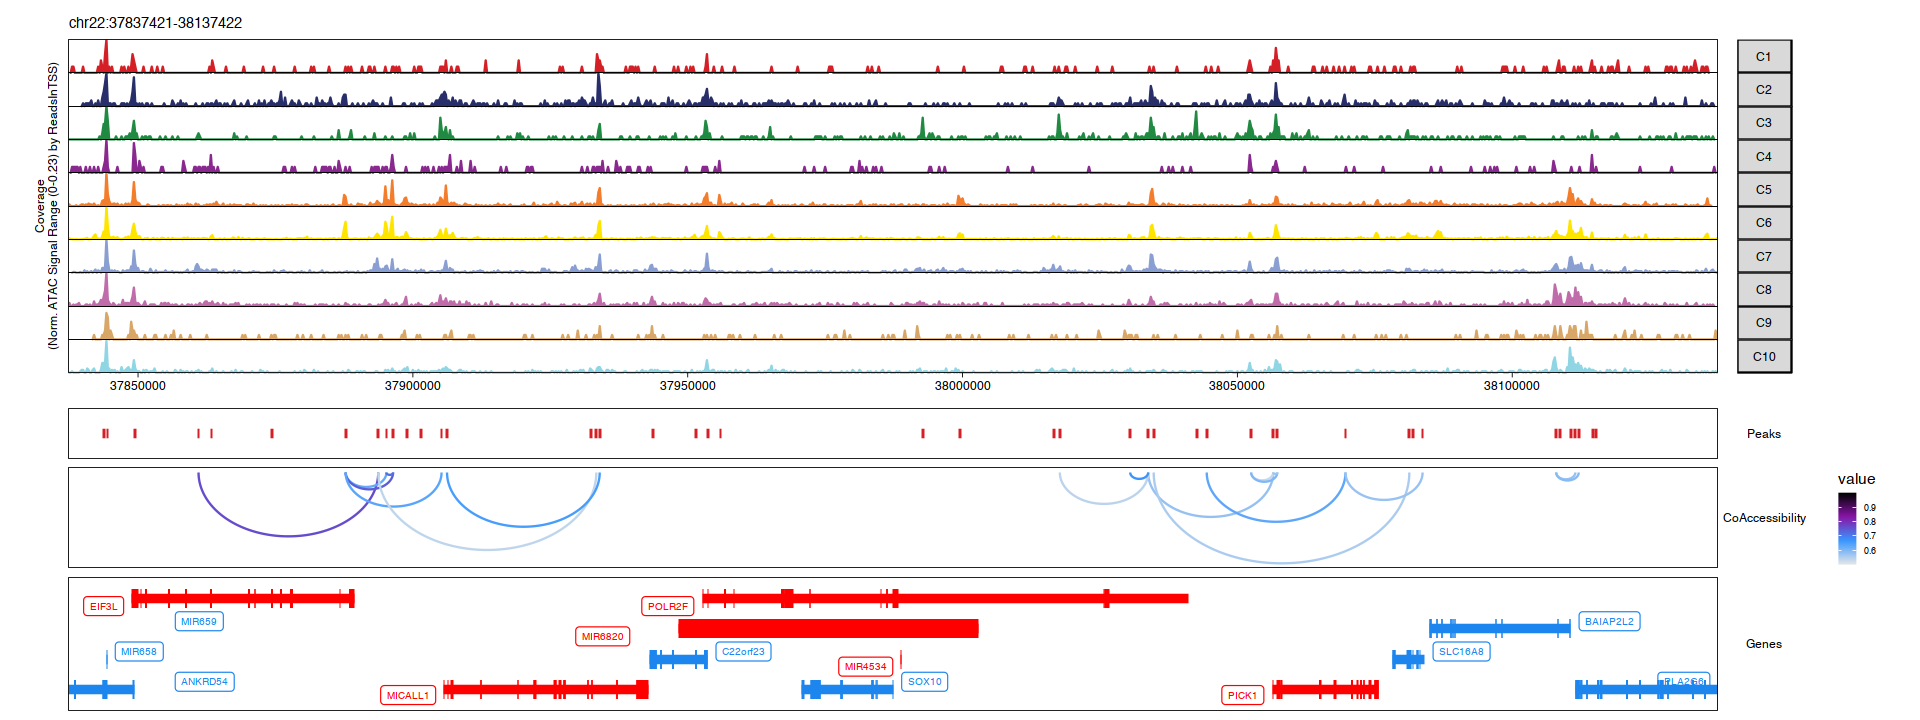

In [21]:
grid::grid.draw(p$SOX10)

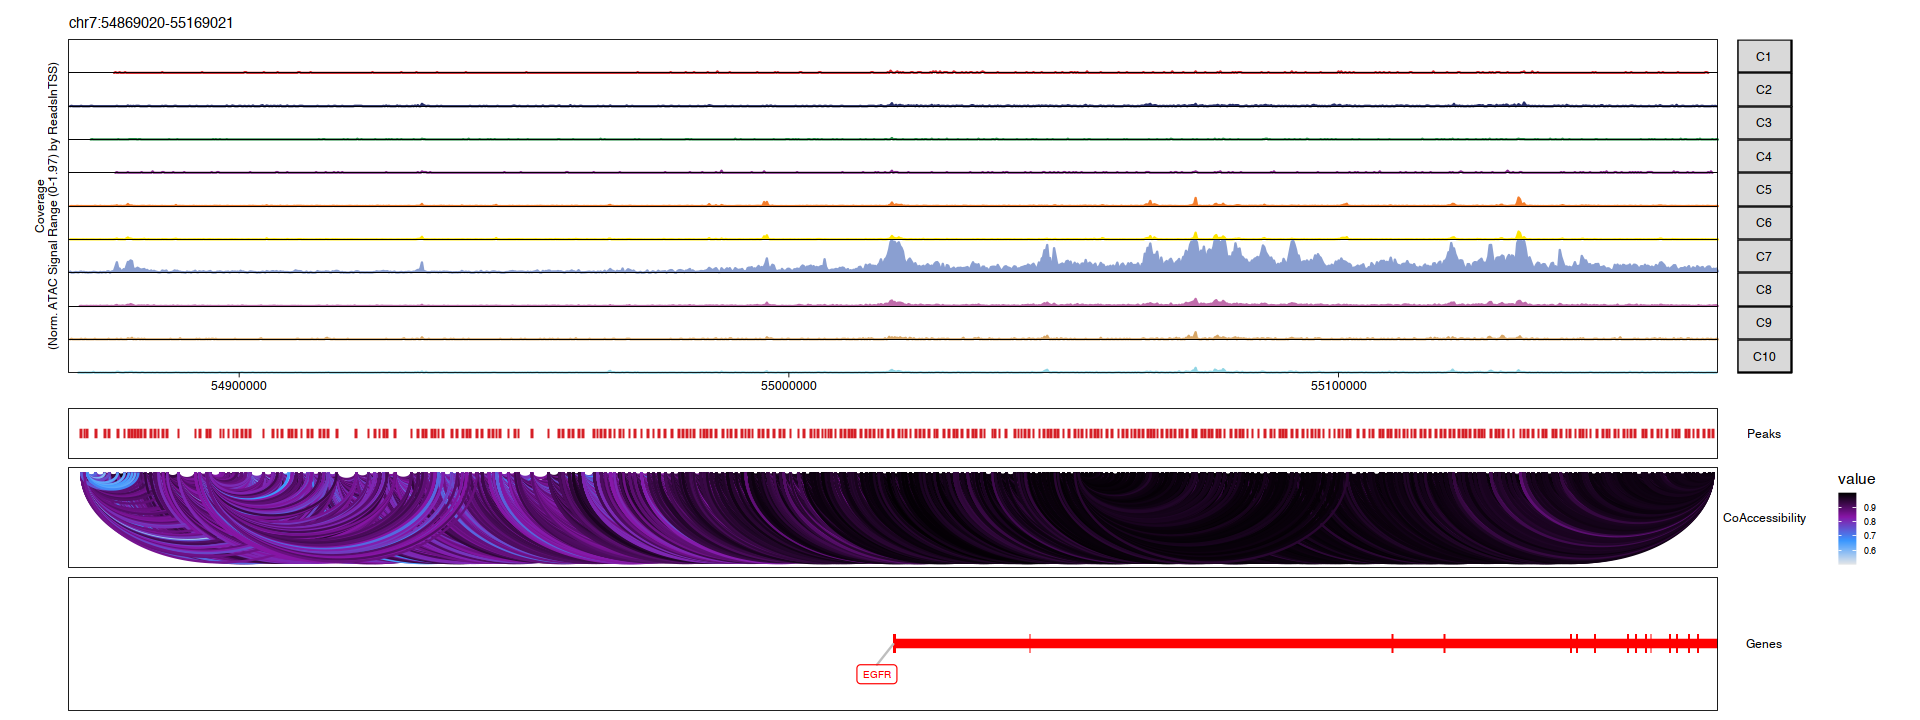

In [22]:
grid::grid.draw(p$EGFR)

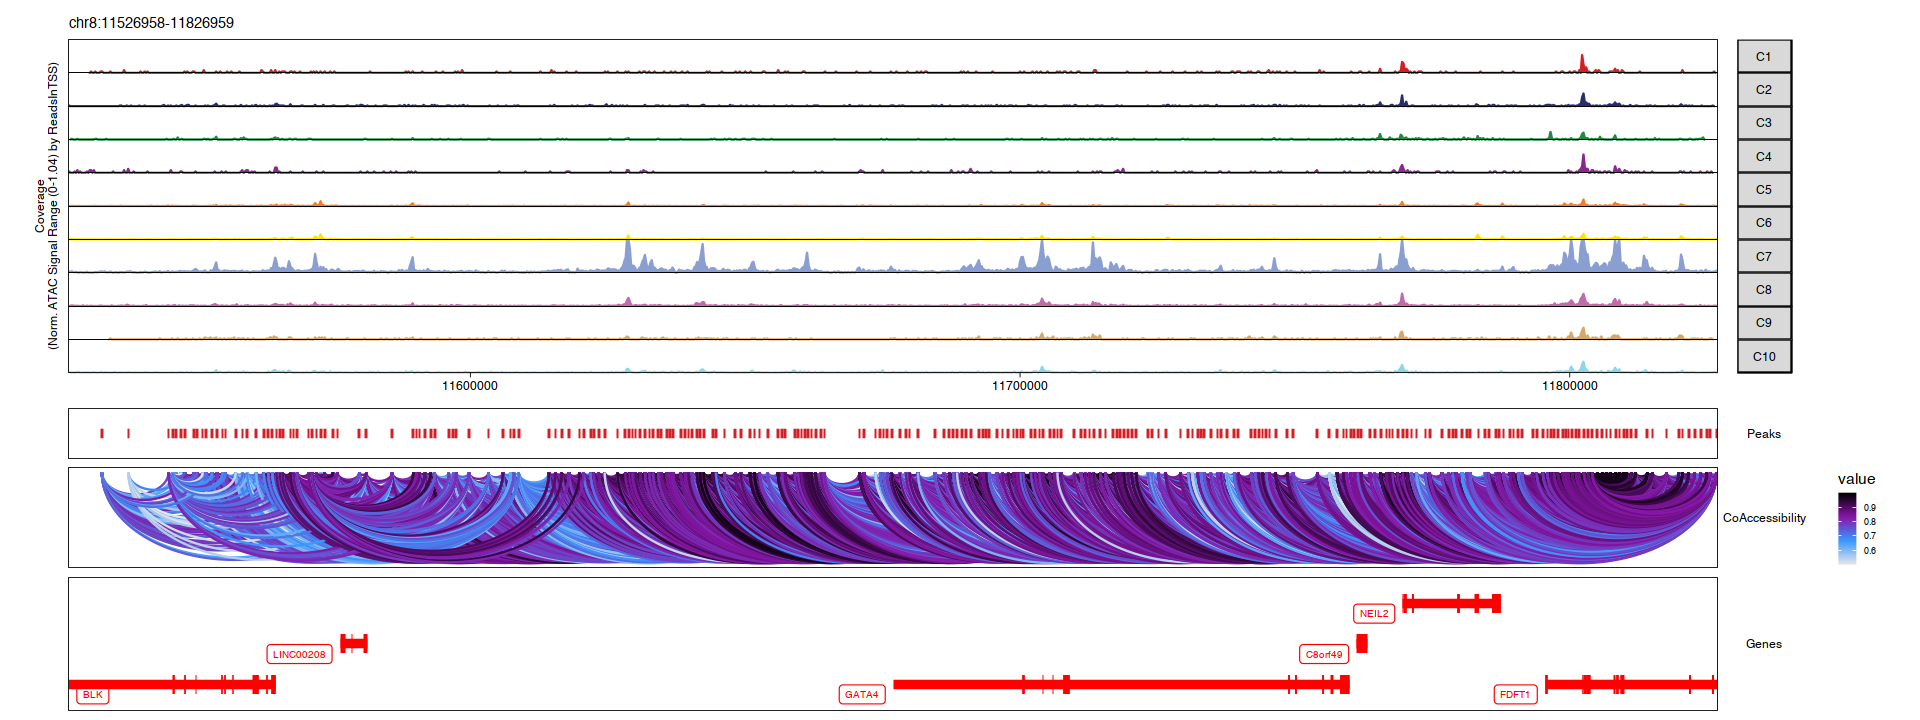

In [23]:
grid::grid.draw(p$GATA4)

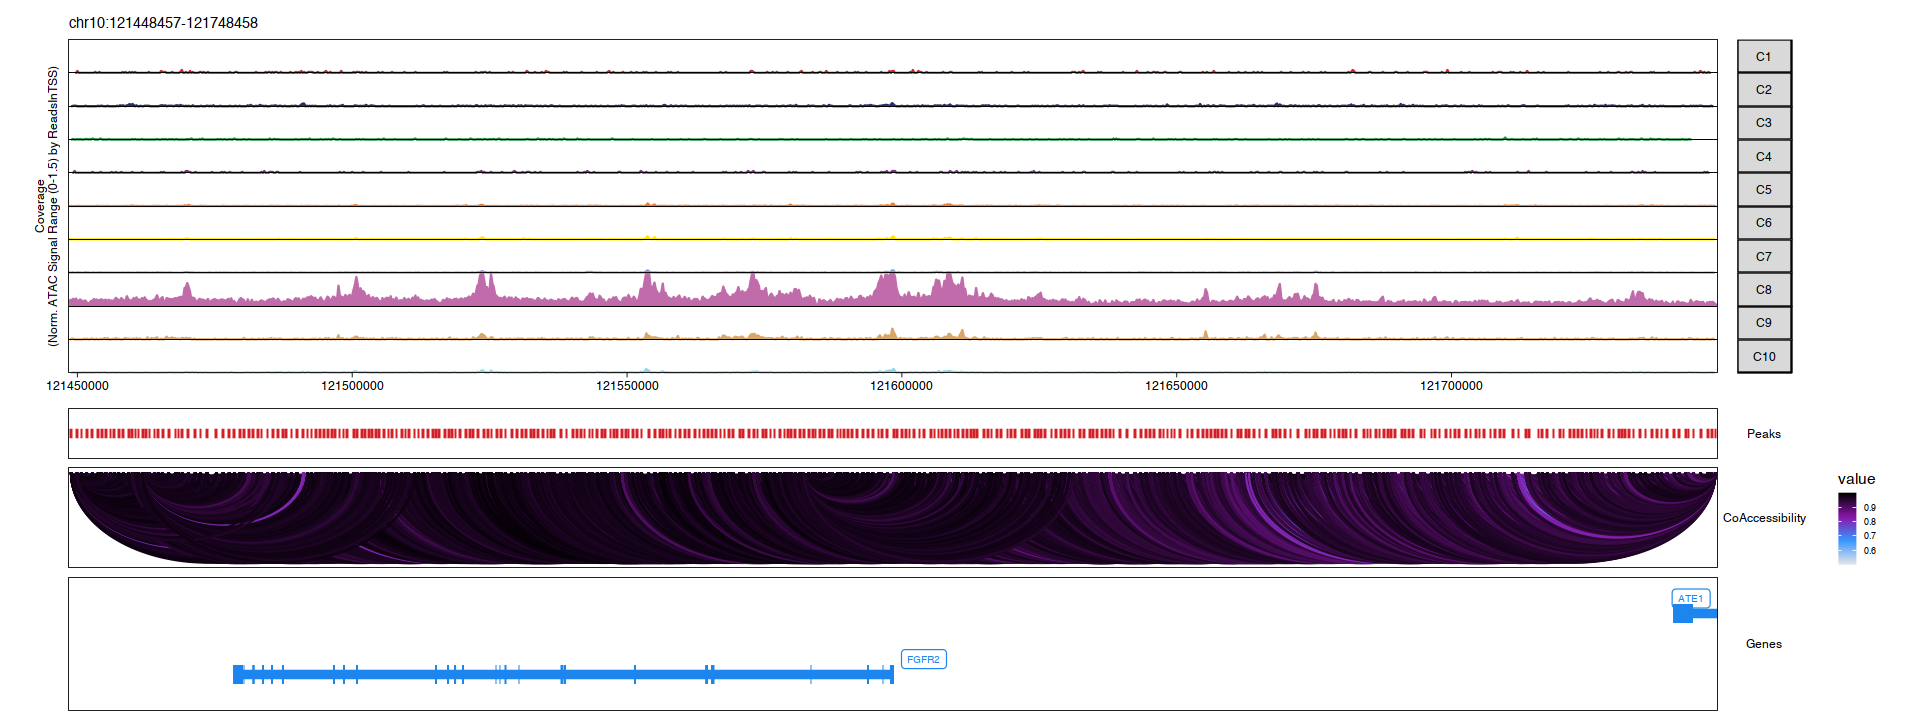

In [24]:
grid::grid.draw(p$FGFR2)

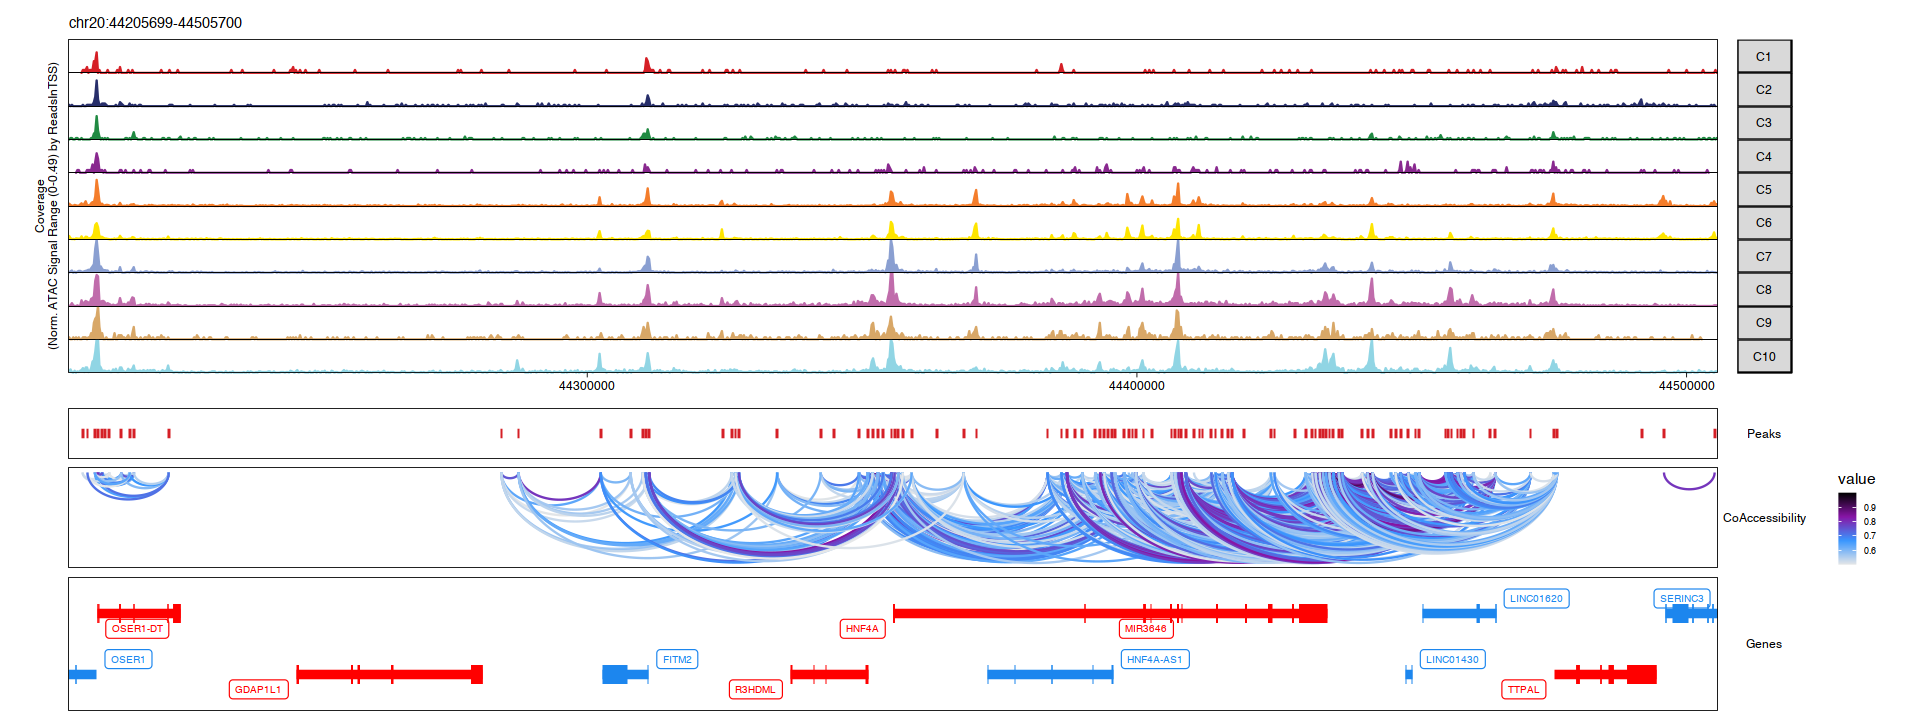

In [25]:
grid::grid.draw(p$HNF4A)

# Defining the cell type

In [11]:
geneScoreMatrix <- getMatrixFromProject(chrisAggrproj,'GeneScoreMatrix')
rownames(geneScoreMatrix) <- rowData(geneScoreMatrix)$name

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-522e5d72d9f7-Date-2021-06-21_Time-16-29-29.log
If there is an issue, please report to github with logFile!

2021-06-21 16:29:43 : Organizing colData, 0.242 mins elapsed.

2021-06-21 16:29:43 : Organizing rowData, 0.242 mins elapsed.

2021-06-21 16:29:43 : Organizing Assays (1 of 1), 0.242 mins elapsed.

2021-06-21 16:29:44 : Constructing SummarizedExperiment, 0.249 mins elapsed.

2021-06-21 16:29:44 : Finished Matrix Creation, 0.257 mins elapsed.



In [12]:
geneScoreMatrix

class: SummarizedExperiment 
dim: 24919 2335 
metadata(0):
assays(1): GeneScoreMatrix
rownames(24919): OR4F5 LOC729737 ... F8A2 TMLHE
rowData names(6): seqnames start ... name idx
colnames(2335): Liver Metastasis#AACCGATCAGCGTCGT-1 Liver
  Metastasis#TACGCCTTCAGGAATA-1 ... Adenocarcinoma
  Tumour#AAGGAGCGTTCCTGTC-1 Adenocarcinoma Tumour#ATGTACGCACTCGGAC-1
colData names(19): BlacklistRatio DoubletEnrichment ... FRIP Trajectory

In [14]:
mat <- assay(geneScoreMatrix, 'GeneScoreMatrix')
colnames(mat) <- gsub(' ','_',colnames(mat))
mat[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
             Liver_Metastasis#AACCGATCAGCGTCGT-1
OR4F5                                          .
LOC729737                                      .
LOC101928626                                   .
FAM87B                                         .
LINC01128                                      .
             Liver_Metastasis#TACGCCTTCAGGAATA-1
OR4F5                                      .    
LOC729737                                  .    
LOC101928626                               .    
FAM87B                                     .    
LINC01128                                  0.097
             Liver_Metastasis#TAGCTTTGTAGCGGTA-1
OR4F5                                      .    
LOC729737                                  .    
LOC101928626                               .    
FAM87B                                     .    
LINC01128                                  0.193
             Liver_Metastasis#TTCGCGTAGGTCTTTG-1
OR4F5                       

In [23]:
write.csv(t(mat),'GeneScoreMatrix.csv')

In [4]:
table(chrisAggrproj$Clusters)


 C1 C10  C2  C3  C4  C5  C6  C7  C8  C9 
 72 300 171 111  70 387 495 424 208  97 

In [17]:
dfClustAnnot <- data.frame(Clusters = chrisAggrproj$Clusters,
                          cellType = 'Adipose')
rownames(dfClustAnnot) <- colnames(mat)
head(dfClustAnnot)

Clusters cellType
Liver_Metastasis#AACCGATCAGCGTCGT-1 C8       Adipose 
Liver_Metastasis#TACGCCTTCAGGAATA-1 C9       Adipose 
Liver_Metastasis#TAGCTTTGTAGCGGTA-1 C8       Adipose 
Liver_Metastasis#TTCGCGTAGGTCTTTG-1 C7       Adipose 
Liver_Metastasis#CCCTCTCTCTAAACGC-1 C8       Adipose 
Liver_Metastasis#CATTGGAGTCATGAGG-1 C7       Adipose

In [19]:
dfClustAnnot[dfClustAnnot$Clusters %in% 'C2','cellType'] <- 'Fibroblast'
dfClustAnnot[dfClustAnnot$Clusters %in% 'C3','cellType'] <- 'Macrophage_monocyte'
dfClustAnnot[dfClustAnnot$Clusters %in% 'C4','cellType'] <- 'T_cell_B_cell'
dfClustAnnot[dfClustAnnot$Clusters %in% 'C5','cellType'] <- 'Metastat_OAD1'
dfClustAnnot[dfClustAnnot$Clusters %in% 'C6','cellType'] <- 'Metastat_OAD2'
dfClustAnnot[dfClustAnnot$Clusters %in% 'C7','cellType'] <- 'Primary_OAD1'
dfClustAnnot[dfClustAnnot$Clusters %in% 'C8','cellType'] <- 'Primary_OAD2'
dfClustAnnot[dfClustAnnot$Clusters %in% 'C9','cellType'] <- 'Primary_OAD3'
dfClustAnnot[dfClustAnnot$Clusters %in% 'C10','cellType'] <- 'Primary_OAD4'

In [20]:
head(dfClustAnnot)

Clusters cellType    
Liver_Metastasis#AACCGATCAGCGTCGT-1 C8       Primary_OAD2
Liver_Metastasis#TACGCCTTCAGGAATA-1 C9       Primary_OAD3
Liver_Metastasis#TAGCTTTGTAGCGGTA-1 C8       Primary_OAD2
Liver_Metastasis#TTCGCGTAGGTCTTTG-1 C7       Primary_OAD1
Liver_Metastasis#CCCTCTCTCTAAACGC-1 C8       Primary_OAD2
Liver_Metastasis#CATTGGAGTCATGAGG-1 C7       Primary_OAD1

In [22]:
write.csv(dfClustAnnot,'Cluster_annot.csv')

__I will create a python notebook now to create the `AnnData` object__

## Identifying the Amplification locations of genes (FGFR2 as example)

In [8]:
chrisAggrproj <- loadArchRProject(path = "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj")

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [9]:
getAvailableMatrices(chrisAggrproj)

[1] "GeneScoreMatrix" "MotifMatrix"     "PeakMatrix"      "TileMatrix"

# Extending the peak size to 50000 bp

In [43]:
pathToMacs2 <- findMacs2()

Searching For MACS2..

Found with $path!



In [126]:
chrisAggrproj <- addReproduciblePeakSet(
    ArchRProj = chrisAggrproj, 
    groupBy = "Clusters", 
    extendSummits = 25000,
    peakMethod = "Macs2",
    pathToMacs2 = pathToMacs2
)


ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-15f0d3fe07be1-Date-2021-08-10_Time-20-27-37.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2021-08-10 20:27:38 : Peak Calling Parameters!, 0.003 mins elapsed.



    Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
C1     C1     73         63           2   40   40    31500
C2     C2    168        168           2   40  128    84000
C3     C3    111        111           2   40   71    55500
C4     C4     71         62           2   40   40    31000
C5     C5    391        391           2   40  351   150000
C6     C6    491        491           2   40  451   150000
C7     C7    425        425           2   40  385   150000
C8     C8    208        208           2   40  168   104000
C9     C9    103        103           2   40   63    51500
C10   C10    294        294           2   40  254   147000


2021-08-10 20:27:38 : Batching Peak Calls!, 0.003 mins elapsed.

2021-08-10 20:27:38 : Batch Execution w/ safelapply!, 0 mins elapsed.

2021-08-10 20:27:38 : Group 1 of 20, Calling Peaks with MACS2!, 0 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name C1._.Rep1-1 --treatment /Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/InsertionBeds/C1._.Rep1-1.insertions.bed --outdir /Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/InsertionBeds --format BED --call-summits --keep-dup all --nomodel --nolambda --shift -75 --extsize 150 -q 0.1

2021-08-10 20:28:05 : Group 2 of 20, Calling Peaks with MACS2!, 0.456 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name C1._.Rep2-2 --treatment /Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/InsertionBeds/C1._.Rep2-2.insertions.bed --outdir /

2021-08-10 20:43:27 : Group 16 of 20, Calling Peaks with MACS2!, 15.831 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name C8._.Rep2-16 --treatment /Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/InsertionBeds/C8._.Rep2-16.insertions.bed --outdir /Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/InsertionBeds --format BED --call-summits --keep-dup all --nomodel --nolambda --shift -75 --extsize 150 -q 0.1

2021-08-10 20:44:15 : Group 17 of 20, Calling Peaks with MACS2!, 16.619 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name C9._.Rep1-17 --treatment /Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/InsertionBeds/C9._.Rep1-17.insertions.bed --outdir /Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/InsertionBeds --form

[1] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/C1-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/C10-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/C2-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/C3-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/C4-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/C5-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/C6-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/C7-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/C8-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/Users/mqbsxsm2/RNA-seq_Analysis/Christopher_Will_Bleaney_snATAC_ArchR_corrected/chrisAggrproj/PeakCalls/C9-reproduciblePeaks.gr.rds"


2021-08-10 20:50:03 : Creating Union Peak Set!, 22.429 mins elapsed.

Converged after 15 iterations!

Plotting Ggplot!

2021-08-10 20:50:21 : Finished Creating Union Peak Set (35877)!, 22.73 mins elapsed.



In [127]:
chrisAggrproj <- addPeakMatrix(chrisAggrproj, verbose=FALSE)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-15f0d34c6de4a-Date-2021-08-10_Time-20-50-21.log
If there is an issue, please report to github with logFile!

2021-08-10 20:50:21 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

Overriding previous entry for ReadsInPeaks

Overriding previous entry for FRIP

ArchR logging suc

In [128]:

peakMtx <- getMatrixFromProject(chrisAggrproj, useMatrix='PeakMatrix')
#peakMtx <- getMatrixFromProject(chrisAggrproj, useMatrix='TileMatrix')



ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-15f0d5e6bffec-Date-2021-08-10_Time-20-52-19.log
If there is an issue, please report to github with logFile!

2021-08-10 20:52:27 : Organizing colData, 0.137 mins elapsed.

2021-08-10 20:52:27 : Organizing rowData, 0.137 mins elapsed.

2021-08-10 20:52:27 : Organizing rowRanges, 0.137 mins elapsed.

2021-08-10 20:52:27 : Organizing Assays (1 of 1), 0.137 mins elapsed.

2021-08-10 20:52:27 : Constructing SummarizedExperiment, 0.143 mins elapsed.

2021-08-10 20:52:28 : Finished Matrix Creation, 0.155 mins elapsed.



In [129]:
peakMtx

class: RangedSummarizedExperiment 
dim: 35877 2335 
metadata(0):
assays(1): PeakMatrix
rownames: NULL
rowData names(1): idx
colnames(2335): Liver_Metastasis#AACCGATCAGCGTCGT-1
  Liver_Metastasis#TACGCCTTCAGGAATA-1 ...
  Adenocarcinoma_Tumour#AAGGAGCGTTCCTGTC-1
  Adenocarcinoma_Tumour#ATGTACGCACTCGGAC-1
colData names(18): BlacklistRatio DoubletEnrichment ... ReadsInPeaks
  FRIP

In [130]:
assay(peakMtx,'PeakMatrix')[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
     Liver_Metastasis#AACCGATCAGCGTCGT-1 Liver_Metastasis#TACGCCTTCAGGAATA-1
[1,]                                   .                                   .
[2,]                                   4                                   4
[3,]                                   4                                   4
[4,]                                   4                                   4
[5,]                                   4                                   4
     Liver_Metastasis#TAGCTTTGTAGCGGTA-1 Liver_Metastasis#TTCGCGTAGGTCTTTG-1
[1,]                                   2                                   2
[2,]                                   4                                   4
[3,]                                   4                                   4
[4,]                                   4                                   4
[5,]                                   4                                   4
     Liver_Metastasis#CCCTCTCTCTAAA

In [131]:
peakMtxBin <- assay(peakMtx,'PeakMatrix')

In [132]:
dim(peakMtxBin)

[1] 35877  2335

In [133]:
peakMtxBin[peakMtxBin>0]<-1

In [134]:
peakSet <- getPeakSet(chrisAggrproj)

In [135]:
head(peakSet)

GRanges object with 6 ranges and 13 metadata columns:
     seqnames          ranges strand |     score replicateScoreQuantile
        <Rle>       <IRanges>  <Rle> | <numeric>              <numeric>
  C2     chr1   802537-852537      * |   8.60663                  0.890
  C2     chr1   898796-948796      * |   8.60663                  0.890
  C5     chr1  999806-1049806      * |  38.97150                  0.996
  C7     chr1 1137793-1187793      * |  30.10920                  0.992
  C1     chr1 1207089-1257089      * |  25.23880                  0.990
  C7     chr1 1280721-1330721      * |  15.85470                  0.928
     groupScoreQuantile Reproducibility GroupReplicate distToGeneStart
              <numeric>       <numeric>    <character>       <integer>
  C2              0.803               2      C2._.Rep2              14
  C2              0.803               2      C2._.Rep2            1083
  C5              0.993               2      C5._.Rep2            4682
  C7           

In [136]:
peakSet[peakSet$nearestGene %in% 'EGFR',]

GRanges object with 3 ranges and 13 metadata columns:
     seqnames            ranges strand |     score replicateScoreQuantile
        <Rle>         <IRanges>  <Rle> | <numeric>              <numeric>
  C7     chr7 54908404-54958404      * |   349.109                  0.997
  C7     chr7 54993938-55043938      * |   740.276                  1.000
  C7     chr7 55049098-55099098      * | 13317.600                  1.000
     groupScoreQuantile Reproducibility GroupReplicate distToGeneStart
              <numeric>       <numeric>    <character>       <integer>
  C7              0.995               2      C7._.Rep1           85616
  C7              1.000               2      C7._.Rep2              82
  C7              1.000               2      C7._.Rep1           55076
     nearestGene    peakType distToTSS  nearestTSS        GC       idx
     <character> <character> <integer> <character> <numeric> <integer>
  C7        EGFR      Distal     85616  uc057etn.1    0.3798       725
  C7    

In [137]:
write.csv(peakSet[peakSet$nearestGene %in% 'EGFR',],'EGFR_peaks_50000BinSize.csv')

In [138]:
dim(peakSet)

NULL

In [139]:
peakSetDF <- data.frame(seqnames=seqnames(peakSet),
                        starts=start(peakSet)-1,
                        ends=end(peakSet),
                        GC=peakSet$GC,
                        score=peakSet$score,
                        nearestGene=peakSet$nearestGene,
                        peakType=peakSet$peakType,
                        idx=peakSet$idx,
                        totalFrag = rowSums(assay(peakMtx, 'PeakMatrix')),
                        avgInExpressed=rowSums(assay(peakMtx, 'PeakMatrix'))/rowSums(peakMtxBin))                        


In [140]:
peakSetDF

seqnames starts    ends      GC     score     nearestGene peakType idx 
1     chr1      802536    852537   0.4456   8.60663 LINC00115   Promoter  1  
2     chr1      898795    948796   0.6317   8.60663 SAMD11      Promoter  2  
3     chr1      999805   1049806   0.6312  38.97150 AGRN        Intronic  3  
4     chr1     1137792   1187793   0.6284  30.10920 MIR200B     Distal    4  
5     chr1     1207088   1257089   0.6351  25.23880 SDF4        Promoter  5  
6     chr1     1280720   1330721   0.6475  15.85470 PUSL1       Exonic    6  
7     chr1     1350355   1400356   0.5663  23.16580 AURKAIP1    Exonic    7  
8     chr1     1407062   1457063   0.5791  14.91370 LINC01770   Intronic  8  
9     chr1     1487104   1537105   0.5801  28.94550 ATAD3A      Promoter  9  
10    chr1     1590394   1640395   0.6182  34.07070 MIB2        Promoter 10  
11    chr1     1699458   1749459   0.5351  17.49740 CDK11A      Intronic 11  
12    chr1     1758143   1808144   0.5068  19.45820 NADK        Distal   12  
13    chr1     1833856   1883857   0.4645  25.72990 GNB1        Intronic 13  
14    chr1     1894367   1944368   0.5844  43.37730 TMEM52      Promoter 14  
15    chr1     1965458   2015459   0.5414   7.97457 CFAP74      Intronic 15  
16    chr1     2025237   2075238   0.5835  17.07150 PRKCZ       Promoter 16  
17    chr1     2108246   2158247   0.5520  32.02330 FAAP20      Intronic 17  
18    chr1     2202778   2252779   0.5900  41.18420 SKI         Promoter 18  
19    chr1     2276182   2326183   0.6144  21.60880 SKI         Intronic 19  
20    chr1     2336141   2386142   0.5593   5.62649 MORN1       Intronic 20  
21    chr1     2387642   2437643   0.5835 141.13600 PEX10       Intronic 21  
22    chr1     2441860   2491861   0.6441   2.87301 PLCH2       Intronic 22  
23    chr1     2501301   2551302   0.6286  13.19870 PANK4       Intronic 23  
24    chr1     2561531   2611532   0.5807  26.67070 PRXL2B      Promoter 24  
25    chr1     2628023   2678024   0.6072   7.67796 MMEL1       Intronic 25  
26    chr1     2822690   2872691   0.5580   6.23236 TTC34       Distal   26  
27    chr1     2885933   2935934   0.5979   4.57182 ACTRT2      Distal   27  
28    chr1     2946500   2996501   0.5351   4.77671 ACTRT2      Distal   28  
29    chr1     3050093   3100094   0.5922   6.99174 PRDM16      Intronic 29  
30    chr1     3146248   3196249   0.5710  15.85470 PRDM16      Intronic 30  
⋮     ⋮        ⋮         ⋮         ⋮      ⋮         ⋮           ⋮        ⋮   
35848 chrX     153583524 153633525 0.5200  8.44719  CCNQ        Distal   1503
35849 chrX     153644075 153694076 0.5461  2.52789  SLC6A8      Distal   1504
35850 chrX     153701996 153751997 0.5485 17.29770  ABCD1       Intronic 1505
35851 chrX     153769538 153819539 0.6083 17.93660  IDH3G       Promoter 1506
35852 chrX     153851720 153901721 0.5407  3.63169  LCA10       Intronic 1507
35853 chrX     153903327 153953328 0.5846 14.46530  ARHGAP4     Exonic   1508
35854 chrX     154021495 154071496 0.4827  6.94446  MIR718      Intronic 1509
35855 chrX     154072802 154122803 0.4463 10.36910  MECP2       Intronic 1510
35856 chrX     154276006 154326007 0.4895  5.26842  TEX28       Intronic 1511
35857 chrX     154353860 154403861 0.5995 22.44830  EMD         Promoter 1512
35858 chrX     154453982 154503983 0.5599 15.11110  LAGE3       Exonic   1513
35859 chrX     154522605 154572606 0.5477 11.29140  G6PD        Promoter 1514
35860 chrX     154579208 154629209 0.4901 50.04710  CTAG2       Distal   1515
35861 chrX     154635410 154685411 0.4850  2.45976  CTAG2       Distal   1516
35862 chrX     154709357 154759358 0.4242  6.94446  GAB3        Intronic 1517
35863 chrX     154780566 154830567 0.4159 18.59800  MPP1        Intronic 1518
35864 chrX     154839272 154889273 0.4135  2.55075  SMIM9       Intronic 1519
35865 chrX     155001833 155051834 0.3969 15.15430  F8          Exonic   1520
35866 chrX     155124230 155174231 0.3863  7.67928  MTCP1       Promoter 1521
35867 chrX     155191344 155

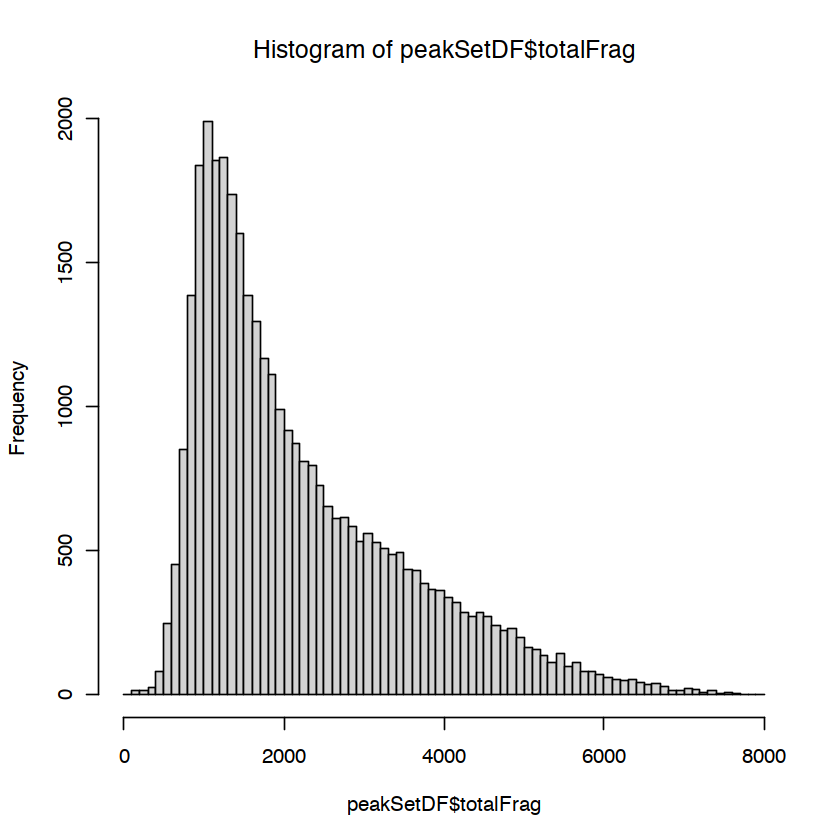

In [141]:
hist(peakSetDF$totalFrag, breaks=100)

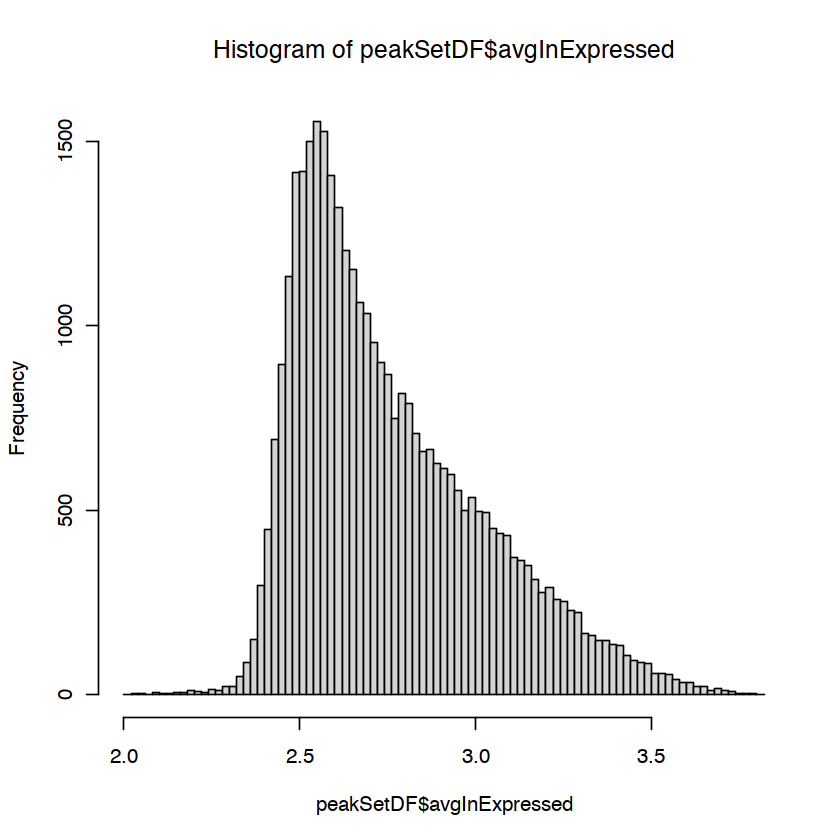

In [142]:
hist(peakSetDF$avgInExpressed, breaks=100)

In [143]:
library(ggplot2)

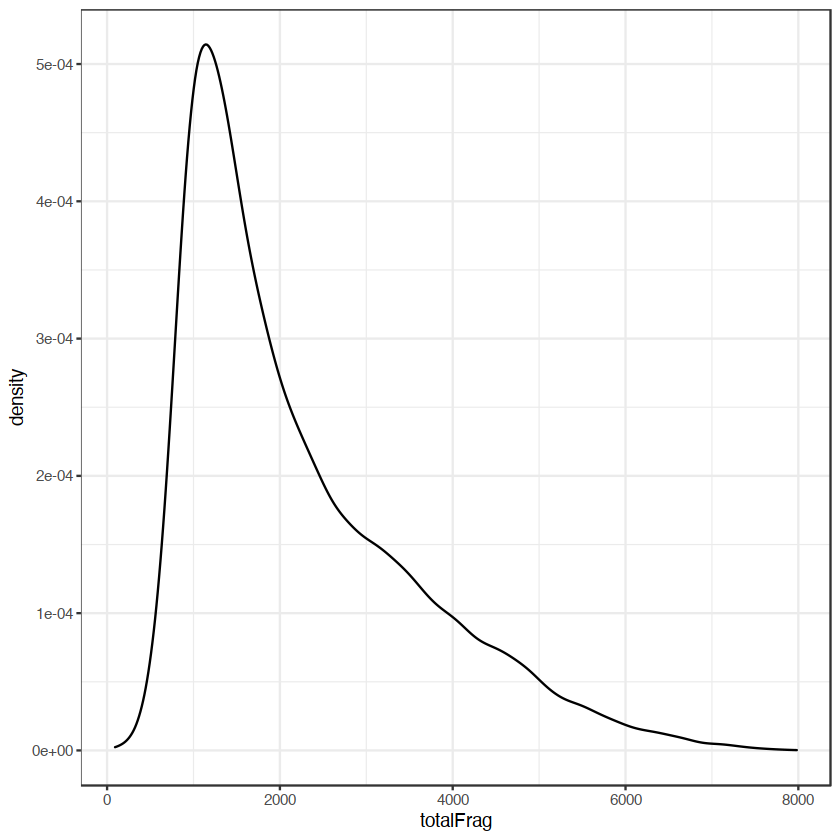

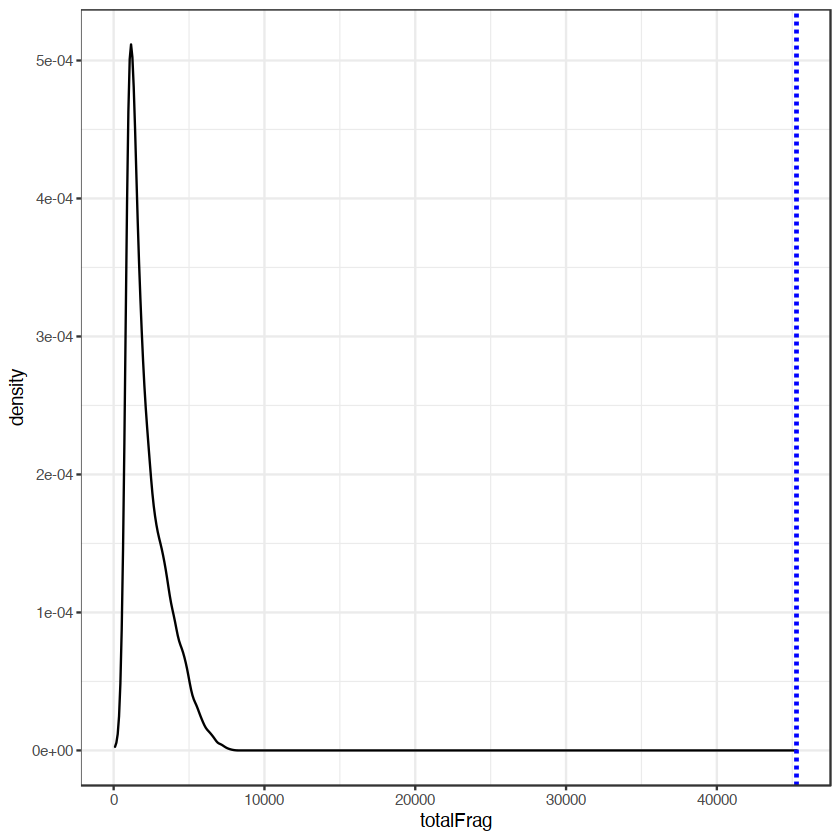

In [144]:
p <- ggplot(peakSetDF, aes(x=totalFrag)) + 
  geom_density() +
    theme_bw()
p
# Add mean line
p+ geom_vline(aes(xintercept=25*median(totalFrag)),
            color="blue", linetype="dashed", size=1) +
    theme_bw()

In [145]:
threshold = 25*median(peakSetDF$totalFrag)
threshold

[1] 45300

In [146]:
peakSetDF$amplification <- 0
peakSetDF[peakSetDF$totalFrag > threshold,'amplification'] <- 1

In [147]:
sum(peakSetDF$amplification)

[1] 0

In [148]:
ampIndex <- which(peakSetDF$amplification==1)
head(ampIndex)

integer(0)

In [149]:
peakSetDF[peakSetDF$amplification == 1,]

seqnames starts ends GC score nearestGene peakType idx totalFrag
     avgInExpressed amplification

In [150]:
peakSetDF[peakSetDF$nearestGene %in% 'EGFR' & peakSetDF$amplification == 1,]

seqnames starts ends GC score nearestGene peakType idx totalFrag
     avgInExpressed amplification

In [151]:
write.csv(peakSetDF[peakSetDF$amplification == 1,],'amplifiendPeaks_50000BinSize.csv')

In [75]:
peakSetDF$secondryAmplification <- peakSetDF$amplification
for(i in 1:length(ampIndex)){
    # Forward indexing
    forwardFlag = 0
    for(j in 1:10){
        if(forwardFlag ==2){
            break
        }
        else if(peakSetDF[ampIndex[i]+j,'totalFrag'] > peakSetDF[ampIndex[i],'totalFrag']/4){
            peakSetDF[ampIndex[i]+j,'secondryAmplification'] <- 1
            
        }
        else{
            forwardFlag = forwardFlag + 1
        }
        
    }
    
    # Backward indexing
    backwardFlag = 0
    for(j in 1:10){
        if(backwardFlag ==2){
            break
        }
        else if(peakSetDF[ampIndex[i]-j,'totalFrag'] > peakSetDF[ampIndex[i],'totalFrag']/4){
            peakSetDF[ampIndex[i]-j,'secondryAmplification'] <- 1
            
        }
        else{
            backwardFlag = backwardFlag + 1
        }
        
    }
}

In [ ]:
getCellColData

In [76]:
peakSetDF[peakSetDF$secondryAmplification == 1,]

seqnames starts    ends      GC     score     nearestGene  peakType
42435  chr2     222448734 222449235 0.4611   3.41237 SGPP2        Intronic
42436  chr2     222478213 222478714 0.4770   2.87301 SGPP2        Intronic
42437  chr2     222482899 222483400 0.3673   2.89011 SGPP2        Intronic
42438  chr2     222506505 222507006 0.3313   3.63169 SGPP2        Intronic
42439  chr2     222518934 222519435 0.3912 154.67200 SGPP2        Intronic
42440  chr2     222520385 222520886 0.4890   6.53208 SGPP2        Intronic
42441  chr2     222532323 222532824 0.5110   6.53208 SGPP2        Intronic
42442  chr2     222541843 222542344 0.3892   4.28172 FARSB        Intronic
42443  chr2     222559593 222560094 0.4970   2.89011 FARSB        Exonic  
42489  chr2     222837111 222837612 0.4251   4.98124 ACSL3        Distal  
42490  chr2     222837687 222838188 0.4032  60.97300 ACSL3        Distal  
42491  chr2     222838862 222839363 0.4331   3.37079 ACSL3        Distal  
42493  chr2     222842565 222843066 0.3832 131.81600 ACSL3        Distal  
42494  chr2     222843653 222844154 0.4251   2.17789 ACSL3        Distal  
42495  chr2     222844276 222844777 0.4411  35.48300 ACSL3        Distal  
42496  chr2     222847966 222848467 0.4711 109.72300 ACSL3        Distal  
42497  chr2     222859799 222860300 0.4251  21.54040 ACSL3        Promoter
42587  chr2     223919264 223919765 0.5010  13.61100 WDFY1        Intronic
42588  chr2     223923951 223924452 0.3812   2.89011 WDFY1        Intronic
42589  chr2     223925069 223925570 0.3453  13.61100 WDFY1        Intronic
42935  chr2     228602323 228602824 0.3453   2.87301 SPHKAP       Distal  
42936  chr2     228603290 228603791 0.3812   2.87301 SPHKAP       Distal  
42937  chr2     228626907 228627408 0.4611   2.87301 SPHKAP       Distal  
42938  chr2     228768715 228769216 0.3134   3.86813 PID1         Distal  
42974  chr2     229408231 229408732 0.3872 200.61500 PID1         Intronic
42975  chr2     229408825 229409326 0.4232   4.68400 PID1         Intronic
42976  chr2     229409569 229410070 0.4152  18.58070 PID1         Intronic
42977  chr2     229416185 229416686 0.4611  14.98060 PID1         Intronic
42978  chr2     229418677 229419178 0.3812   3.86813 PID1         Intronic
42979  chr2     229443150 229443651 0.4072   2.89011 PID1         Intronic
⋮      ⋮        ⋮         ⋮         ⋮      ⋮         ⋮            ⋮       
96967  chr6     150865396 150865897 0.7126 97.48130  MTHFD1L      Promoter
96990  chr6     151030142 151030643 0.4850  6.99174  MTHFD1L      Intronic
96991  chr6     151036299 151036800 0.4232 22.43600  MTHFD1L      Intronic
96993  chr6     151039188 151039689 0.5070  2.89011  MTHFD1L      Intronic
96994  chr6     151041000 151041501 0.5349 17.11020  MTHFD1L      Intronic
96995  chr6     151043909 151044410 0.4810  9.07870  MTHFD1L      Intronic
96996  chr6     151044490 151044991 0.5529 21.74350  MTHFD1L      Intronic
96997  chr6     151045080 151045581 0.4950 11.19920  MTHFD1L      Intronic
97003  chr6     151078950 151079451 0.4910  4.33517  LOC102723831 Intronic
97004  chr6     151085213 151085714 0.4212  9.07870  LOC102723831 Intronic
97005  chr6     151091517 151092018 0.4391 13.61100  LOC102723831 Intronic
97006  chr6     151107623 151108124 0.4990  4.28172  LOC102723831 Intronic
97007  chr6     151125091 151125592 0.4212  6.85675  LOC102723831 Intronic
97008  chr6     151125719 151126220 0.4032  6.98613  LOC102723831 Intronic
97009  chr6     151141644 151142145 0.4691 13.07760  LOC102723831 Intronic
97010  chr6     151143371 151143872 0.5150  6.01631  LOC102723831 Intronic
97025  chr6     151350400 151350901 0.5110  7.41144  ZBTB2        Exonic  
97026  chr6     151354476 151354977 0.5269 98.99520  ZBTB2        Intronic
97027  chr6     151374814 151375315 0.4271  9.78385  ZBTB2        Intronic
97028  chr6     151382550 151383051 0.4691 29.56270  ZBTB2        Intronic
97295  chr6     155052745 155053246 0.3054  2.87301  MIR1273C     Intronic
97296  chr6     155077618 155078

In [99]:
peakSetDF[c(5745:5750),]

seqnames starts   ends     GC     score     nearestGene peakType idx 
5745 chr1     30716580 30717081 0.5709   8.21001 MATN1-AS1   Promoter 5745
5746 chr1     30717177 30717678 0.4790  17.18110 MATN1-AS1   Promoter 5746
5747 chr1     30717883 30718384 0.6627 253.68600 MATN1-AS1   Promoter 5747
5748 chr1     30718436 30718937 0.7505 153.18600 MATN1-AS1   Exonic   5748
5749 chr1     30719134 30719635 0.6507  65.50280 MATN1-AS1   Exonic   5749
5750 chr1     30719952 30720453 0.5649   7.33970 MATN1-AS1   Exonic   5750
     totalFrag amplification secondryAmplification
5745  132      0             0                    
5746  218      0             0                    
5747 1836      1             1                    
5748 1330      1             1                    
5749  564      0             1                    
5750  147      0             0

## Trying with TileMatrix now

In [10]:
binSize <- 500

In [11]:
chrisAggrproj <- addTileMatrix(
                  input = chrisAggrproj,
                  tileSize = binSize,
                  binarize = FALSE,
                  force=TRUE
            )


ArchR logging to : ArchRLogs/ArchR-addTileMatrix-102d66e062304-Date-2021-08-18_Time-12-20-33.log
If there is an issue, please report to github with logFile!

2021-08-18 12:20:33 : Batch Execution w/ safelapply!, 0 mins elapsed.



In [12]:

tileMtx <- getMatrixFromProject(chrisAggrproj, useMatrix='TileMatrix')
#peakMtx <- getMatrixFromProject(chrisAggrproj, useMatrix='TileMatrix')



ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-102d61d3307e2-Date-2021-08-18_Time-12-21-57.log
If there is an issue, please report to github with logFile!

2021-08-18 12:22:55 : Organizing colData, 0.966 mins elapsed.

2021-08-18 12:22:55 : Organizing rowData, 0.966 mins elapsed.

2021-08-18 12:22:55 : Organizing rowRanges, 0.967 mins elapsed.

2021-08-18 12:22:55 : Organizing Assays (1 of 1), 0.967 mins elapsed.

2021-08-18 12:22:57 : Constructing SummarizedExperiment, 0.997 mins elapsed.

2021-08-18 12:22:58 : Finished Matrix Creation, 1.007 mins elapsed.



In [13]:
tileMtx

class: SummarizedExperiment 
dim: 6062095 2335 
metadata(0):
assays(1): TileMatrix
rownames: NULL
rowData names(3): seqnames idx start
colnames(2335): Liver_Metastasis#AACCGATCAGCGTCGT-1
  Liver_Metastasis#TACGCCTTCAGGAATA-1 ...
  Adenocarcinoma_Tumour#AAGGAGCGTTCCTGTC-1
  Adenocarcinoma_Tumour#ATGTACGCACTCGGAC-1
colData names(18): BlacklistRatio DoubletEnrichment ... ReadsInPeaks
  FRIP

In [14]:
assay(tileMtx,'TileMatrix')[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
     Liver_Metastasis#AACCGATCAGCGTCGT-1 Liver_Metastasis#TACGCCTTCAGGAATA-1
[1,]                                   .                                   .
[2,]                                   .                                   .
[3,]                                   .                                   .
[4,]                                   .                                   .
[5,]                                   .                                   .
     Liver_Metastasis#TAGCTTTGTAGCGGTA-1 Liver_Metastasis#TTCGCGTAGGTCTTTG-1
[1,]                                   .                                   .
[2,]                                   .                                   .
[3,]                                   .                                   .
[4,]                                   .                                   .
[5,]                                   .                                   .
     Liver_Metastasis#CCCTCTCTCTAAA

In [15]:
tileMtxBin <- assay(tileMtx,'TileMatrix')

In [16]:
#tileSet <- getPeakSet(chrisAggrproj)

In [17]:
tileMtxDFTmp <- rowData(tileMtx)
tileMtxDFTmp$rowID <- paste0(tileMtxDFTmp$seqnames,tileMtxDFTmp$idx,tileMtxDFTmp$start)
rownames(tileMtxDFTmp) <- tileMtxDFTmp$rowID
tileMtxDFTmp

DataFrame with 6062095 rows and 4 columns
                    seqnames     idx     start               rowID
                       <Rle> <array>   <array>         <character>
chr110                  chr1       1         0              chr110
chr12500                chr1       2       500            chr12500
chr131000               chr1       3      1000           chr131000
chr141500               chr1       4      1500           chr141500
chr152000               chr1       5      2000           chr152000
...                      ...     ...       ...                 ...
chrX312078156038500     chrX  312078 156038500 chrX312078156038500
chrX312079156039000     chrX  312079 156039000 chrX312079156039000
chrX312080156039500     chrX  312080 156039500 chrX312080156039500
chrX312081156040000     chrX  312081 156040000 chrX312081156040000
chrX312082156040500     chrX  312082 156040500 chrX312082156040500

In [18]:
tileMtx_val <- assay(tileMtx, 'TileMatrix')
rownames(tileMtx_val) <- tileMtxDFTmp$rowID

In [19]:
tileMtx_val[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
          Liver_Metastasis#AACCGATCAGCGTCGT-1
chr110                                      .
chr12500                                    .
chr131000                                   .
chr141500                                   .
chr152000                                   .
          Liver_Metastasis#TACGCCTTCAGGAATA-1
chr110                                      .
chr12500                                    .
chr131000                                   .
chr141500                                   .
chr152000                                   .
          Liver_Metastasis#TAGCTTTGTAGCGGTA-1
chr110                                      .
chr12500                                    .
chr131000                                   .
chr141500                                   .
chr152000                                   .
          Liver_Metastasis#TTCGCGTAGGTCTTTG-1
chr110                                      .
chr12500                               

In [20]:
library("dplyr")

In [21]:
tileMtxDF <- as_tibble(tileMtxDFTmp) %>%
group_by(seqnames) %>%
dplyr::slice(c(1:n()-1)) %>%
ungroup()

In [22]:
head(tileMtxDF)

seqnames idx start rowID    
1 chr1     1      0  chr110   
2 chr1     2    500  chr12500 
3 chr1     3   1000  chr131000
4 chr1     4   1500  chr141500
5 chr1     5   2000  chr152000
6 chr1     6   2500  chr162500

In [23]:
tileMtxSlice_val <- tileMtx_val[tileMtxDF$rowID,]

In [24]:
dim(tileMtx_val)

[1] 6062095    2335

In [25]:
dim(tileMtxSlice_val)

[1] 6062072    2335

In [26]:
tileSetDF <- data.frame(seqnames=tileMtxDF$seqnames,
                        starts=tileMtxDF$start,
                        end=tileMtxDF$start+binSize,
                        #GC=peakSet$GC,
                        #score=peakSet$score,
                        #nearestGene=peakSet$nearestGene,
                        #peakType=peakSet$peakType,
                        #idx=peakSet$idx,
                        totalFrag = rowSums(tileMtxSlice_val))
                        #avgInExpressed=rowSums(assay(tileMtx, 'TileMatrix'))/rowSums(tileMtx))                        


In [27]:
head(tileSetDF)

seqnames starts end  totalFrag
1 chr1        0    500 0        
2 chr1      500   1000 0        
3 chr1     1000   1500 0        
4 chr1     1500   2000 0        
5 chr1     2000   2500 0        
6 chr1     2500   3000 0

In [28]:
## Convert to granges to calculate the GC content
gr <- makeGRangesFromDataFrame(tileSetDF,
                         keep.extra.columns=FALSE,
                         ignore.strand=FALSE,
                         seqinfo=NULL,
                         seqnames.field=c("seqnames"),
                         start.field="starts",
                         end.field=c("end"),
                         strand.field="strand",
                         starts.in.df.are.0based=TRUE)

In [29]:
head(gr)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1     1-500      *
  [2]     chr1  501-1000      *
  [3]     chr1 1001-1500      *
  [4]     chr1 1501-2000      *
  [5]     chr1 2001-2500      *
  [6]     chr1 2501-3000      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [30]:
library(GenomicRanges)
library(BSgenome.Hsapiens.UCSC.hg38)
library(BSgenome)

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:purrr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer



In [31]:
GetGC <- function(bsgenome, gr){
    seqs <- BSgenome::getSeq(bsgenome,gr)
    return(as.numeric(Biostrings::letterFrequency(x=seqs, letters = 'GC', as.prob=TRUE)))
}

In [32]:
GC_content <- GetGC(bsgenome = BSgenome.Hsapiens.UCSC.hg38, gr = gr)
#GC_content <- GetGC(bsgenome = BSgenome.Hsapiens.NCBI.GRCh38, gr = gr[1:500000])


In [33]:
tileSetDF$GC_content <- GC_content

In [34]:
tileSetDF[1:10,]

seqnames starts end  totalFrag GC_content
1  chr1        0    500 0         0         
2  chr1      500   1000 0         0         
3  chr1     1000   1500 0         0         
4  chr1     1500   2000 0         0         
5  chr1     2000   2500 0         0         
6  chr1     2500   3000 0         0         
7  chr1     3000   3500 0         0         
8  chr1     3500   4000 0         0         
9  chr1     4000   4500 0         0         
10 chr1     4500   5000 0         0

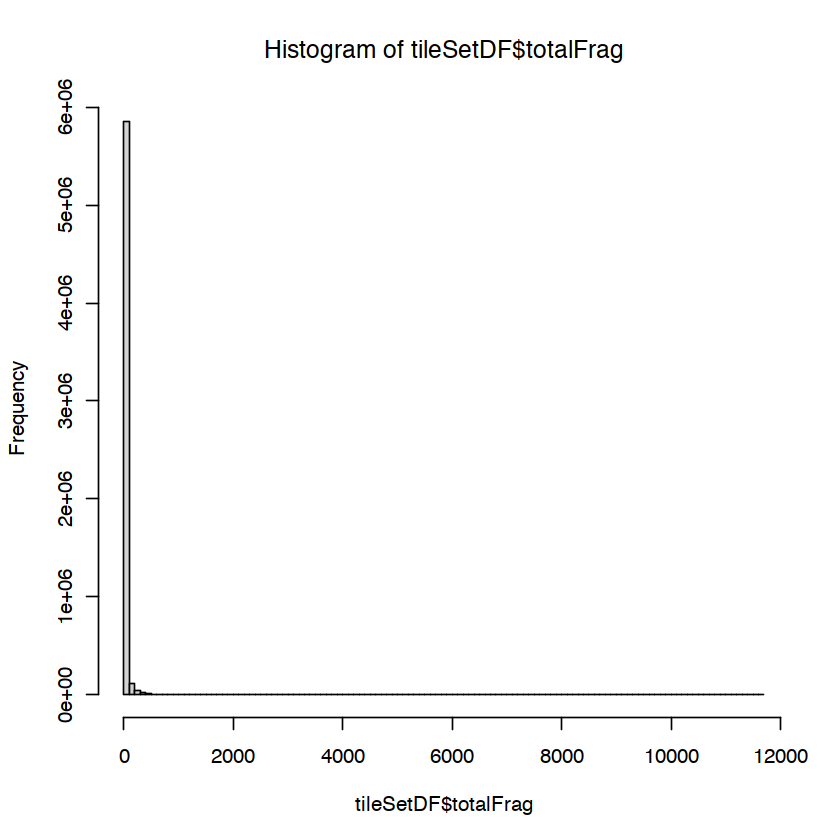

In [35]:
hist(tileSetDF$totalFrag, breaks=100)

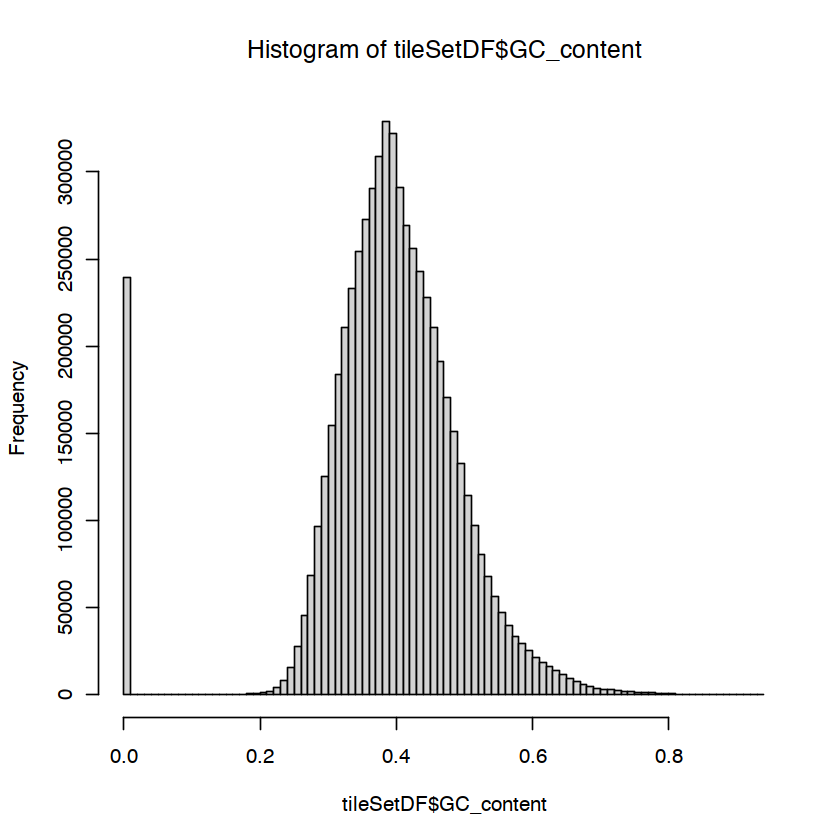

In [36]:
hist(tileSetDF$GC_content, breaks=100)

In [37]:
library(ggplot2)

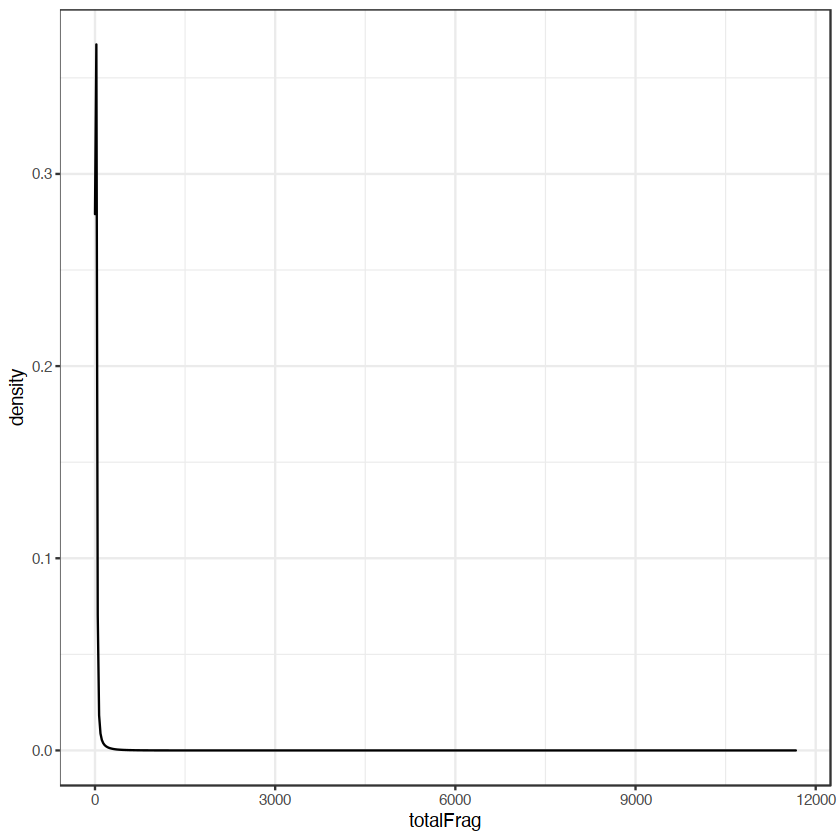

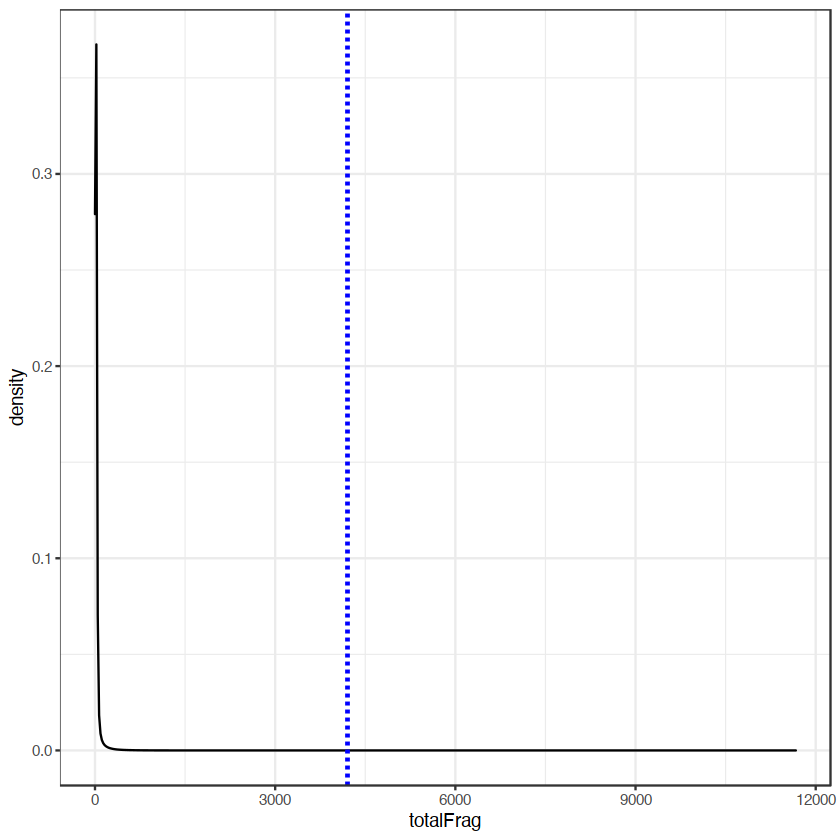

In [38]:
p <- ggplot(tileSetDF, aes(x=totalFrag)) + 
  geom_density() +
    theme_bw()
p
# Add mean line
p+ geom_vline(aes(xintercept=300*median(totalFrag)),
            color="blue", linetype="dashed", size=1) +
    theme_bw()

In [81]:
is.outlier = isOutlier(tileSetDF$totalFrag, nmads=300)
sum(is.outlier)

ERROR: Error in isOutlier(tileSetDF$totalFrag, nmads = 300): could not find function "isOutlier"


In [ ]:
quantileVal <- quantile(tileSetDF$totalFrag, 0.99)
quantileVal

#outlier_values <- boxplot.stats(tileSetDF$totalFrag)$out
#outlier_values

In [ ]:
tileSetDF$amplification <- 0
tileSetDF[tileSetDF$totalFrag > quantileVal,'amplification'] <- 1

In [ ]:
sum(tileSetDF$amplification)

In [ ]:
min(tileSetDF[is.outlier,]$totalFrag)

In [39]:
threshold = 300*median(tileSetDF$totalFrag)
threshold

[1] 4200

In [186]:
tileSetDF$amplification <- 0
tileSetDF[tileSetDF$totalFrag > threshold,'amplification'] <- 1
#tileSetDF[is.outlier,'amplification'] <- 1

In [187]:
sum(tileSetDF$amplification)

[1] 72

In [42]:
ampIndex <- which(tileSetDF$amplification==1)
head(ampIndex)

[1] 740231 740393 741769 857115 857116 857117

In [43]:
ampIndex <- which(tileSetDF$amplification==1)
head(ampIndex)

[1] 740231 740393 741769 857115 857116 857117

In [44]:
tileSetDF[tileSetDF$amplification == 1,]

seqnames starts    end       totalFrag GC_content amplification
740231  chr10    121159000 121159500  5551     0.416      1            
740393  chr10    121240000 121240500  4817     0.574      1            
741769  chr10    121928000 121928500  5418     0.720      1            
857115  chr11     45804000  45804500  5317     0.736      1            
857116  chr11     45804500  45805000  5211     0.660      1            
857117  chr11     45805000  45805500  8183     0.728      1            
857193  chr11     45843000  45843500  5615     0.472      1            
857194  chr11     45843500  45844000  4901     0.418      1            
857201  chr11     45847000  45847500 10728     0.636      1            
857342  chr11     45917500  45918000  5107     0.624      1            
857343  chr11     45918000  45918500  6389     0.596      1            
857993  chr11     46243000  46243500  5051     0.570      1            
858012  chr11     46252500  46253000  4942     0.520      1            
858052  chr11     46272500  46273000  6223     0.584      1            
858053  chr11     46273000  46273500  5306     0.464      1            
858054  chr11     46273500  46274000  6699     0.456      1            
858055  chr11     46274000  46274500  8968     0.544      1            
858056  chr11     46274500  46275000  6132     0.544      1            
858059  chr11     46276000  46276500  9493     0.486      1            
858060  chr11     46276500  46277000  7566     0.536      1            
858062  chr11     46277500  46278000  5431     0.662      1            
858064  chr11     46278500  46279000  4856     0.618      1            
858201  chr11     46347000  46347500  8212     0.712      1            
2208961 chr17     39629000  39629500  4651     0.564      1            
2208968 chr17     39632500  39633000  5492     0.602      1            
2208977 chr17     39637000  39637500  4593     0.712      1            
2209047 chr17     39672000  39672500  4870     0.622      1            
2209053 chr17     39675000  39675500  7493     0.632      1            
2209055 chr17     39676000  39676500  5009     0.612      1            
2209060 chr17     39678500  39679000  6870     0.552      1            
⋮       ⋮        ⋮         ⋮         ⋮         ⋮          ⋮            
2209182 chr17    39739500  39740000   7183     0.632      1            
2209184 chr17    39740500  39741000   6324     0.626      1            
2209211 chr17    39754000  39754500   5520     0.754      1            
2209212 chr17    39754500  39755000   4746     0.722      1            
2209243 chr17    39770000  39770500   6902     0.430      1            
2209268 chr17    39782500  39783000   4571     0.372      1            
2209558 chr17    39927500  39928000   5005     0.600      1            
2209608 chr17    39952500  39953000   4976     0.680      1            
2209609 chr17    39953000  39953500   4798     0.710      1            
2209664 chr17    39980500  39981000   9328     0.636      1            
2209899 chr17    40098000  40098500   5011     0.548      1            
2209901 chr17    40099000  40099500   6378     0.696      1            
2209904 chr17    40100500  40101000   5874     0.616      1            
2209905 chr17    40101000  40101500   4808     0.524      1            
2209929 chr17    40113000  40113500   4510     0.472      1            
2394260 chr18    49021500  49022000   4720     0.628      1            
3158917 chr20    50166000  50166500   5592     0.500      1            
3159431 chr20    50423000  50423500   4345     0.544      1            
4974272 chr7     55018500  55019000   5666     0.664      1            
4974382 chr7     55073500  55074000   5006     0.366      1            
4974383 chr7     55074000  55074500  11669     0.490      1            
4974390 chr7     55077500  55078000   9062     0.510      1            
4974391 chr7     55078000  55078500   5760     0.624      1            
4974393 chr7     55079000  55079500   6593     0

In [45]:
tileSetDF[tileSetDF$seqnames %in% 'chr7' & tileSetDF$amplification == 1,]

seqnames starts   end      totalFrag GC_content amplification
4974272 chr7     55018500 55019000  5666     0.664      1            
4974382 chr7     55073500 55074000  5006     0.366      1            
4974383 chr7     55074000 55074500 11669     0.490      1            
4974390 chr7     55077500 55078000  9062     0.510      1            
4974391 chr7     55078000 55078500  5760     0.624      1            
4974393 chr7     55079000 55079500  6593     0.596      1            
4974500 chr7     55132500 55133000  5725     0.456      1            
4974501 chr7     55133000 55133500  8201     0.560      1            
4974502 chr7     55133500 55134000  5224     0.564      1            
4974597 chr7     55181000 55181500  4970     0.576      1            
4974966 chr7     55365500 55366000  5698     0.738      1            
4974967 chr7     55366000 55366500  7014     0.692      1

## Apply KNN classification to identify similar amplification peaks

In [46]:
Positive_data <- tileSetDF[tileSetDF$amplification == 1,]

In [47]:
Negative_data <- tileSetDF[tileSetDF$amplification == 0 && tileSetDF$totalFrag <500,]

In [48]:
dim(Positive_data)

[1] 72  6

In [49]:
dim(Negative_data)

[1] 6062072       6

In [50]:
posTrainSample <- sample(1:nrow(Positive_data),0.9 * nrow(Positive_data))
posTestSample <- c(1:nrow(Positive_data))[-posTrainSample]
#posTraiin <- Positive_data[sample(nrow(Positive_data), 3), ]

In [51]:
negTrainSample <- sample(1:nrow(Negative_data),length(posTrainSample))
negTestSample <- c(1:nrow(Negative_data))[-negTrainSample]
negTestSample <- sample(1:length(negTestSample),length(posTestSample))

In [52]:
trainData <- rbind(Positive_data[posTrainSample,],Negative_data[negTrainSample,])
testData <- rbind(Positive_data[posTestSample,],Negative_data[negTestSample,])

In [53]:
train_target <- as.factor(trainData$amplification)
test_target <- as.factor(testData$amplification)

In [54]:
trainData <- trainData[,c('totalFrag','GC_content')]
testData <- testData[,c('totalFrag','GC_content')]

In [55]:
library(class)

In [279]:
##run knn function
pr <- knn(trainData,testData,cl=train_target,k=5)

In [280]:
 ##create the confucion matrix
 tb <- table(pr,test_target)

 ##check the accuracy
 accuracy <- function(x){sum(diag(x)/(sum(rowSums(x)))) * 100}
 accuracy(tb)

[1] 100

Now putting through all the negative data to see whether any amplification is detected

In [56]:
##run knn function
#K = round(sum(tileSetDF$amplification))
K=5
pr <- knn(trainData,Negative_data[,c('totalFrag','GC_content')],cl=train_target,k=K)

In [110]:
tileSetDF$KNN_amplification <- as.numeric(levels(pr))[pr]

In [87]:
tileSetDF[tileSetDF$KNN_amplification==1,]

seqnames starts    end       totalFrag GC_content amplification
31054   chr1      15526500  15527000 2318      0.618      1            
424571  chr1     212285000 212285500 2542      0.680      0            
641447  chr10     71767000  71767500 2463      0.564      1            
642434  chr10     72260500  72261000 2286      0.656      1            
642460  chr10     72273500  72274000 2755      0.670      1            
647565  chr10     74826000  74826500 3316      0.620      0            
658306  chr10     80196500  80197000 2268      0.556      0            
670713  chr10     86400000  86400500 2718      0.736      1            
670956  chr10     86521500  86522000 3768      0.734      0            
670984  chr10     86535500  86536000 2562      0.600      0            
671098  chr10     86592500  86593000 2363      0.540      0            
671335  chr10     86711000  86711500 3272      0.700      0            
671425  chr10     86756000  86756500 2336      0.726      0            
740231  chr10    121159000 121159500 5551      0.416      1            
740232  chr10    121159500 121160000 2632      0.454      0            
740393  chr10    121240000 121240500 4817      0.574      1            
740394  chr10    121240500 121241000 2855      0.428      0            
740562  chr10    121324500 121325000 3330      0.508      0            
740563  chr10    121325000 121325500 2455      0.398      0            
740564  chr10    121325500 121326000 2549      0.416      0            
740565  chr10    121326000 121326500 2841      0.380      0            
740588  chr10    121337500 121338000 2376      0.446      0            
740960  chr10    121523500 121524000 3047      0.442      1            
741020  chr10    121553500 121554000 2900      0.418      1            
741021  chr10    121554000 121554500 2453      0.512      1            
741109  chr10    121598000 121598500 2636      0.756      1            
741110  chr10    121598500 121599000 3325      0.614      1            
741130  chr10    121608500 121609000 2549      0.652      1            
741767  chr10    121927000 121927500 2532      0.458      1            
741768  chr10    121927500 121928000 2833      0.708      1            
⋮       ⋮        ⋮         ⋮         ⋮         ⋮          ⋮            
4974501 chr7      55133000  55133500 8201      0.560      1            
4974502 chr7      55133500  55134000 5224      0.564      1            
4974503 chr7      55134000  55134500 2529      0.562      1            
4974592 chr7      55178500  55179000 2576      0.436      1            
4974593 chr7      55179000  55179500 3116      0.510      1            
4974597 chr7      55181000  55181500 4970      0.576      1            
4974598 chr7      55181500  55182000 3395      0.506      1            
4974611 chr7      55188000  55188500 3010      0.522      1            
4974612 chr7      55188500  55189000 3727      0.482      1            
4974613 chr7      55189000  55189500 2295      0.476      1            
4974726 chr7      55245500  55246000 2255      0.438      1            
4974744 chr7      55254500  55255000 3038      0.710      1            
4974745 chr7      55255000  55255500 3467      0.700      1            
4974746 chr7      55255500  55256000 4111      0.602      1            
4974966 chr7      55365500  55366000 5698      0.738      1            
4974967 chr7      55366000  55366500 7014      0.692      1            
4974968 chr7      55366500  55367000 2672      0.534      0            
5206531 chr8      11802500  11803000 2396      0.696      0            
5316260 chr8      66667000  66667500 2529      0.580      0            
5330870 chr8      73972000  73972500 2295      0.622      0            
5365066 chr8      91070000  91070500 2675      0.600      0            
5373193 chr8      95133500  95134000 2605      0.748      1            
5384370 chr8     100722000 100722500 2793      0.694      1            
5387404 chr8     102239000 102239500 3436      0

### Filtering the False Positive for KNN_amplification

In [189]:
Knn_ampIndex <- which(tileSetDF$KNN_amplification==1)
head(Knn_ampIndex)

[1]  31054 424571 641447 642434 642460 647565

In [188]:
tileSetDF$KNN_amplification <- as.numeric(levels(pr))[pr]

In [190]:
#tileSetDF$secondryAmplification <- tileSetDF$amplification
binsToCheck <- 1000
#binReaThreshold <- 15
binsAppArray <- rep(0,30)
for(i in 1:length(Knn_ampIndex)){
    
    # Forward indexing
    Flag = 0
    j <- 1
    binsAmp <- 0
    binReaThreshold <- tileSetDF[Knn_ampIndex[i],'totalFrag']/1.5
    while(Flag < binsToCheck){
        if(tileSetDF[Knn_ampIndex[i]+j,'totalFrag'] > binReaThreshold){
            binsAmp <- binsAmp + 1   
        }
        if(tileSetDF[Knn_ampIndex[i]-j,'totalFrag'] > binReaThreshold){
            binsAmp <- binsAmp + 1   
        }
        j <- j+1
        Flag <- Flag + 1
        
    }
    binsAppArray[i]<- binsAmp
    if(binsAmp < (binsToCheck * 2)*0.002){
        tileSetDF[Knn_ampIndex[i],'KNN_amplification'] <- 0
    }
    
}

In [191]:
binsAppArray

[1]   2   0   2   7   2   0   4   9   3   9  10   5  10   1  19   3  16  14
 [19]  21  19  16  22  22  23  28  26  19  26  13  12   1   7  12  42  51  31
 [37]  23  23   9  36  62  23  24   5  37  61  63  25  19  45  65  69  27  57
 [55]  77  82  75  29  86  82  41  62  21  26  19   9  23  70   7  16  64  26
 [73]  66  29  62  77  79  74  62   8  47  51  54  30  48  59  52  38  54  55
 [91]  27   1   4   1   0   0   0   1   0   1   1   3 125  71 127 106  53 113
[109] 114 110 105  41  54 108 123  48 110  17  83  45 111  25  54  54  54  58
[127]  83  54 104 104  59  37  39  54 131  39  37  54 104  54  74  69  33  21
[145]  80  33  83  41  52  24  54 118  86 108  90 105  87 119  45  45  50 122
[163]  71   7  78 106 127  86  69  58  79  87 105 114  45 134  33  37  50 115
[181]  86  54  59   6   0   9   7   3   6   7   7   2   4   0   1   3   0  48
[199]  48  36  28   2  61  63  38  52  59  45  55  21  64  52  62  67  26  35
[217]  67  62  60  62  56  34  31  38  53  11  14  60   1   0   0   1   0   3
[235]   0  27  15  29  42  32  54  39  40  20   2   4  15  29  11  54  54  32
[253]  44  40  55  44  15   8  18  52  50  41  20  37  42  32  56  56  42  36
[271]  29  14  11  46   4   0   0   0   3   2   0   1   1   0   1   0   0

In [192]:
tileSetDF[tileSetDF$KNN_amplification==1 & tileSetDF$seqnames=='chr8',]

seqnames starts   end      totalFrag GC_content amplification
5206531 chr8     11802500 11803000 2396      0.696      0            
        KNN_amplification secondryAmplification
5206531 1                 0

In [193]:
tileSetDF[tileSetDF$KNN_amplification==1,]

seqnames starts    end       totalFrag GC_content amplification
642434  chr10     72260500  72261000 2286      0.656      0            
658306  chr10     80196500  80197000 2268      0.556      0            
670713  chr10     86400000  86400500 2718      0.736      0            
670984  chr10     86535500  86536000 2562      0.600      0            
671098  chr10     86592500  86593000 2363      0.540      0            
671335  chr10     86711000  86711500 3272      0.700      0            
671425  chr10     86756000  86756500 2336      0.726      0            
740232  chr10    121159500 121160000 2632      0.454      0            
740394  chr10    121240500 121241000 2855      0.428      0            
740562  chr10    121324500 121325000 3330      0.508      0            
740563  chr10    121325000 121325500 2455      0.398      0            
740564  chr10    121325500 121326000 2549      0.416      0            
740565  chr10    121326000 121326500 2841      0.380      0            
740588  chr10    121337500 121338000 2376      0.446      0            
740960  chr10    121523500 121524000 3047      0.442      0            
741020  chr10    121553500 121554000 2900      0.418      0            
741021  chr10    121554000 121554500 2453      0.512      0            
741109  chr10    121598000 121598500 2636      0.756      0            
741110  chr10    121598500 121599000 3325      0.614      0            
741130  chr10    121608500 121609000 2549      0.652      0            
741767  chr10    121927000 121927500 2532      0.458      0            
741768  chr10    121927500 121928000 2833      0.708      0            
741784  chr10    121935500 121936000 3946      0.454      0            
741785  chr10    121936000 121936500 2744      0.474      0            
857051  chr11     45772000  45772500 2323      0.580      0            
857110  chr11     45801500  45802000 2919      0.468      0            
857111  chr11     45802000  45802500 4195      0.440      0            
857115  chr11     45804000  45804500 5317      0.736      1            
857116  chr11     45804500  45805000 5211      0.660      1            
857117  chr11     45805000  45805500 8183      0.728      1            
⋮       ⋮        ⋮         ⋮         ⋮         ⋮          ⋮            
4974390 chr7     55077500  55078000  9062      0.510      1            
4974391 chr7     55078000  55078500  5760      0.624      1            
4974392 chr7     55078500  55079000  4075      0.626      0            
4974393 chr7     55079000  55079500  6593      0.596      1            
4974394 chr7     55079500  55080000  2456      0.458      0            
4974408 chr7     55086500  55087000  2449      0.534      0            
4974418 chr7     55091500  55092000  3777      0.458      0            
4974419 chr7     55092000  55092500  2870      0.458      0            
4974476 chr7     55120500  55121000  3132      0.458      0            
4974477 chr7     55121000  55121500  2354      0.440      0            
4974490 chr7     55127500  55128000  2872      0.434      0            
4974500 chr7     55132500  55133000  5725      0.456      1            
4974501 chr7     55133000  55133500  8201      0.560      1            
4974502 chr7     55133500  55134000  5224      0.564      1            
4974503 chr7     55134000  55134500  2529      0.562      0            
4974592 chr7     55178500  55179000  2576      0.436      0            
4974593 chr7     55179000  55179500  3116      0.510      0            
4974597 chr7     55181000  55181500  4970      0.576      1            
4974598 chr7     55181500  55182000  3395      0.506      0            
4974611 chr7     55188000  55188500  3010      0.522      0            
4974612 chr7     55188500  55189000  3727      0.482      0            
4974613 chr7     55189000  55189500  2295      0.476      0            
4974726 chr7     55245500  55246000  2255      0.438      0            
4974744 chr7     55254500  55255000  3038      0

In [194]:
write.csv(tileSetDF[tileSetDF$KNN_amplification==1,],'knn_amplification_afterFiltering.csv')

In [195]:
tileSetDF[tileSetDF$KNN_amplification==1,'amplification'] <- 1

In [196]:
ampIndex <- which(tileSetDF$amplification==1)
head(ampIndex)

[1] 642434 658306 670713 670984 671098 671335

In [197]:
length(ampIndex)

[1] 246

In [198]:
tileSetDF$secondryAmplification <- tileSetDF$amplification
for(i in 1:length(ampIndex)){
    
    # Forward indexing
    Flag = 0
    j <- 1
    while(Flag < 6){
        if(tileSetDF[ampIndex[i]+j,'totalFrag'] > 5){
            tileSetDF[ampIndex[i]+j,'secondryAmplification'] <- 1
            j <- j+1
            
        }
        else{
            Flag <- Flag + 1
            j <- j + 1
        }
        
    }
    
    # Backward indexing
    j <- 1
    Flag = 0
    while(Flag < 6){
        if(tileSetDF[ampIndex[i]-j,'totalFrag'] > 5){
            tileSetDF[ampIndex[i]-j,'secondryAmplification'] <- 1
            j <- j+1
            
        }
        else{
            Flag <- Flag + 1
            j <- j + 1
        }
        
    }
}

In [199]:
head(tileSetDF[tileSetDF$secondryAmplification == 1,])

seqnames starts   end      totalFrag GC_content amplification
640141 chr10    71114000 71114500  7        0.328      0            
640142 chr10    71114500 71115000  8        0.282      0            
640143 chr10    71115000 71115500 17        0.290      0            
640144 chr10    71115500 71116000 22        0.428      0            
640145 chr10    71116000 71116500 23        0.410      0            
640146 chr10    71116500 71117000 13        0.528      0            
       KNN_amplification secondryAmplification
640141 0                 1                    
640142 0                 1                    
640143 0                 1                    
640144 0                 1                    
640145 0                 1                    
640146 0                 1

In [200]:
dim(tileSetDF[tileSetDF$secondryAmplification == 1,])

[1] 31429     8

In [201]:
tile.anno <- tileSetDF[tileSetDF$secondryAmplification == 1,]
tile.anno.GR <- makeGRangesFromDataFrame(tile.anno,
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("seqnames", "seqname",
                                          "chromosome", "chrom",
                                          "chr", "chromosome_name",
                                          "seqid"),
                         start.field="starts",
                         end.field=c("end", "stop"),
                         strand.field="strand",
                         starts.in.df.are.0based=FALSE)

In [202]:
library(ChIPpeakAnno)

In [203]:
tile.anno.GR

GRanges object with 31429 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
   640141    chr10 71114000-71114500      *
   640142    chr10 71114500-71115000      *
   640143    chr10 71115000-71115500      *
   640144    chr10 71115500-71116000      *
   640145    chr10 71116000-71116500      *
      ...      ...               ...    ...
  5206997     chr8 12035500-12036000      *
  5206998     chr8 12036000-12036500      *
  5206999     chr8 12036500-12037000      *
  5207000     chr8 12037000-12037500      *
  5207001     chr8 12037500-12038000      *
  -------
  seqinfo: 8 sequences from an unspecified genome; no seqlengths

In [204]:
tile.anno.GR.anno <- annotatePeakInBatch(tile.anno.GR, AnnotationData=TSS.human.GRCh38)
tile.anno.GR.anno <- addGeneIDs(annotatedPeak=tile.anno.GR.anno, 
                        orgAnn="org.Hs.eg.db", 
                        IDs2Add="symbol")

In [205]:
tile.anno.GR.anno[tile.anno.GR.anno$symbol %in% 'EGFR']

GRanges object with 255 ranges and 10 metadata columns:
                           seqnames            ranges strand |        peak
                              <Rle>         <IRanges>  <Rle> | <character>
  X4974188.ENSG00000146648     chr7 54976500-54977000      * |     4974188
  X4974189.ENSG00000146648     chr7 54977000-54977500      * |     4974189
  X4974190.ENSG00000146648     chr7 54977500-54978000      * |     4974190
  X4974191.ENSG00000146648     chr7 54978000-54978500      * |     4974191
  X4974192.ENSG00000146648     chr7 54978500-54979000      * |     4974192
                       ...      ...               ...    ... .         ...
  X4974438.ENSG00000146648     chr7 55101500-55102000      * |     4974438
  X4974439.ENSG00000146648     chr7 55102000-55102500      * |     4974439
  X4974440.ENSG00000146648     chr7 55102500-55103000      * |     4974440
  X4974441.ENSG00000146648     chr7 55103000-55103500      * |     4974441
  X4974442.ENSG00000146648     chr7 55103500

In [206]:
write.table(tile.anno.GR.anno, 'Amplified_till_flat_500_bin_latest_GC_calculated_v2.csv', sep=',', row.names = FALSE)

In [212]:
tile.anno.GR.reduce <- GenomicRanges::reduce(tile.anno.GR, min.gapwidth=5000)

In [213]:
tile.anno.GR.reduce

GRanges object with 15 ranges and 0 metadata columns:
       seqnames            ranges strand
          <Rle>         <IRanges>  <Rle>
   [1]     chr7 54606500-55580500      *
   [2]     chr8 11403500-12038000      *
   [3]    chr10 71114000-72919000      *
   [4]    chr10 79962500-80236000      *
   [5]    chr10 85882500-86853500      *
   ...      ...               ...    ...
  [11]    chr18 48512000-49218000      *
  [12]    chr18 49424000-50243500      *
  [13]    chr19 29465000-29898000      *
  [14]    chr19 32852000-34009500      *
  [15]    chr20 49071500-51069500      *
  -------
  seqinfo: 8 sequences from an unspecified genome; no seqlengths

In [214]:
tile.anno.GR.reduce.anno <- annotatePeakInBatch(tile.anno.GR.reduce, AnnotationData=TSS.human.GRCh38)
tile.anno.GR.reduce.anno <- addGeneIDs(annotatedPeak=tile.anno.GR.reduce.anno, 
                        orgAnn="org.Hs.eg.db", 
                        IDs2Add="symbol")

In [215]:
tile.anno.GR.reduce.anno

GRanges object with 15 ranges and 10 metadata columns:
                      seqnames            ranges strand |        peak
                         <Rle>         <IRanges>  <Rle> | <character>
  X01.ENSG00000200471     chr7 54606500-55580500      * |          01
  X02.ENSG00000199368     chr8 11403500-12038000      * |          02
  X03.ENSG00000107731    chr10 71114000-72919000      * |          03
  X04.ENSG00000273372    chr10 79962500-80236000      * |          04
  X05.ENSG00000200487    chr10 85882500-86853500      * |          05
                  ...      ...               ...    ... .         ...
  X11.ENSG00000134030    chr18 48512000-49218000      * |          11
  X12.ENSG00000263895    chr18 49424000-50243500      * |          12
  X13.ENSG00000267574    chr19 29465000-29898000      * |          13
  X14.ENSG00000201967    chr19 32852000-34009500      * |          14
  X15.ENSG00000124207    chr20 49071500-51069500      * |          15
                              featu

In [216]:
write.table(tile.anno.GR.reduce.anno, 'Amplified_till_flat_500_bin_anno_reduce_gappedFilled.csv', sep=',', row.names = FALSE)

In [ ]:
tileSetDF$secondryAmplification <- tileSetDF$amplification
binsToCheck <- 1000 * 5
for(i in 1:length(ampIndex)){
    
    
    Flag = 0
    # Forward indexing
    forwardFlag = 0
    
    # Backward indexing
    backwardFlag = 0
    j <- 1
    while(Flag < binsToCheck){
        if(forwardFlag)
        if(tileSetDF[ampIndex[i]+j,'totalFrag'] > 5){
            tileSetDF[ampIndex[i]+j,'secondryAmplification'] <- 1
            j <- j+1
            
        }
        else{
            Flag <- Flag + 1
            j <- j + 1
        }
        
    }
    
    # Backward indexing
    j <- 1
    Flag = 0
    while(Flag < 6){
        if(tileSetDF[ampIndex[i]-j,'totalFrag'] > 5){
            tileSetDF[ampIndex[i]-j,'secondryAmplification'] <- 1
            j <- j+1
            
        }
        else{
            Flag <- Flag + 1
            j <- j + 1
        }
        
    }
}

In [314]:
tile.anno <- tileSetDF[tileSetDF$KNN_amplification == 1,]
tile.anno.GR <- makeGRangesFromDataFrame(tile.anno,
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("seqnames", "seqname",
                                          "chromosome", "chrom",
                                          "chr", "chromosome_name",
                                          "seqid"),
                         start.field="starts",
                         end.field=c("end", "stop"),
                         strand.field="strand",
                         starts.in.df.are.0based=FALSE)

In [315]:
tile.anno.GR.anno <- annotatePeakInBatch(tile.anno.GR, AnnotationData=TSS.human.GRCh38)
tile.anno.GR.anno <- addGeneIDs(annotatedPeak=tile.anno.GR.anno, 
                        orgAnn="org.Hs.eg.db", 
                        IDs2Add="symbol")

In [316]:
write.table(tile.anno.GR.anno, 'Amplified_knn_updated.csv', sep=',', row.names = FALSE)

In [329]:
# We have modified this portion of the code later

tileSetDF$secondryAmplification <- tileSetDF$amplification
for(i in 1:length(ampIndex)){
    # Forward indexing
    ampNum <- 0
    forwardFlag = 0
    for(j in 1:30){
        if(forwardFlag ==6){
            break
        }
        else if(tileSetDF[ampIndex[i]+j,'totalFrag'] > tileSetDF[ampIndex[i],'totalFrag']/6){
            tileSetDF[ampIndex[i]+j,'secondryAmplification'] <- 1
            
        }
        else{
            forwardFlag = forwardFlag + 1
        }
        
    }
    
    # Backward indexing
    backwardFlag = 0
    for(j in 1:30){
        if(backwardFlag ==6){
            break
        }
        else if(tileSetDF[ampIndex[i]-j,'totalFrag'] > tileSetDF[ampIndex[i],'totalFrag']/6){
            tileSetDF[ampIndex[i]-j,'secondryAmplification'] <- 1
            
        }
        else{
            backwardFlag = backwardFlag + 1
        }
        
    }
}

In [111]:
tileSetDF$secondryAmplification <- tileSetDF$amplification
for(i in 1:length(ampIndex)){
    
    # Forward indexing
    Flag = 0
    j <- 1
    while(Flag < 6){
        if(tileSetDF[ampIndex[i]+j,'totalFrag'] > 5){
            tileSetDF[ampIndex[i]+j,'secondryAmplification'] <- 1
            j <- j+1
            
        }
        else{
            Flag <- Flag + 1
            j <- j + 1
        }
        
    }
    
    # Backward indexing
    j <- 1
    Flag = 0
    while(Flag < 6){
        if(tileSetDF[ampIndex[i]-j,'totalFrag'] > 5){
            tileSetDF[ampIndex[i]-j,'secondryAmplification'] <- 1
            j <- j+1
            
        }
        else{
            Flag <- Flag + 1
            j <- j + 1
        }
        
    }
}

In [112]:
head(tileSetDF[tileSetDF$secondryAmplification == 1,])

seqnames starts   end      totalFrag GC_content amplification
29450 chr1     14724500 14725000 20        0.450      0            
29451 chr1     14725000 14725500 26        0.408      0            
29452 chr1     14725500 14726000 28        0.498      0            
29453 chr1     14726000 14726500 20        0.564      0            
29454 chr1     14726500 14727000 20        0.500      0            
29455 chr1     14727000 14727500 12        0.406      0            
      secondryAmplification
29450 1                    
29451 1                    
29452 1                    
29453 1                    
29454 1                    
29455 1

In [119]:
dim(tileSetDF[tileSetDF$secondryAmplification == 1,])

[1] 148900      7

In [113]:
tile.anno <- tileSetDF[tileSetDF$secondryAmplification == 1,]
tile.anno.GR <- makeGRangesFromDataFrame(tile.anno,
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("seqnames", "seqname",
                                          "chromosome", "chrom",
                                          "chr", "chromosome_name",
                                          "seqid"),
                         start.field="starts",
                         end.field=c("end", "stop"),
                         strand.field="strand",
                         starts.in.df.are.0based=FALSE)

In [114]:
library(ChIPpeakAnno)

In [115]:
tile.anno.GR

GRanges object with 148900 ranges and 0 metadata columns:
          seqnames              ranges strand
             <Rle>           <IRanges>  <Rle>
    29450     chr1   14724500-14725000      *
    29451     chr1   14725000-14725500      *
    29452     chr1   14725500-14726000      *
    29453     chr1   14726000-14726500      *
    29454     chr1   14726500-14727000      *
      ...      ...                 ...    ...
  5971142     chrX 110575000-110575500      *
  5971143     chrX 110575500-110576000      *
  5971144     chrX 110576000-110576500      *
  5971145     chrX 110576500-110577000      *
  5971146     chrX 110577000-110577500      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [116]:
tile.anno.GR.anno <- annotatePeakInBatch(tile.anno.GR, AnnotationData=TSS.human.GRCh38)
tile.anno.GR.anno <- addGeneIDs(annotatedPeak=tile.anno.GR.anno, 
                        orgAnn="org.Hs.eg.db", 
                        IDs2Add="symbol")

Loading required package: AnnotationDbi


Attaching package: 'AnnotationDbi'


The following object is masked from 'package:dplyr':

    select






In [117]:
tile.anno.GR.anno[tile.anno.GR.anno$symbol %in% 'EGFR']

GRanges object with 0 ranges and 10 metadata columns:
   seqnames    ranges strand |        peak     feature start_position
      <Rle> <IRanges>  <Rle> | <character> <character>      <integer>
   end_position feature_strand insideFeature distancetoFeature shortestDistance
      <integer>    <character>   <character>         <numeric>        <integer>
   fromOverlappingOrNearest      symbol
                <character> <character>
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [118]:
write.table(tile.anno.GR.anno, 'Amplified_till_flat_500_bin_latest_GC_calculated.csv', sep=',', row.names = FALSE)

## Same concept but now with PeakMatrix but we keep the TileMatrix variable name

In [34]:

peakMtx <- getMatrixFromProject(chrisAggrproj, useMatrix='PeakMatrix')
#peakMtx <- getMatrixFromProject(chrisAggrproj, useMatrix='TileMatrix')



ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-15f0d40da5d66-Date-2021-08-10_Time-19-07-58.log
If there is an issue, please report to github with logFile!

2021-08-10 19:08:08 : Organizing colData, 0.171 mins elapsed.

2021-08-10 19:08:08 : Organizing rowData, 0.171 mins elapsed.

2021-08-10 19:08:08 : Organizing rowRanges, 0.171 mins elapsed.

2021-08-10 19:08:08 : Organizing Assays (1 of 1), 0.171 mins elapsed.

2021-08-10 19:08:08 : Constructing SummarizedExperiment, 0.177 mins elapsed.

2021-08-10 19:08:09 : Finished Matrix Creation, 0.185 mins elapsed.



In [7]:
tileMtx

class: RangedSummarizedExperiment 
dim: 35877 2335 
metadata(0):
assays(1): PeakMatrix
rownames: NULL
rowData names(1): idx
colnames(2335): Liver_Metastasis#AACCGATCAGCGTCGT-1
  Liver_Metastasis#TACGCCTTCAGGAATA-1 ...
  Adenocarcinoma_Tumour#AAGGAGCGTTCCTGTC-1
  Adenocarcinoma_Tumour#ATGTACGCACTCGGAC-1
colData names(18): BlacklistRatio DoubletEnrichment ... ReadsInPeaks
  FRIP

In [9]:
assay(tileMtx,'PeakMatrix')[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
     Liver_Metastasis#AACCGATCAGCGTCGT-1 Liver_Metastasis#TACGCCTTCAGGAATA-1
[1,]                                   .                                   .
[2,]                                   4                                   4
[3,]                                   4                                   4
[4,]                                   4                                   4
[5,]                                   4                                   4
     Liver_Metastasis#TAGCTTTGTAGCGGTA-1 Liver_Metastasis#TTCGCGTAGGTCTTTG-1
[1,]                                   2                                   2
[2,]                                   4                                   4
[3,]                                   4                                   4
[4,]                                   4                                   4
[5,]                                   4                                   4
     Liver_Metastasis#CCCTCTCTCTAAA

In [10]:
tileMtxBin <- assay(tileMtx,'PeakMatrix')

In [13]:
peakSet <- getPeakSet(chrisAggrproj)

In [12]:
rowData(tileMtx)

DataFrame with 35877 rows and 1 column
          idx
      <array>
1           1
2           2
3           3
4           4
5           5
...       ...
35873    1528
35874    1529
35875    1530
35876    1531
35877    1532

In [14]:
head(peakSet)

GRanges object with 6 ranges and 12 metadata columns:
     seqnames        ranges strand |     score replicateScoreQuantile
        <Rle>     <IRanges>  <Rle> | <numeric>              <numeric>
  C3     chr1 817072-817572      * |   8.44719                  0.883
  C2     chr1 827287-827787      * |   8.60663                  0.963
  C5     chr1 869688-870188      * |  12.09810                  0.661
  C5     chr1 898629-899129      * |   3.63169                  0.655
  C7     chr1 902377-902877      * |   2.55075                  0.342
  C7     chr1 903654-904154      * |   5.40803                  0.812
     groupScoreQuantile Reproducibility GroupReplicate distToGeneStart
              <numeric>       <numeric>    <character>       <integer>
  C3              0.606               2      C3._.Rep2              48
  C2              0.841               2      C2._.Rep2              14
  C5              0.331               2      C5._.Rep1            6964
  C5              0.281        

In [23]:
head(peakSet@ranges)

IRanges object with 6 ranges and 0 metadata columns:
         start       end     width
     <integer> <integer> <integer>
  C3    817072    817572       501
  C2    827287    827787       501
  C5    869688    870188       501
  C5    898629    899129       501
  C7    902377    902877       501
  C7    903654    904154       501

In [33]:
length(peakSet@ranges@start)

[1] 250407

In [28]:
tileSetDF <- data.frame(seqnames=peakSet@seqnames,
                        starts=peakSet@ranges@start,
                        end=peakSet@ranges@start + 501,
                        #GC=peakSet$GC,
                        #score=peakSet$score,
                        #nearestGene=peakSet$nearestGene,
                        #peakType=peakSet$peakType,
                        #idx=peakSet$idx,
                        totalFrag = rowSums(assay(tileMtx, 'PeakMatrix')))
                        #avgInExpressed=rowSums(assay(tileMtx, 'TileMatrix'))/rowSums(tileMtx))                        


ERROR: Error in data.frame(seqnames = peakSet@seqnames, starts = peakSet@ranges@start, : arguments imply differing number of rows: 250407, 35877


In [46]:
tileSetDF

seqnames starts    end       totalFrag
1       chr1         0       500     0        
2       chr1       500      1000     0        
3       chr1      1000      1500     0        
4       chr1      1500      2000     0        
5       chr1      2000      2500     0        
6       chr1      2500      3000     0        
7       chr1      3000      3500     0        
8       chr1      3500      4000     0        
9       chr1      4000      4500     0        
10      chr1      4500      5000     0        
11      chr1      5000      5500     0        
12      chr1      5500      6000     0        
13      chr1      6000      6500     0        
14      chr1      6500      7000     0        
15      chr1      7000      7500     0        
16      chr1      7500      8000     0        
17      chr1      8000      8500     0        
18      chr1      8500      9000     0        
19      chr1      9000      9500     0        
20      chr1      9500     10000     0        
21      chr1     10000     10500     0        
22      chr1     10500     11000     0        
23      chr1     11000     11500     0        
24      chr1     11500     12000     0        
25      chr1     12000     12500     0        
26      chr1     12500     13000     0        
27      chr1     13000     13500     0        
28      chr1     13500     14000     0        
29      chr1     14000     14500     0        
30      chr1     14500     15000     0        
⋮       ⋮        ⋮         ⋮         ⋮        
6062066 chrX     156026000 156026500 0        
6062067 chrX     156026500 156027000 0        
6062068 chrX     156027000 156027500 0        
6062069 chrX     156027500 156028000 0        
6062070 chrX     156028000 156028500 0        
6062071 chrX     156028500 156029000 0        
6062072 chrX     156029000 156029500 0        
6062073 chrX     156029500 156030000 0        
6062074 chrX     156030000 156030500 0        
6062075 chrX     156030500 156031000 0        
6062076 chrX     156031000 156031500 0        
6062077 chrX     156031500 156032000 0        
6062078 chrX     156032000 156032500 0        
6062079 chrX     156032500 156033000 0        
6062080 chrX     156033000 156033500 0        
6062081 chrX     156033500 156034000 0        
6062082 chrX     156034000 156034500 0        
6062083 chrX     156034500 156035000 0        
6062084 chrX     156035000 156035500 0        
6062085 chrX     156035500 156036000 0        
6062086 chrX     156036000 156036500 0        
6062087 chrX     156036500 156037000 0        
6062088 chrX     156037000 156037500 0        
6062089 chrX     156037500 156038000 0        
6062090 chrX     156038000 156038500 0        
6062091 chrX     156038500 156039000 0        
6062092 chrX     156039000 156039500 0        
6062093 chrX     156039500 156040000 0        
6062094 chrX     156040000 156040500 0        
6062095 chrX     156040500 156041000 0

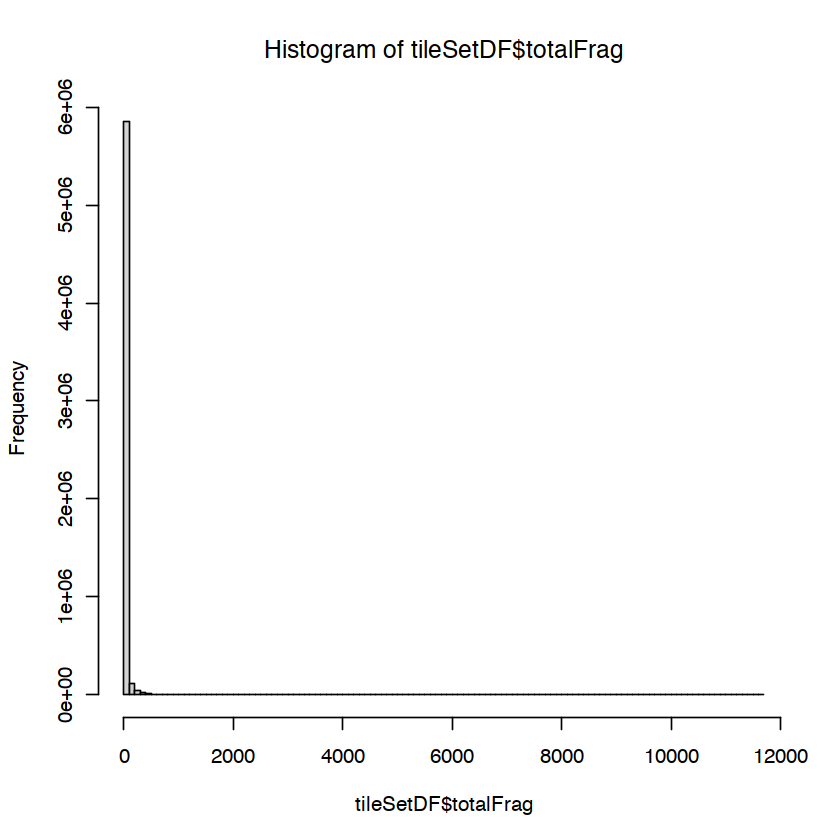

In [12]:
hist(tileSetDF$totalFrag, breaks=100)

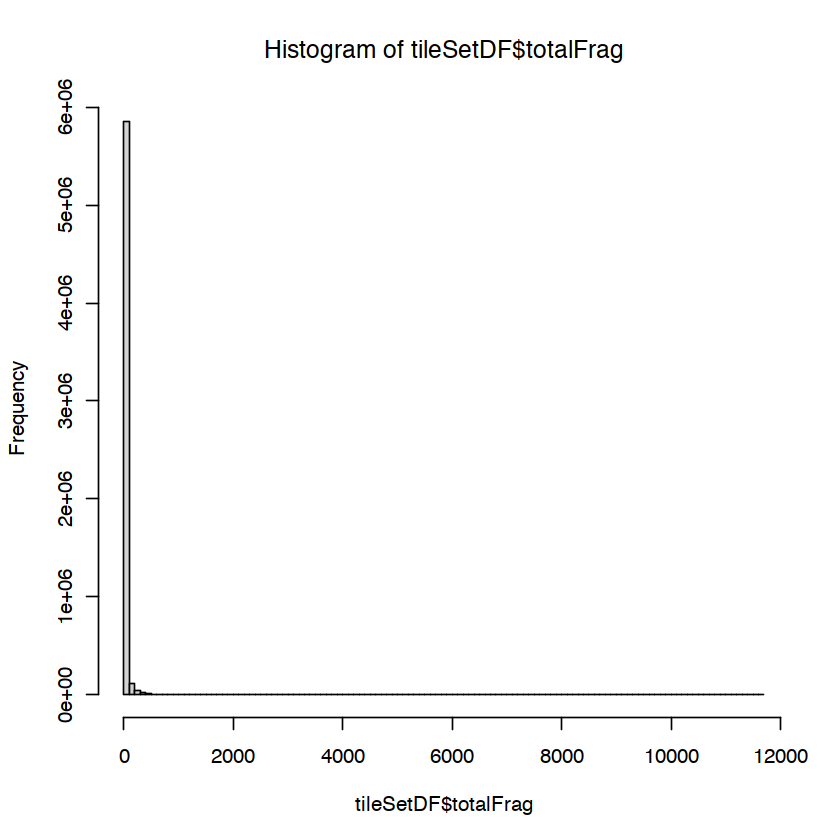

In [13]:
hist(tileSetDF$totalFrag, breaks=100)

In [14]:
library(ggplot2)

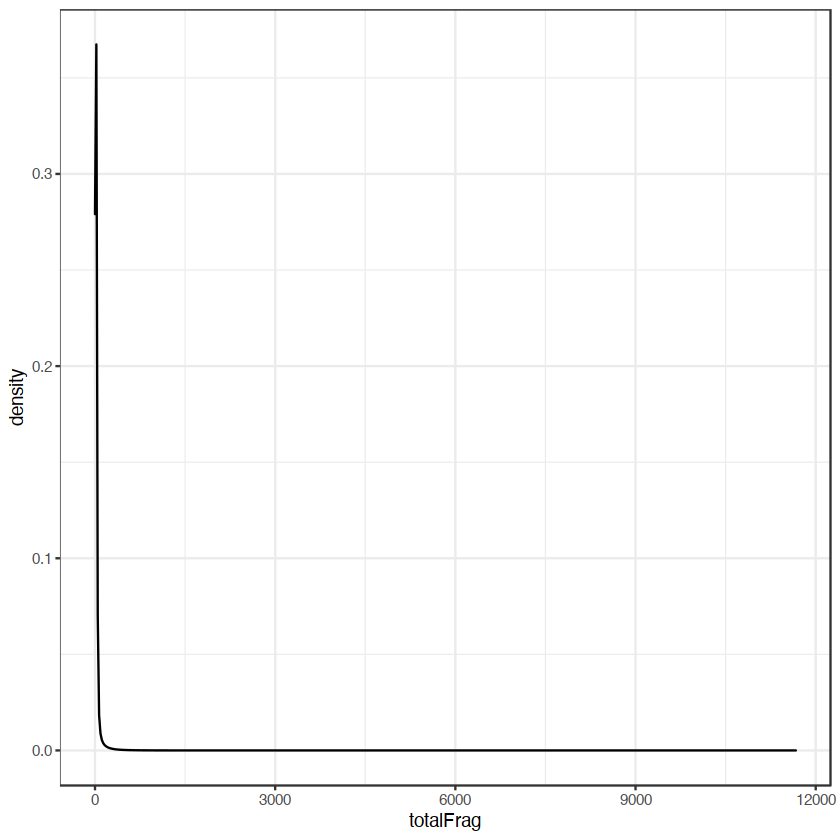

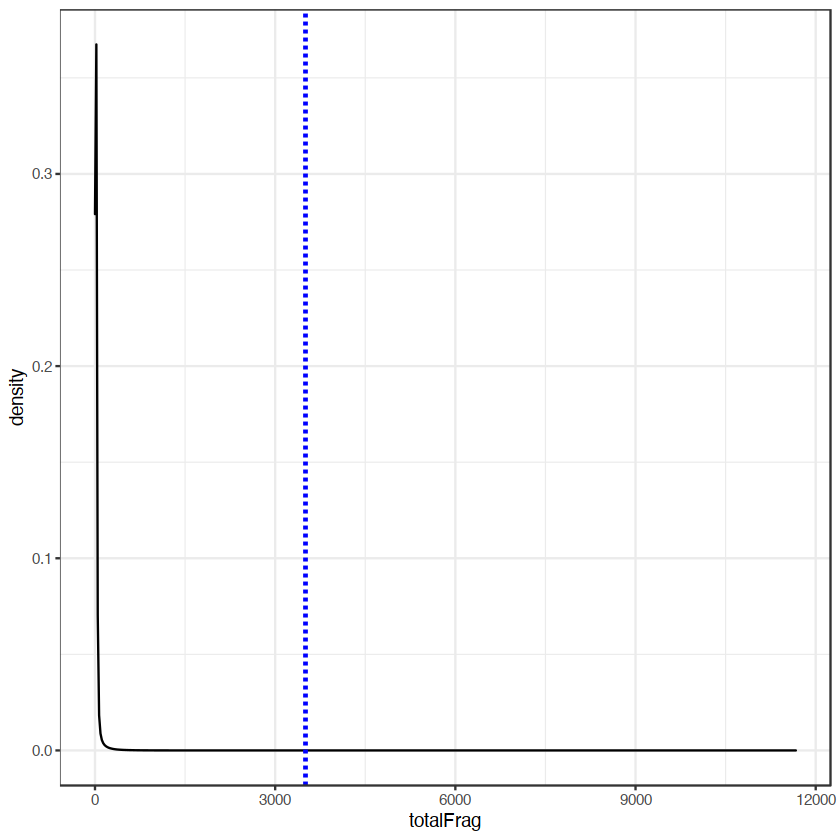

In [36]:
p <- ggplot(tileSetDF, aes(x=totalFrag)) + 
  geom_density() +
    theme_bw()
p
# Add mean line
p+ geom_vline(aes(xintercept=250*median(totalFrag)),
            color="blue", linetype="dashed", size=1) +
    theme_bw()

In [47]:
is.outlier = isOutlier(tileSetDF$totalFrag, nmads=250)
sum(is.outlier)

[1] 148

In [86]:
quantileVal <- quantile(tileSetDF$totalFrag, 0.99995)
quantileVal

#outlier_values <- boxplot.stats(tileSetDF$totalFrag)$out
#outlier_values

99.995% 
2202.791

In [82]:
tileSetDF$amplification <- 0
tileSetDF[tileSetDF$totalFrag > quantileVal,'amplification'] <- 1

In [83]:
sum(tileSetDF$amplification)

[1] 304

In [48]:
min(tileSetDF[is.outlier,]$totalFrag)

[1] 2988

In [49]:
#threshold = 300*median(tileSetDF$totalFrag)
#threshold

In [50]:
tileSetDF$amplification <- 0
#tileSetDF[tileSetDF$totalFrag > threshold,'amplification'] <- 1
tileSetDF[is.outlier,'amplification'] <- 1

In [51]:
sum(tileSetDF$amplification)

[1] 148

In [52]:
ampIndex <- which(tileSetDF$amplification==1)
head(ampIndex)

[1] 647566 670957 671336 740232 740394 740563

In [53]:
ampIndex <- which(tileSetDF$amplification==1)
head(ampIndex)

[1] 647566 670957 671336 740232 740394 740563

In [54]:
tileSetDF[tileSetDF$amplification == 1,]

seqnames starts    end       totalFrag amplification
647566  chr10     74826000  74826500  3316     1            
670957  chr10     86521500  86522000  3768     1            
671336  chr10     86711000  86711500  3272     1            
740232  chr10    121159000 121159500  5551     1            
740394  chr10    121240000 121240500  4817     1            
740563  chr10    121324500 121325000  3330     1            
740961  chr10    121523500 121524000  3047     1            
741111  chr10    121598500 121599000  3325     1            
741770  chr10    121928000 121928500  5418     1            
741785  chr10    121935500 121936000  3946     1            
857113  chr11     45802000  45802500  4195     1            
857117  chr11     45804000  45804500  5317     1            
857118  chr11     45804500  45805000  5211     1            
857119  chr11     45805000  45805500  8183     1            
857120  chr11     45805500  45806000  3829     1            
857195  chr11     45843000  45843500  5615     1            
857196  chr11     45843500  45844000  4901     1            
857203  chr11     45847000  45847500 10728     1            
857204  chr11     45847500  45848000  4066     1            
857344  chr11     45917500  45918000  5107     1            
857345  chr11     45918000  45918500  6389     1            
857346  chr11     45918500  45919000  3744     1            
857987  chr11     46239000  46239500  3020     1            
857995  chr11     46243000  46243500  5051     1            
857996  chr11     46243500  46244000  3354     1            
858014  chr11     46252500  46253000  4942     1            
858017  chr11     46254000  46254500  4125     1            
858053  chr11     46272000  46272500  3195     1            
858054  chr11     46272500  46273000  6223     1            
858055  chr11     46273000  46273500  5306     1            
⋮       ⋮        ⋮         ⋮         ⋮         ⋮            
3159478 chr20     50440500  50441000  4038     1            
4973772 chr7      54759000  54759500  3922     1            
4974291 chr7      55018500  55019000  5666     1            
4974292 chr7      55019000  55019500  4158     1            
4974294 chr7      55020000  55020500  3697     1            
4974385 chr7      55065500  55066000  3182     1            
4974400 chr7      55073000  55073500  3147     1            
4974401 chr7      55073500  55074000  5006     1            
4974402 chr7      55074000  55074500 11669     1            
4974409 chr7      55077500  55078000  9062     1            
4974410 chr7      55078000  55078500  5760     1            
4974411 chr7      55078500  55079000  4075     1            
4974412 chr7      55079000  55079500  6593     1            
4974437 chr7      55091500  55092000  3777     1            
4974495 chr7      55120500  55121000  3132     1            
4974519 chr7      55132500  55133000  5725     1            
4974520 chr7      55133000  55133500  8201     1            
4974521 chr7      55133500  55134000  5224     1            
4974612 chr7      55179000  55179500  3116     1            
4974616 chr7      55181000  55181500  4970     1            
4974617 chr7      55181500  55182000  3395     1            
4974630 chr7      55188000  55188500  3010     1            
4974631 chr7      55188500  55189000  3727     1            
4974763 chr7      55254500  55255000  3038     1            
4974764 chr7      55255000  55255500  3467     1            
4974765 chr7      55255500  55256000  4111     1            
4974985 chr7      55365500  55366000  5698     1            
4974986 chr7      55366000  55366500  7014     1            
5387424 chr8     102239000 102239500  3436     1            
5401614 chr8     109334000 109334500  3107     1

In [55]:
tileSetDF[tileSetDF$seqnames %in% 'chr7' & tileSetDF$amplification == 1,]

seqnames starts   end      totalFrag amplification
4973772 chr7     54759000 54759500  3922     1            
4974291 chr7     55018500 55019000  5666     1            
4974292 chr7     55019000 55019500  4158     1            
4974294 chr7     55020000 55020500  3697     1            
4974385 chr7     55065500 55066000  3182     1            
4974400 chr7     55073000 55073500  3147     1            
4974401 chr7     55073500 55074000  5006     1            
4974402 chr7     55074000 55074500 11669     1            
4974409 chr7     55077500 55078000  9062     1            
4974410 chr7     55078000 55078500  5760     1            
4974411 chr7     55078500 55079000  4075     1            
4974412 chr7     55079000 55079500  6593     1            
4974437 chr7     55091500 55092000  3777     1            
4974495 chr7     55120500 55121000  3132     1            
4974519 chr7     55132500 55133000  5725     1            
4974520 chr7     55133000 55133500  8201     1            
4974521 chr7     55133500 55134000  5224     1            
4974612 chr7     55179000 55179500  3116     1            
4974616 chr7     55181000 55181500  4970     1            
4974617 chr7     55181500 55182000  3395     1            
4974630 chr7     55188000 55188500  3010     1            
4974631 chr7     55188500 55189000  3727     1            
4974763 chr7     55254500 55255000  3038     1            
4974764 chr7     55255000 55255500  3467     1            
4974765 chr7     55255500 55256000  4111     1            
4974985 chr7     55365500 55366000  5698     1            
4974986 chr7     55366000 55366500  7014     1

In [274]:
tileSetDF$secondryAmplification <- tileSetDF$amplification
for(i in 1:length(ampIndex)){
    # Forward indexing
    ampNum <- 0
    forwardFlag = 0
    for(j in 1:30){
        if(forwardFlag ==6){
            break
        }
        else if(tileSetDF[ampIndex[i]+j,'totalFrag'] > tileSetDF[ampIndex[i],'totalFrag']/6){
            tileSetDF[ampIndex[i]+j,'secondryAmplification'] <- 1
            
        }
        else{
            forwardFlag = forwardFlag + 1
        }
        
    }
    
    # Backward indexing
    backwardFlag = 0
    for(j in 1:30){
        if(backwardFlag ==6){
            break
        }
        else if(tileSetDF[ampIndex[i]-j,'totalFrag'] > tileSetDF[ampIndex[i],'totalFrag']/6){
            tileSetDF[ampIndex[i]-j,'secondryAmplification'] <- 1
            
        }
        else{
            backwardFlag = backwardFlag + 1
        }
        
    }
}

In [56]:
tileSetDF$secondryAmplification <- tileSetDF$amplification
for(i in 1:length(ampIndex)){
    
    # Forward indexing
    Flag = 0
    j <- 1
    while(Flag < 6){
        if(tileSetDF[ampIndex[i]+j,'totalFrag'] > 5){
            tileSetDF[ampIndex[i]+j,'secondryAmplification'] <- 1
            j <- j+1
            
        }
        else{
            Flag <- Flag + 1
            j <- j + 1
        }
        
    }
    
    # Backward indexing
    j <- 1
    Flag = 0
    while(Flag < 6){
        if(tileSetDF[ampIndex[i]-j,'totalFrag'] > 5){
            tileSetDF[ampIndex[i]-j,'secondryAmplification'] <- 1
            j <- j+1
            
        }
        else{
            Flag <- Flag + 1
            j <- j + 1
        }
        
    }
}

In [57]:
head(tileSetDF[tileSetDF$secondryAmplification == 1,])

seqnames starts   end      totalFrag amplification secondryAmplification
647130 chr10    74608000 74608500  8        0             1                    
647131 chr10    74608500 74609000 22        0             1                    
647132 chr10    74609000 74609500 23        0             1                    
647133 chr10    74609500 74610000 18        0             1                    
647134 chr10    74610000 74610500 23        0             1                    
647135 chr10    74610500 74611000 11        0             1

In [58]:
tile.anno <- tileSetDF[tileSetDF$secondryAmplification == 1,]
tile.anno.GR <- makeGRangesFromDataFrame(tile.anno,
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("seqnames", "seqname",
                                          "chromosome", "chrom",
                                          "chr", "chromosome_name",
                                          "seqid"),
                         start.field="starts",
                         end.field=c("end", "stop"),
                         strand.field="strand",
                         starts.in.df.are.0based=FALSE)

In [59]:
library(ChIPpeakAnno)

In [60]:
tile.anno.GR

GRanges object with 22945 ranges and 0 metadata columns:
          seqnames              ranges strand
             <Rle>           <IRanges>  <Rle>
   647130    chr10   74608000-74608500      *
   647131    chr10   74608500-74609000      *
   647132    chr10   74609000-74609500      *
   647133    chr10   74609500-74610000      *
   647134    chr10   74610000-74610500      *
      ...      ...                 ...    ...
  5401709     chr8 109381500-109382000      *
  5401710     chr8 109382000-109382500      *
  5401711     chr8 109382500-109383000      *
  5401713     chr8 109383500-109384000      *
  5401714     chr8 109384000-109384500      *
  -------
  seqinfo: 9 sequences from an unspecified genome; no seqlengths

In [61]:
tile.anno.GR.anno <- annotatePeakInBatch(tile.anno.GR, AnnotationData=TSS.human.GRCh38)
tile.anno.GR.anno <- addGeneIDs(annotatedPeak=tile.anno.GR.anno, 
                        orgAnn="org.Hs.eg.db", 
                        IDs2Add="symbol")

In [62]:
tile.anno.GR.anno[tile.anno.GR.anno$symbol %in% 'EGFR']

GRanges object with 255 ranges and 10 metadata columns:
                           seqnames            ranges strand |        peak
                              <Rle>         <IRanges>  <Rle> | <character>
  X4974207.ENSG00000146648     chr7 54976500-54977000      * |     4974207
  X4974208.ENSG00000146648     chr7 54977000-54977500      * |     4974208
  X4974209.ENSG00000146648     chr7 54977500-54978000      * |     4974209
  X4974210.ENSG00000146648     chr7 54978000-54978500      * |     4974210
  X4974211.ENSG00000146648     chr7 54978500-54979000      * |     4974211
                       ...      ...               ...    ... .         ...
  X4974457.ENSG00000146648     chr7 55101500-55102000      * |     4974457
  X4974458.ENSG00000146648     chr7 55102000-55102500      * |     4974458
  X4974459.ENSG00000146648     chr7 55102500-55103000      * |     4974459
  X4974460.ENSG00000146648     chr7 55103000-55103500      * |     4974460
  X4974461.ENSG00000146648     chr7 55103500

In [63]:
write.table(tile.anno.GR.anno, 'Amplified_till_flat_withOutlier.csv', sep=',', row.names = FALSE)

In [35]:
markerGenes  <- c(
    "EGFR",
"FGFR2",
"ERBB3",
"NOTCH1",
"NCAM1",
"VIP",
"SLC18A1"
  )

p <- plotEmbedding(
    ArchRProj = chrisAggrproj, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(chrisAggrproj)
)

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-14f3528a2ac92-Date-2021-07-28_Time-19-37-54.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2021-07-28 19:37:55 : 

1 
2 


Imputing Matrix

Using weights on disk

1 of 1

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-14f3528a2ac92-Date-2021-07-28_Time-19-37-54.log



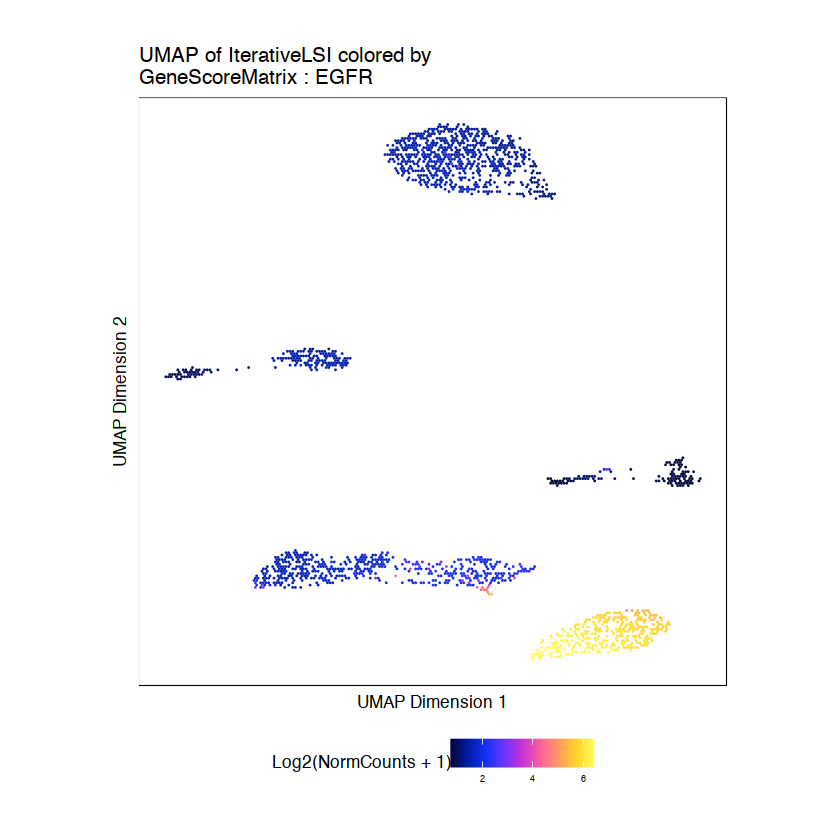

In [308]:
p$EGFR

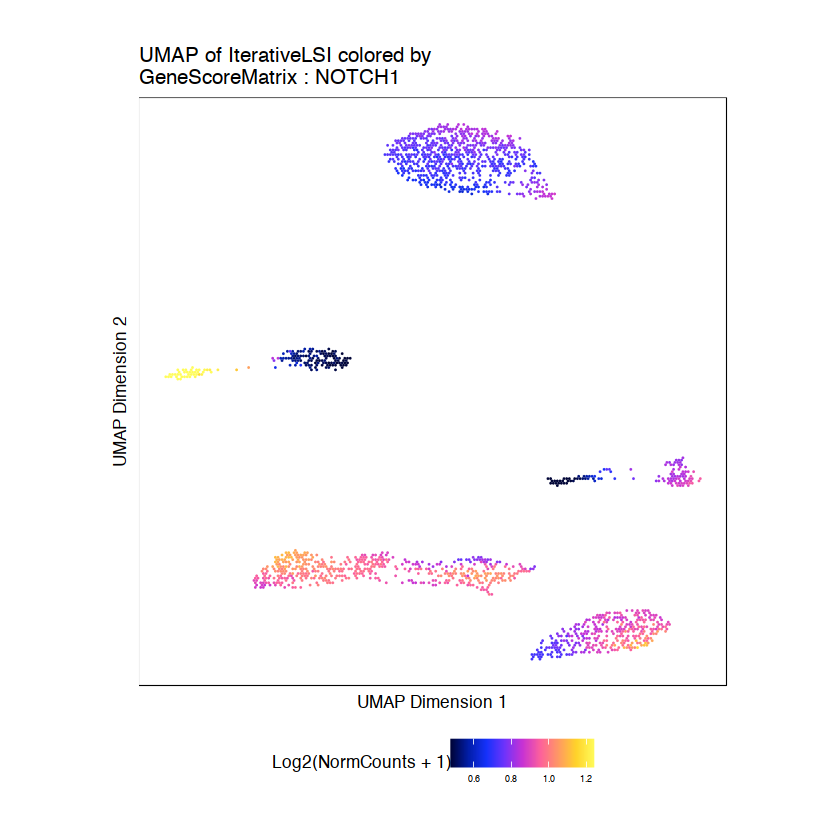

In [309]:
p$NOTCH1

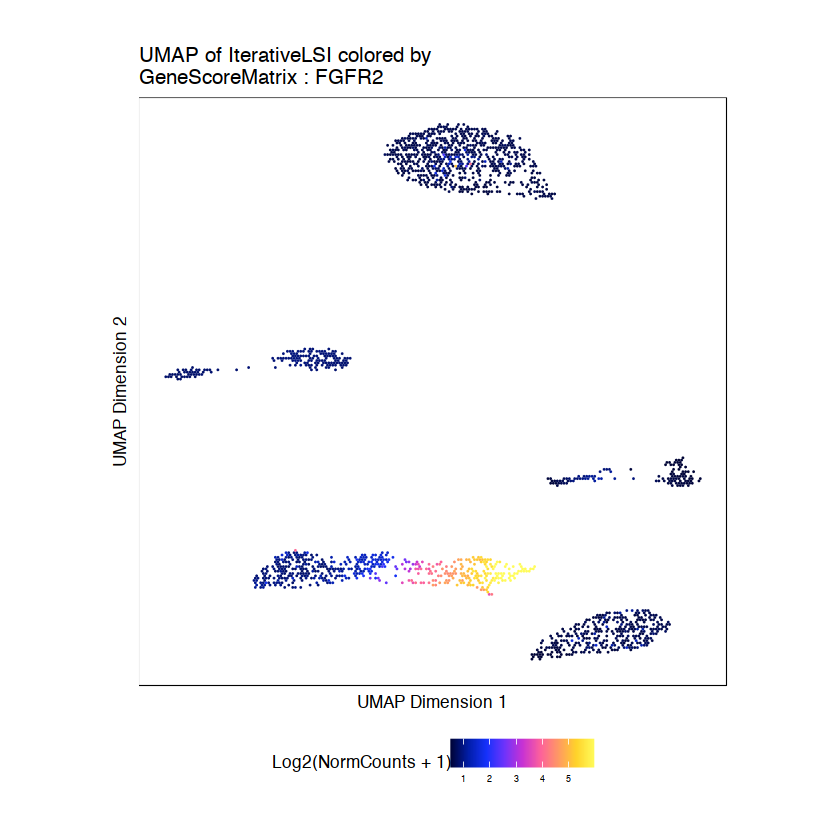

In [310]:
p$FGFR2

In [33]:
peakMtxSummary <- data.frame(totalFrag = rowSums(assay(peakMtx, 'PeakMatrix')),
                             GC=peakSet$GC)

In [34]:
head(peakMtxSummary)

[1]  87 373  95 146 223 225

In [23]:
rowData(peakMtx)

DataFrame with 106002 rows and 1 column
           idx
       <array>
1            1
2            2
3            3
4            4
5            5
...        ...
105998    3076
105999    3077
106000    3078
106001    3079
106002    3080